Customer Churn & CLV Prediction 

## Business Context
- **Vấn đề**: CAC (Customer Acquisition Cost) tăng cao, Churn cao ở nhóm khách hàng giá trị, Campaign retention gửi đại trà → tốn chi phí, ROI thấp
- **Mục tiêu**: Giảm churn, Tối đa hóa CLV (Customer Lifetime Value), Tránh over-treatment (spam khách hàng không cần giữ)
- **Câu hỏi then chốt**: Nếu ngân sách retention chỉ đủ giữ 20% customer base, chọn 20% nào?

## Project Structure
1. **Part 0**: Data Exploration
2. **Part 1**: Customer Value Foundations (RFM Analysis)
3. **Part 2**: Churn Prediction as Classification
4. **Part 3**: Churn via BG-NBD (Probability Model)
5. **Part 4**: Churn with Survival Analysis
6. **Part 5**: CLV Modeling (BG-NBD + Gamma-Gamma & Survival + Gamma-Gamma)
7. **Part 6**: Final Business Question - 3 Retention Strategies Comparison

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path for importing src modules
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

# Statistical & ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, auc
)

# Survival Analysis
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter
from lifelines.utils import median_survival_times

# CLV & Probabilistic Models
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix

# ✅ UPDATED: Import ChurnFeatureEngineer (đã fix data leakage) và generate_training_data
from src.feature_engineer import ChurnFeatureEngineer, prepare_features_for_model, generate_training_data


# Visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Data Exploration 
Phân tích qua để hiểu dữ liệu

In [2]:
# Load Data
customers = pd.read_csv('../data/customers.csv')
transactions = pd.read_csv('../data/transactions.csv')

# Convert dates
customers['signup_date'] = pd.to_datetime(customers['signup_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

print("📊 Customers Dataset:")
display(customers.head(10))
print(f"Shape: {customers.shape}")

print("\n" + "="*80)
print("📊 Transactions Dataset:")
display(transactions.head(10))
print(f"Shape: {transactions.shape}")

📊 Customers Dataset:


,customer_id,signup_date,true_lifetime_days
0,C00000,2025-08-22,204
1,C00001,2025-03-07,365
2,C00002,2025-08-18,48
3,C00003,2025-09-22,84
4,C00004,2025-05-28,113
5,C00005,2025-11-12,120
6,C00006,2025-08-22,117
7,C00007,2025-08-03,321
8,C00008,2025-05-02,209
9,C00009,2025-01-06,172


Shape: (3000, 3)

📊 Transactions Dataset:


,customer_id,transaction_date,amount
0,C00000,2025-09-10,195.78
1,C00000,2025-09-12,50.87
2,C00000,2025-10-01,133.25
3,C00000,2025-10-16,37.44
4,C00000,2025-10-18,101.95
5,C00000,2025-10-28,195.22
6,C00000,2025-11-23,206.80
7,C00000,2025-11-27,79.74
8,C00000,2025-12-09,85.42
9,C00000,2025-12-27,47.99


Shape: (46704, 3)


In [3]:
# Basic info about datasets
print("Customers Info:")
print(customers.info())
print("\nTransactions Info:")
print(transactions.info())

Customers Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         3000 non-null   object        
 1   signup_date         3000 non-null   datetime64[ns]
 2   true_lifetime_days  3000 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 70.4+ KB
None

Transactions Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46704 entries, 0 to 46703
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       46704 non-null  object        
 1   transaction_date  46704 non-null  datetime64[ns]
 2   amount            46704 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ MB
None


In [4]:
# Data Quality Check
print("\nCustomers missing values:")
print(customers.isnull().sum())
print("\nTransactions missing values:")
print(transactions.isnull().sum())

print("\nDate Ranges:")
print(f"Customer signup: {customers['signup_date'].min()} to {customers['signup_date'].max()}")
print(f"Transactions: {transactions['transaction_date'].min()} to {transactions['transaction_date'].max()}")

# Set observation/analysis cutoff date
OBSERVATION_DATE = transactions['transaction_date'].max() + pd.Timedelta(days=1)
print(f"\nObservation Date (last transaction): {OBSERVATION_DATE}")


Customers missing values:
customer_id           0
signup_date           0
true_lifetime_days    0
dtype: int64

Transactions missing values:
customer_id         0
transaction_date    0
amount              0
dtype: int64

Date Ranges:
Customer signup: 2025-01-02 00:00:00 to 2025-12-02 00:00:00
Transactions: 2025-01-03 00:00:00 to 2025-12-31 00:00:00

Observation Date (last transaction): 2026-01-01 00:00:00


True Lifetime Days Statistics:
count    3000.000000
mean      156.771000
std        97.302387
min        30.000000
25%        78.000000
50%       137.000000
75%       220.000000
max       365.000000
Name: true_lifetime_days, dtype: float64


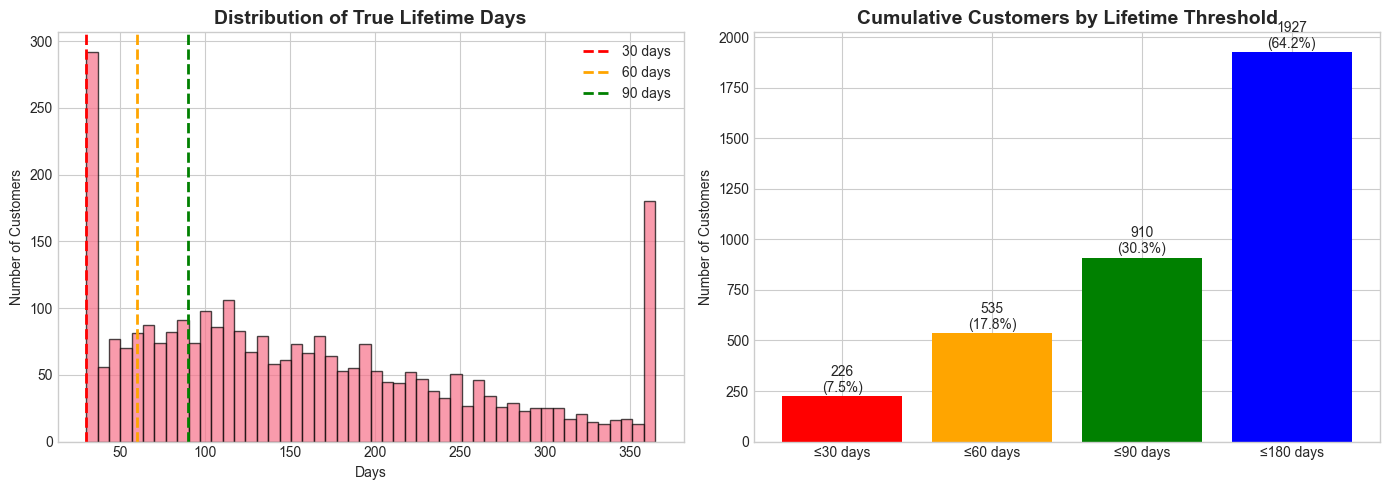

In [5]:
# Lưu ý: Dataset có cột true_lifetime_days - đây là thông tin về thời gian hoạt động thực tế của khách hàng
# Tuy nhiên, trong thực tế chúng ta không có thông tin này
# Chúng ta cần định nghĩa churn dựa trên inactivity window

print("True Lifetime Days Statistics:")
print(customers['true_lifetime_days'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of true_lifetime_days
axes[0].hist(customers['true_lifetime_days'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='30 days')
axes[0].axvline(60, color='orange', linestyle='--', linewidth=2, label='60 days')
axes[0].axvline(90, color='green', linestyle='--', linewidth=2, label='90 days')
axes[0].set_title('Distribution of True Lifetime Days', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Number of Customers')
axes[0].legend()

# Count of customers with lifetime <= 30, 60, 90 days
short_lived = [
    (customers['true_lifetime_days'] <= 30).sum(),
    (customers['true_lifetime_days'] <= 60).sum(),
    (customers['true_lifetime_days'] <= 90).sum(),
    (customers['true_lifetime_days'] <= 180).sum()
]
axes[1].bar(['≤30 days', '≤60 days', '≤90 days', '≤180 days'], short_lived, color=['red', 'orange', 'green', 'blue'])
axes[1].set_title('Cumulative Customers by Lifetime Threshold', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Customers')
for i, v in enumerate(short_lived):
    axes[1].text(i, v + 20, f'{v}\n({v/len(customers)*100:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Transaction Pattern Analysis

In [6]:
# Transaction statistics per customer
customer_tx_stats = transactions.groupby('customer_id').agg({
    'transaction_date': ['count', 'min', 'max'],
    'amount': ['sum', 'mean', 'std']
})
customer_tx_stats.columns = ['tx_count', 'first_tx', 'last_tx', 'total_spent', 'avg_tx_value', 'std_tx_value']
customer_tx_stats = customer_tx_stats.reset_index()

# Calculate customer age (days from first to last transaction)
customer_tx_stats['customer_age_days'] = (customer_tx_stats['last_tx'] - customer_tx_stats['first_tx']).dt.days

# Days since last transaction (recency)
customer_tx_stats['recency'] = (OBSERVATION_DATE - customer_tx_stats['last_tx']).dt.days

print("Customer Transaction Statistics:")
customer_tx_stats.describe()

Customer Transaction Statistics:


,tx_count,first_tx,last_tx,total_spent,avg_tx_value,std_tx_value,customer_age_days,recency
count,2892.000000,2892,2892,2892.000000,2892.000000,2757.000000,2892.000000,2892.000000
mean,16.149378,2025-07-01 05:48:32.863070720,2025-10-04 19:01:44.564315392,940.920654,59.074524,39.278584,95.550830,88.207123
min,1.000000,2025-01-03 00:00:00,2025-01-12 00:00:00,1.700000,0.690000,0.042426,0.000000,1.000000
25%,5.000000,2025-04-11 00:00:00,2025-07-30 00:00:00,206.612500,30.862632,19.165691,37.000000,7.000000
50%,11.000000,2025-07-05 00:00:00,2025-11-07 00:00:00,538.440000,51.545982,33.121665,80.000000,55.000000
75%,21.000000,2025-09-21 00:00:00,2025-12-25 00:00:00,1212.687500,76.690114,52.030843,140.250000,155.000000
max,155.000000,2025-12-28 00:00:00,2025-12-31 00:00:00,13966.820000,399.520000,242.156361,354.000000,354.000000
std,17.138352,NaN,NaN,1206.226060,39.140065,28.407953,72.430698,90.953968


In [7]:
# Analyze purchase intervals - Critical for churn definition
def analyze_purchase_intervals(transactions_df):
    """
    Phân tích khoảng cách giữa các lần mua hàng - nền tảng cho churn definition
    """
    intervals = []
    
    for customer_id in transactions_df['customer_id'].unique():
        customer_tx = transactions_df[transactions_df['customer_id'] == customer_id].sort_values('transaction_date')
        if len(customer_tx) > 1:
            dates = customer_tx['transaction_date'].values
            for i in range(1, len(dates)):
                interval = (pd.to_datetime(dates[i]) - pd.to_datetime(dates[i-1])).days
                intervals.append({'customer_id': customer_id, 'interval': interval})
    
    return pd.DataFrame(intervals)

print("Analyzing purchase intervals")
interval_df = analyze_purchase_intervals(transactions)

print("\nPurchase Interval Statistics:")
print(f"Total intervals analyzed: {len(interval_df)}")
print(f"Mean interval: {interval_df['interval'].mean():.2f} days")
print(f"Median interval: {interval_df['interval'].median():.2f} days")
print(f"Std interval: {interval_df['interval'].std():.2f} days")
print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95]:
    print(f"  {p}th percentile: {np.percentile(interval_df['interval'], p):.2f} days")

Analyzing purchase intervals

Purchase Interval Statistics:
Total intervals analyzed: 43812
Mean interval: 6.31 days
Median interval: 3.00 days
Std interval: 9.34 days

Percentiles:
  25th percentile: 1.00 days
  50th percentile: 3.00 days
  75th percentile: 8.00 days
  90th percentile: 16.00 days
  95th percentile: 23.00 days


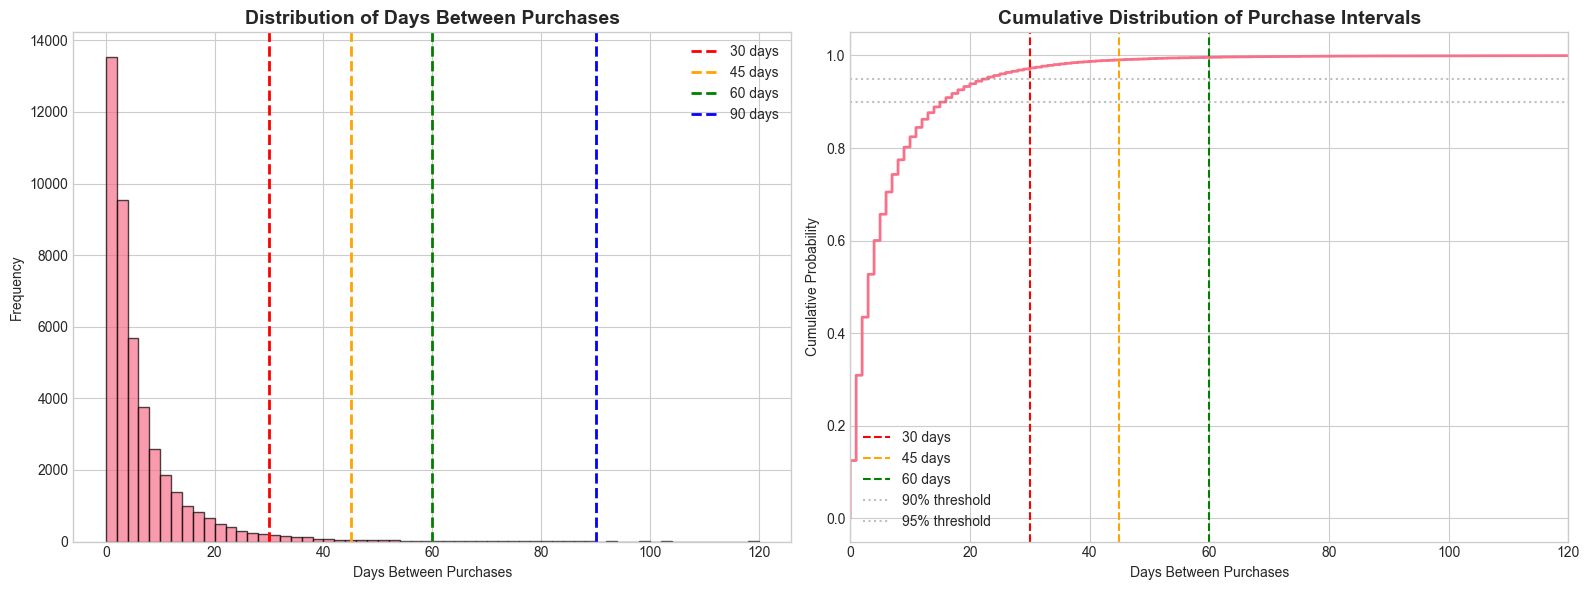

In [8]:
# Visualize purchase intervals distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with candidate thresholds
axes[0].hist(interval_df['interval'][interval_df['interval'] <= 120], bins=60, edgecolor='black', alpha=0.7)
axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='30 days')
axes[0].axvline(45, color='orange', linestyle='--', linewidth=2, label='45 days')
axes[0].axvline(60, color='green', linestyle='--', linewidth=2, label='60 days')
axes[0].axvline(90, color='blue', linestyle='--', linewidth=2, label='90 days')
axes[0].set_title('Distribution of Days Between Purchases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Between Purchases')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Cumulative distribution
sorted_intervals = np.sort(interval_df['interval'].values)
cumulative = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

axes[1].plot(sorted_intervals, cumulative, linewidth=2)
axes[1].axvline(30, color='red', linestyle='--', label='30 days')
axes[1].axvline(45, color='orange', linestyle='--', label='45 days')
axes[1].axvline(60, color='green', linestyle='--', label='60 days')
axes[1].axhline(0.9, color='gray', linestyle=':', alpha=0.5, label='90% threshold')
axes[1].axhline(0.95, color='gray', linestyle=':', alpha=0.5, label='95% threshold')
axes[1].set_xlim([0, 120])
axes[1].set_title('Cumulative Distribution of Purchase Intervals', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days Between Purchases')
axes[1].set_ylabel('Cumulative Probability')
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
print("="*80)
print("CHURN DEFINITION ANALYSIS")
print("="*80)

# Key metrics
mean_interval = interval_df['interval'].mean()
median_interval = interval_df['interval'].median()
p75_interval = np.percentile(interval_df['interval'], 75)
p90_interval = np.percentile(interval_df['interval'], 90)
p95_interval = np.percentile(interval_df['interval'], 95)

print(f"\nPurchase Interval Analysis:")
print(f"   • Mean interval between purchases: {mean_interval:.1f} days")
print(f"   • Median interval: {median_interval:.1f} days")
print(f"   • 75th percentile: {p75_interval:.1f} days (75% of customers return within this)")
print(f"   • 90th percentile: {p90_interval:.1f} days (90% of customers return within this)")
print(f"   • 95th percentile: {p95_interval:.1f} days (95% of customers return within this)")

CHURN DEFINITION ANALYSIS

Purchase Interval Analysis:
   • Mean interval between purchases: 6.3 days
   • Median interval: 3.0 days
   • 75th percentile: 8.0 days (75% of customers return within this)
   • 90th percentile: 16.0 days (90% of customers return within this)
   • 95th percentile: 23.0 days (95% of customers return within this)


In [10]:
# Also create labels for other windows for comparison later
for window in [30, 45, 60, 90]:
    customer_tx_stats[f'churn_{window}d'] = (customer_tx_stats['recency'] > window).astype(int)

print("All churn labels created (30d, 45d, 60d, 90d)")
print("\n📊 Preview:")
print(customer_tx_stats[['customer_id', 'recency', 'churn_30d', 'churn_45d', 'churn_60d', 'churn_90d']].head(10))

All churn labels created (30d, 45d, 60d, 90d)

📊 Preview:
  customer_id  recency  churn_30d  churn_45d  churn_60d  churn_90d
0      C00000        1          0          0          0          0
1      C00001       12          0          0          0          0
2      C00002       97          1          1          1          1
3      C00003       44          1          0          0          0
4      C00004      109          1          1          1          1
5      C00005        3          0          0          0          0
6      C00006       37          1          0          0          0
7      C00007       93          1          1          1          1
8      C00008       62          1          1          1          0
9      C00009      196          1          1          1          1


---
# PART 1: RFM Analysis


In [11]:
# Calculate RFM Metrics
def calculate_rfm(transactions_df, observation_date):
    """
    Calculate RFM (Recency, Frequency, Monetary) metrics for each customer
    """
    rfm = transactions_df.groupby('customer_id').agg({
        'transaction_date': lambda x: (observation_date - x.max()).days,  # Recency
        'amount': ['count', 'mean', 'sum']  # Frequency, Avg Monetary, Total
    })
    rfm.columns = ['recency', 'frequency', 'monetary', 'total_spent']
    rfm = rfm.reset_index()
    
    # Additional metrics
    first_purchase = transactions_df.groupby('customer_id')['transaction_date'].min()
    last_purchase = transactions_df.groupby('customer_id')['transaction_date'].max()
    
    rfm['first_purchase'] = rfm['customer_id'].map(first_purchase)
    rfm['last_purchase'] = rfm['customer_id'].map(last_purchase)
    rfm['customer_age_days'] = (observation_date - rfm['first_purchase']).dt.days
    
    return rfm

rfm = calculate_rfm(transactions, OBSERVATION_DATE)
print("📊 RFM Dataset:")
print(rfm.head(10))
print(f"\nShape: {rfm.shape}")
print("\nRFM Statistics:")
print(rfm[['recency', 'frequency', 'monetary', 'total_spent', 'customer_age_days']].describe())

📊 RFM Dataset:
  customer_id  recency  frequency    monetary  total_spent first_purchase  \
0      C00000        1         12  101.904167      1222.85     2025-09-10   
1      C00001       12         19   64.655789      1228.46     2025-03-17   
2      C00002       97         11   82.785455       910.64     2025-08-20   
3      C00003       44          4   28.677500       114.71     2025-10-04   
4      C00004      109         19  106.260000      2018.94     2025-06-08   
5      C00005        3          8   26.140000       209.12     2025-11-13   
6      C00006       37          3   28.650000        85.95     2025-09-04   
7      C00007       93          5  116.926000       584.63     2025-08-11   
8      C00008       62         14   54.868571       768.16     2025-05-08   
9      C00009      196         18   94.293333      1697.28     2025-01-07   

  last_purchase  customer_age_days  
0    2025-12-31                113  
1    2025-12-20                290  
2    2025-09-26           

In [12]:
# RFM Segmentation using Quantiles
def create_rfm_segments(rfm_df):
    """
    Create RFM segments based on quantile scores
    """
    # Calculate R, F, M scores (1-5, where 5 is best)
    # For Recency: lower is better (inverse)
    rfm_df['R_score'] = pd.qcut(rfm_df['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
    # For Frequency & Monetary: higher is better
    rfm_df['F_score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    rfm_df['M_score'] = pd.qcut(rfm_df['monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
    
    # Convert to int
    rfm_df['R_score'] = rfm_df['R_score'].astype(int)
    rfm_df['F_score'] = rfm_df['F_score'].astype(int)
    rfm_df['M_score'] = rfm_df['M_score'].astype(int)
    
    # RFM Score
    rfm_df['RFM_score'] = rfm_df['R_score'] + rfm_df['F_score'] + rfm_df['M_score']
    
    # Customer Segments based on RFM scores
    def assign_segment(row):
        r, f, m = row['R_score'], row['F_score'], row['M_score']
        
        if r >= 4 and f >= 4:
            return 'Champions'
        elif r >= 4 and f >= 2:
            return 'Loyal'
        elif r >= 4 and f == 1:
            return 'Promising'
        elif r == 3 and f >= 3:
            return 'Potential Loyalist'
        elif r == 3 and f <= 2:
            return 'New Customers'
        elif r == 2 and f >= 3:
            return 'At Risk'
        elif r == 2 and f <= 2:
            return 'About to Sleep'
        elif r == 1 and f >= 3:
            return 'Cannot Lose Them'
        elif r == 1 and f <= 2:
            return 'Hibernating'
        else:
            return 'Need Attention'
    
    rfm_df['segment'] = rfm_df.apply(assign_segment, axis=1)
    
    # High-Value / At-Risk Flags
    rfm_df['is_high_value'] = (rfm_df['RFM_score'] >= 12).astype(int)
    rfm_df['is_at_risk'] = rfm_df['segment'].isin(['At Risk', 'About to Sleep', 'Cannot Lose Them', 'Hibernating']).astype(int)
    
    return rfm_df

rfm = create_rfm_segments(rfm)
print("✅ RFM Segmentation Complete")
print("\n📊 Segment Distribution:")
print(rfm['segment'].value_counts())
print(f"\n📊 High-Value Customers: {rfm['is_high_value'].sum()} ({rfm['is_high_value'].mean()*100:.1f}%)")
print(f"📊 At-Risk Customers: {rfm['is_at_risk'].sum()} ({rfm['is_at_risk'].mean()*100:.1f}%)")

✅ RFM Segmentation Complete

📊 Segment Distribution:
segment
Champions             718
Loyal                 386
Hibernating           381
At Risk               294
Potential Loyalist    292
About to Sleep        288
New Customers         284
Cannot Lose Them      191
Promising              58
Name: count, dtype: int64

📊 High-Value Customers: 633 (21.9%)
📊 At-Risk Customers: 1154 (39.9%)


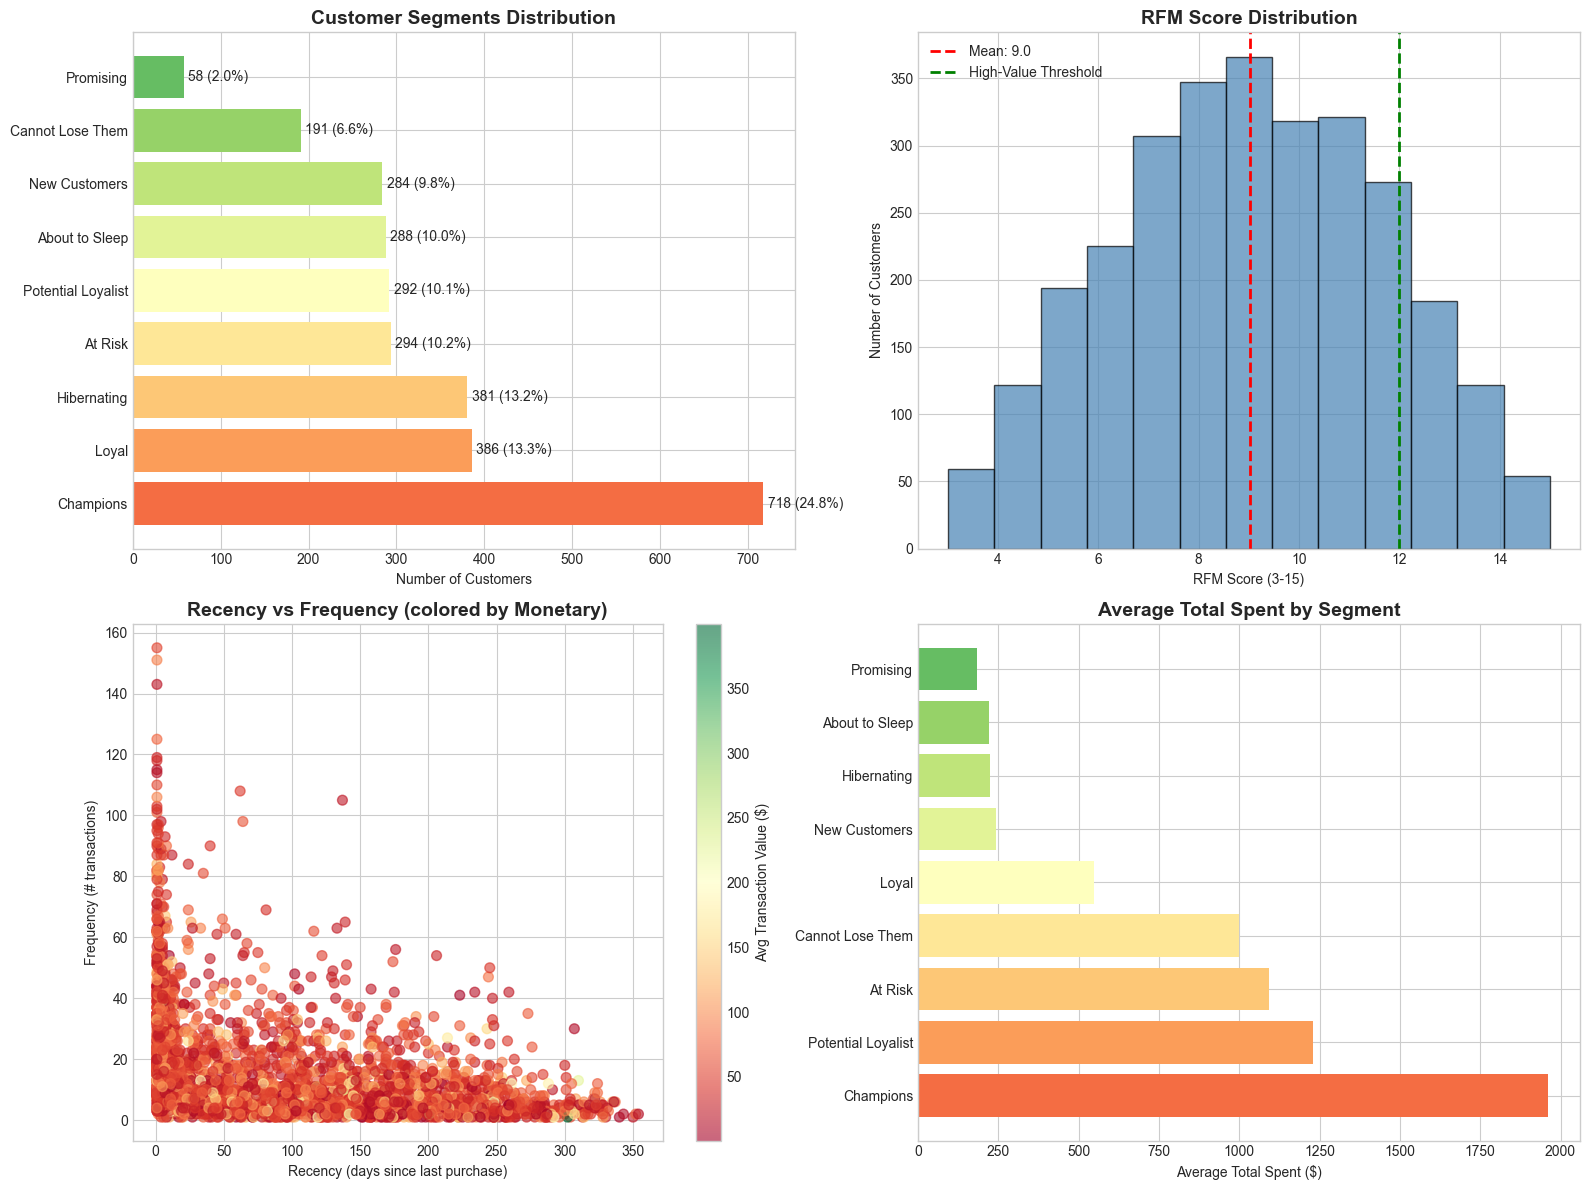

In [13]:
# Visualize RFM Segments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Segment distribution
segment_counts = rfm['segment'].value_counts()
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(segment_counts)))
axes[0, 0].barh(segment_counts.index, segment_counts.values, color=colors)
axes[0, 0].set_title('Customer Segments Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Customers')
for i, (v, s) in enumerate(zip(segment_counts.values, segment_counts.index)):
    axes[0, 0].text(v + 5, i, f'{v} ({v/len(rfm)*100:.1f}%)', va='center', fontsize=10)

# RFM Score distribution
axes[0, 1].hist(rfm['RFM_score'], bins=13, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('RFM Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('RFM Score (3-15)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].axvline(rfm['RFM_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rfm["RFM_score"].mean():.1f}')
axes[0, 1].axvline(12, color='green', linestyle='--', linewidth=2, label='High-Value Threshold')
axes[0, 1].legend()

# Recency vs Frequency with Monetary coloring
scatter = axes[1, 0].scatter(rfm['recency'], rfm['frequency'], 
                             c=rfm['monetary'], cmap='RdYlGn', alpha=0.6, s=50)
axes[1, 0].set_title('Recency vs Frequency (colored by Monetary)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Recency (days since last purchase)')
axes[1, 0].set_ylabel('Frequency (# transactions)')
plt.colorbar(scatter, ax=axes[1, 0], label='Avg Transaction Value ($)')

# Segment value comparison
segment_value = rfm.groupby('segment')['total_spent'].mean().sort_values(ascending=False)
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(segment_value)))
axes[1, 1].barh(segment_value.index, segment_value.values, color=colors)
axes[1, 1].set_title('Average Total Spent by Segment', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Total Spent ($)')

plt.tight_layout()
plt.show()

In [14]:
# Add churn labels to RFM data
rfm = rfm.merge(customer_tx_stats[['customer_id', 'churn_30d', 'churn_45d', 'churn_60d', 'churn_90d']], 
                on='customer_id', how='left')

print("Churn labels merged with RFM data")
print("\nRFM vs Churn Analysis:")
print(rfm.groupby('segment')['churn_60d'].agg(['mean', 'count']).sort_values('mean', ascending=False))

Churn labels merged with RFM data

RFM vs Churn Analysis:
                        mean  count
segment                            
About to Sleep      1.000000    288
At Risk             1.000000    294
Cannot Lose Them    1.000000    191
Hibernating         1.000000    381
Potential Loyalist  0.438356    292
New Customers       0.419014    284
Champions           0.000000    718
Loyal               0.000000    386
Promising           0.000000     58


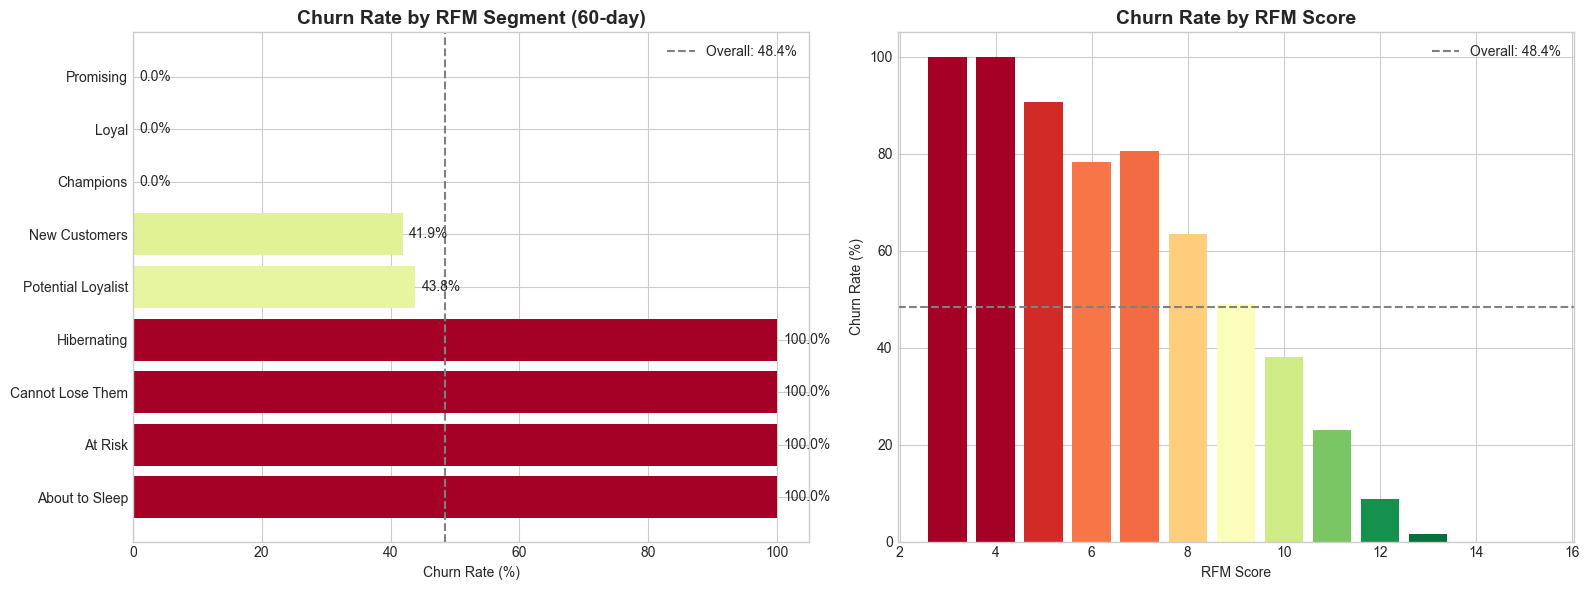

In [15]:
# Visualize churn rate by RFM segment
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Churn rate by segment
churn_by_segment = rfm.groupby('segment')['churn_60d'].mean().sort_values(ascending=False)
colors = plt.cm.RdYlGn(1 - churn_by_segment.values)  
bars = axes[0].barh(churn_by_segment.index, churn_by_segment.values * 100, color=colors)
axes[0].set_title('Churn Rate by RFM Segment (60-day)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Rate (%)')
axes[0].axvline(rfm['churn_60d'].mean()*100, color='gray', linestyle='--', label=f'Overall: {rfm["churn_60d"].mean()*100:.1f}%')
for bar, rate in zip(bars, churn_by_segment.values):
    axes[0].text(rate*100 + 1, bar.get_y() + bar.get_height()/2, f'{rate*100:.1f}%', va='center', fontsize=10)
axes[0].legend()

# Churn rate by RFM score
churn_by_rfm_score = rfm.groupby('RFM_score')['churn_60d'].mean()
axes[1].bar(churn_by_rfm_score.index, churn_by_rfm_score.values * 100, 
            color=plt.cm.RdYlGn(1 - churn_by_rfm_score.values))
axes[1].set_title('Churn Rate by RFM Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('RFM Score')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].axhline(rfm['churn_60d'].mean()*100, color='gray', linestyle='--', label=f'Overall: {rfm["churn_60d"].mean()*100:.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

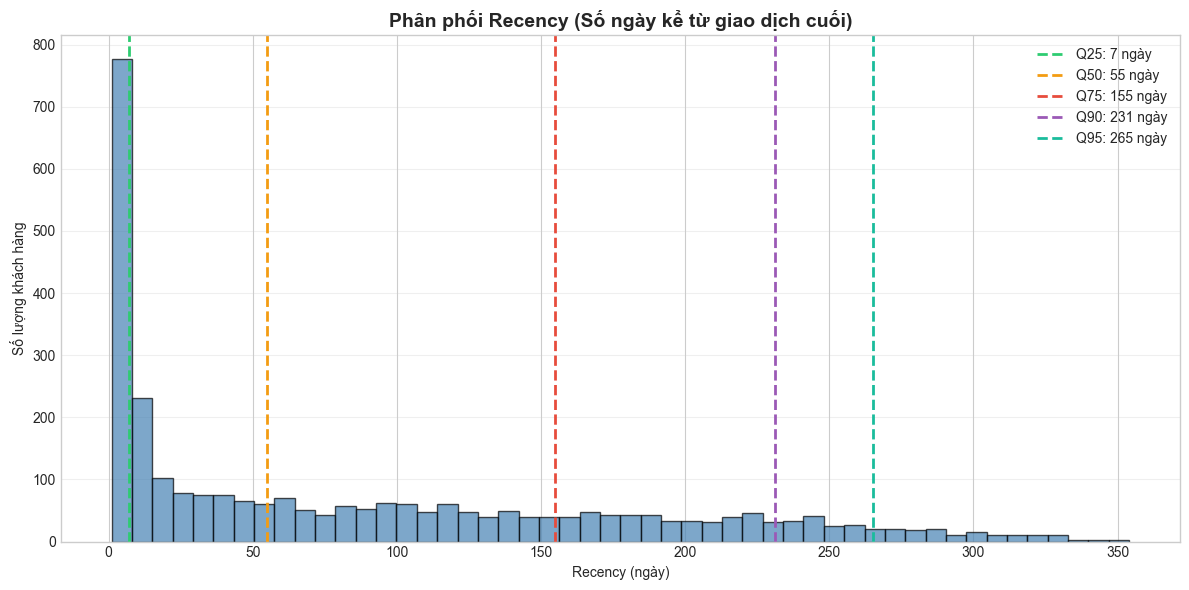


Thống kê mô tả Recency:
   • Số khách hàng: 2892
   • Mean (Trung bình): 88.21 ngày
   • Median (Trung vị): 55.00 ngày
   • Std (Độ lệch chuẩn): 90.95 ngày
   • Min: 1 ngày
   • Max: 354 ngày


In [16]:
# Phân phối của Recency (số ngày kể từ giao dịch cuối cùng)
fig, ax = plt.subplots(figsize=(12, 6))

# Histogram
ax.hist(customer_tx_stats['recency'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')

# Thêm các quantile lines
quantiles = [25, 50, 75, 90, 95]
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c']
for q, color in zip(quantiles, colors):
    q_value = np.percentile(customer_tx_stats['recency'], q)
    ax.axvline(q_value, color=color, linestyle='--', linewidth=2, label=f'Q{q}: {q_value:.0f} ngày')

ax.set_title('Phân phối Recency (Số ngày kể từ giao dịch cuối)', fontsize=14, fontweight='bold')
ax.set_xlabel('Recency (ngày)')
ax.set_ylabel('Số lượng khách hàng')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Thống kê mô tả
print("\nThống kê mô tả Recency:")
print(f"   • Số khách hàng: {len(customer_tx_stats)}")
print(f"   • Mean (Trung bình): {customer_tx_stats['recency'].mean():.2f} ngày")
print(f"   • Median (Trung vị): {customer_tx_stats['recency'].median():.2f} ngày")
print(f"   • Std (Độ lệch chuẩn): {customer_tx_stats['recency'].std():.2f} ngày")
print(f"   • Min: {customer_tx_stats['recency'].min()} ngày")
print(f"   • Max: {customer_tx_stats['recency'].max()} ngày")

---
# CHURN DEFINITION 

Trong dataset của chúng ta **không có churn label sẵn** (không có cột nào nói khách hàng đã churn hay chưa). Do đó, chúng ta cần **tự định nghĩa churn** dựa trên hành vi giao dịch của khách hàng.

## Phương pháp: Inactivity Window

Khách hàng được coi là **CHURN** nếu không có giao dịch nào trong một khoảng thời gian nhất định (inactivity window) tính từ observation date.


Churn Rate Comparison by Inactivity Window:
 window  churned  active  churn_rate
     30     1690    1202   58.437068
     45     1531    1361   52.939142
     60     1401    1491   48.443983
     90     1167    1725   40.352697


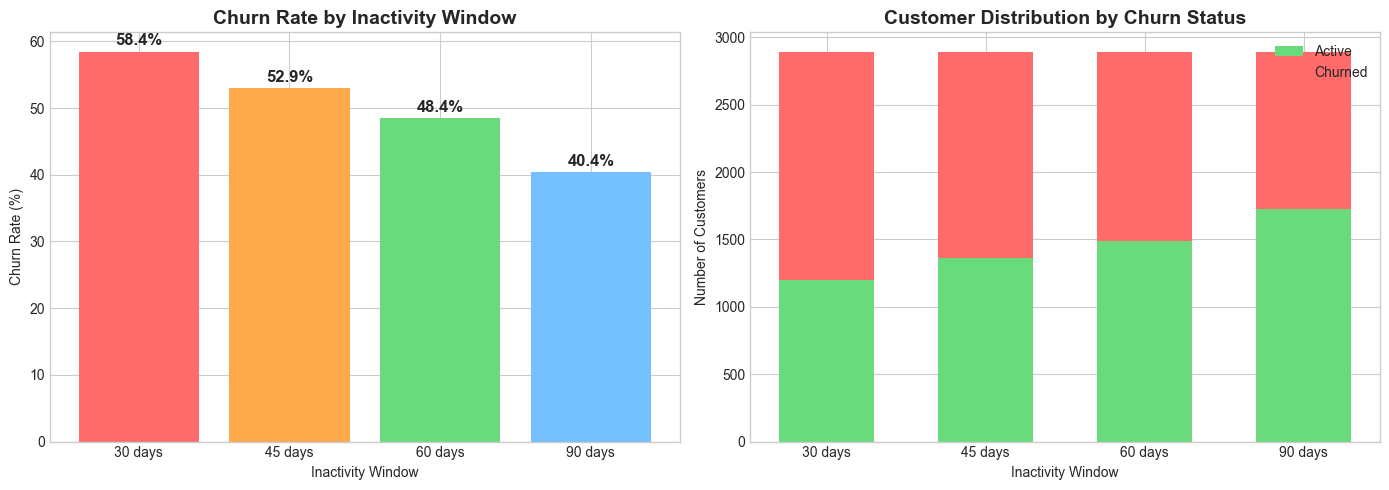

In [17]:
# Compare churn rates across different windows
def calculate_churn_rate_by_window(customer_stats, windows=[30, 45, 60, 90]):
    """
    Calculate churn rate for different inactivity windows
    """
    results = []
    for window in windows:
        churned = (customer_stats['recency'] > window).sum()
        total = len(customer_stats)
        churn_rate = churned / total * 100
        results.append({
            'window': window,
            'churned': churned,
            'active': total - churned,
            'churn_rate': churn_rate
        })
    return pd.DataFrame(results)

churn_comparison = calculate_churn_rate_by_window(customer_tx_stats)
print("\nChurn Rate Comparison by Inactivity Window:")
print(churn_comparison.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of churn rates
colors = ['#ff6b6b', '#ffa94d', '#69db7c', '#74c0fc']
bars = axes[0].bar(churn_comparison['window'].astype(str) + ' days', 
                   churn_comparison['churn_rate'], 
                   color=colors)
axes[0].set_title('Churn Rate by Inactivity Window', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Inactivity Window')
axes[0].set_ylabel('Churn Rate (%)')
for bar, rate in zip(bars, churn_comparison['churn_rate']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{rate:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Stacked bar for active vs churned
x = np.arange(len(churn_comparison))
width = 0.6
axes[1].bar(x, churn_comparison['active'], width, label='Active', color='#69db7c')
axes[1].bar(x, churn_comparison['churned'], width, bottom=churn_comparison['active'], label='Churned', color='#ff6b6b')
axes[1].set_xticks(x)
axes[1].set_xticklabels(churn_comparison['window'].astype(str) + ' days')
axes[1].set_title('Customer Distribution by Churn Status', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Inactivity Window')
axes[1].set_ylabel('Number of Customers')
axes[1].legend()

plt.tight_layout()
plt.show()

### Kết luận:

Dựa trên phân tích dữ liệu, đề xuất sử dụng **60-day inactivity window** để định nghĩa churn vì các lý do sau:

- Nếu chọn window 30 ngày thì cho thấy nếu chỉ sau 30 ngày không hoạt động đã coi là churn, bạn có thể đang "gắn mác nhầm" rất nhiều người dùng chỉ đơn giản là ít sử dụng (False Positive cao).
- Nếu chọn window 90 ngày thì lại quá trễ. Khi một khách hàng đã im lặng 3 tháng, nỗ lực lôi kéo họ quay lại thường rất tốn kém và kém hiệu quả.
- Điểm gãy: Từ 30 lên 45 ngày, tỷ lệ churn giảm mạnh (~6%). Từ 60 lên 90 ngày, tỷ lệ giảm tiếp ~8%.

## ⚠️ CRITICAL FIXES APPLIED (theo FEATURE_PREPARATION.md)

### Vấn đề trong code cũ:
1. **Data Leakage nghiêm trọng**: Đưa cả customers đã churn vào training → Model học luật tầm thường "recency cao = churn"
2. **Sample Selection Bias**: Không lọc "xác chết" khỏi training set
3. **Target Leakage**: Label dựa trên recency hiện tại thay vì hành vi tương lai

### Giải pháp đã áp dụng:

✅ **1. Tách `churn_window` và `prediction_window`**
- `churn_window=60`: Định nghĩa ai là "active" (recency < 60 ngày)
- `prediction_window=30`: Dự báo hành vi trong 30 ngày tới

✅ **2. FILTERING - Loại bỏ customers đã churn**
- Chỉ giữ lại customers có `recency < churn_window` tại observation_date
- Tránh model học từ những người đã "chết" rồi

✅ **3. Label calculation ĐÚNG**
- Label = 1 (Churn) nếu KHÔNG có giao dịch trong prediction_window
- Label = 0 (Retained) nếu CÓ giao dịch trong prediction_window

✅ **4. Sliding Window approach**
- Tạo training data từ nhiều snapshots (tháng 1-8/2025)
- Model học được pattern tổng quát hơn, không bị bias theo 1 thời điểm

✅ **5. Advanced Relative Features**
- Thêm features tương đối: `recency_to_tenure_ratio`, `recent_frequency_ratio`, etc.
- Model học behavior thay vì số tuyệt đối

### Kết quả:
- Training set bây giờ chỉ gồm **active customers** có khả năng churn trong tương lai
- Model sẽ học phân biệt: Trong số những người đang active, ai sẽ tiếp tục mua và ai sẽ ngừng?
- **Không còn data leakage!**

---
# Part 2: Churn Prediction as Classification

## Thiết lập:
- **Cutoff Date**: 01/10/2025 - Ngày chia train/test
- **Train Data**: Transactions trước 01/10/2025
- **Test Data**: Customers có hoạt động sau 01/10/2025 để đánh giá churn prediction


In [20]:
# ==============================================================================
# FEATURE ENGINEERING SETUP
# ==============================================================================
# Chỉ cần 2 tham số chính:
# 1. historical_window: Dữ liệu quá khứ để tính features
# 2. horizon: Cửa sổ dự báo (dùng cho cả filter active và tính label)
# ==============================================================================

# Import function để tạo training data với Sliding Window
from src.feature_engineer import generate_training_data

# Định nghĩa parameters - CHỈ CẦN 2 THAM SỐ
HISTORICAL_WINDOW_DAYS = 90  # Dữ liệu quá khứ để tính features (90 ngày trước observation_date)
HORIZON_DAYS = 60            # Cửa sổ dự báo: KH có mua trong 60 ngày tới không?

# ==============================================================================
# CUTOFF DATES - Tận dụng hết data từ 1/1/2025 đến 31/12/2025
# ==============================================================================
# Ràng buộc:
#   - Train cutoff >= 1/4/2025 (cần 90 ngày historical từ 1/1/2025)
#   - Test cutoff <= 1/11/2025 (cần 60 ngày future để tính label đến 31/12/2025)
#   - Train cutoff cuối + 60 < Test cutoff (tránh data leakage)
# ==============================================================================

# Training: 6 snapshots từ cuối tháng 4 đến cuối tháng 9
train_cutoff_dates = ['2025-03-31',
    '2025-04-30', '2025-05-31', '2025-06-30',
    '2025-07-31', '2025-08-31', '2025-09-30'
]

# Test: cuối tháng 11 (có đủ 60 ngày future đến 30/1/2026... nhưng data chỉ đến 31/12)
# => Dùng 31/10/2025 để đảm bảo có đủ 60 ngày future trong data (đến 30/12/2025)
test_cutoff_dates = ['2025-10-31']

print("="*80)
print("⚙️  FEATURE ENGINEERING SETUP")
print("="*80)
print(f"\n📌 Historical Window: {HISTORICAL_WINDOW_DAYS} days (dữ liệu quá khứ để tính features)")
print(f"📌 Horizon: {HORIZON_DAYS} days (cửa sổ dự báo - filter active + tính label)")
print(f"\n📊 Training snapshots: {len(train_cutoff_dates)} (ngày cuối tháng)")
print(f"   {', '.join(train_cutoff_dates)}")
print(f"\n📊 Test snapshot: {test_cutoff_dates[0]}")
print(f"\n📅 Data range: 01/01/2025 - 31/12/2025")
print("="*80)

⚙️  FEATURE ENGINEERING SETUP

📌 Historical Window: 90 days (dữ liệu quá khứ để tính features)
📌 Horizon: 60 days (cửa sổ dự báo - filter active + tính label)

📊 Training snapshots: 7 (ngày cuối tháng)
   2025-03-31, 2025-04-30, 2025-05-31, 2025-06-30, 2025-07-31, 2025-08-31, 2025-09-30

📊 Test snapshot: 2025-10-31

📅 Data range: 01/01/2025 - 31/12/2025


In [21]:
# ==============================================================================
# TRAIN DATA: Generate với Sliding Window approach
# ==============================================================================
train_features = generate_training_data(
    transactions_df=transactions,
    cutoff_dates=train_cutoff_dates,
    horizon=HORIZON_DAYS,
    historical_window=HISTORICAL_WINDOW_DAYS,
    verbose=True
)

print("\n" + "="*80)
print("✅ TRAIN FEATURES SUMMARY")
print("="*80)
print(f"\nShape: {train_features.shape}")
print(f"Unique customers: {train_features['customer_id'].nunique():,}")
print(f"Total samples (from {len(train_cutoff_dates)} snapshots): {train_features.shape[0]:,}")
print(f"\n📊 Label Distribution (dựa trên hành vi tương lai):")
print(train_features['churn_label'].value_counts())
print(f"\n📊 Churn Rate: {train_features['label'].mean()*100:.2f}%")

# Display sample
print(f"\n📋 Sample of train features:")
display(train_features[['customer_id', 'snapshot_date', 'recency', 'frequency', 
                        'monetary', 'label', 'churn_label']].head(10))


🔄 SLIDING WINDOW - Generating Training Data
Total cutoff dates: 7
Horizon: 60 days
Historical window: 90 days


[1/7] Processing cutoff: 2025-03-31
------------------------------------------------------------

🔄 Đang xử lý features với observation_date = 31/03/2025...
  📊 Historical window: 90 days (2024-12-31 to 2025-03-31)
  📊 Historical transactions: 3,358
  📊 Future transactions (for labeling): 5,350

  🔍 FILTERING STEP:
     Original customers: 628
     Active customers (recency < 60): 616
     Filtered out (already churned): 12

  📊 LABEL DISTRIBUTION:
     Retained (label=0): 499 (81.0%)
     Churned (label=1): 117 (19.0%)

✅ Hoàn thành! Tạo được 54 features cho 616 customers

[2/7] Processing cutoff: 2025-04-30
------------------------------------------------------------

🔄 Đang xử lý features với observation_date = 30/04/2025...
  📊 Historical window: 90 days (2025-01-30 to 2025-04-30)
  📊 Historical transactions: 5,402
  📊 Future transactions (for labeling): 6,082

  🔍 FILTE

,customer_id,snapshot_date,recency,frequency,monetary,label,churn_label
0,C00001,2025-03-31,14,1,66.110000,0,Retained
1,C00009,2025-03-31,5,12,100.472500,0,Retained
2,C00015,2025-03-31,33,3,14.773333,1,Churned
3,C00016,2025-03-31,1,3,44.786667,0,Retained
4,C00017,2025-03-31,11,6,88.658333,0,Retained
5,C00019,2025-03-31,5,4,38.417500,0,Retained
6,C00021,2025-03-31,32,7,111.792857,1,Churned
7,C00029,2025-03-31,12,1,90.120000,1,Churned
8,C00035,2025-03-31,3,17,45.228824,0,Retained
9,C00040,2025-03-31,20,3,76.300000,0,Retained


In [22]:
# ==============================================================================
# TEST DATA: Generate với single cutoff date
# ==============================================================================
test_features = generate_training_data(
    transactions_df=transactions,
    cutoff_dates=test_cutoff_dates,
    horizon=HORIZON_DAYS,
    historical_window=HISTORICAL_WINDOW_DAYS,
    verbose=True
)

print("\n" + "="*80)
print("✅ TEST FEATURES SUMMARY")
print("="*80)
print(f"\nShape: {test_features.shape}")
print(f"Unique customers: {test_features['customer_id'].nunique():,}")
print(f"Observation Date: {test_cutoff_dates[0]}")
print(f"\n📊 Label Distribution:")
print(test_features['churn_label'].value_counts())
print(f"\n📊 Churn Rate: {test_features['label'].mean()*100:.2f}%")

# Display sample
print(f"\n📋 Sample of test features:")
display(test_features[['customer_id', 'recency', 'frequency', 
                       'monetary', 'label', 'churn_label']].head(10))


🔄 SLIDING WINDOW - Generating Training Data
Total cutoff dates: 1
Horizon: 60 days
Historical window: 90 days


[1/1] Processing cutoff: 2025-10-31
------------------------------------------------------------

🔄 Đang xử lý features với observation_date = 31/10/2025...
  📊 Historical window: 90 days (2025-08-02 to 2025-10-31)
  📊 Historical transactions: 14,688
  📊 Future transactions (for labeling): 15,319

  🔍 FILTERING STEP:
     Original customers: 1,777
     Active customers (recency < 60): 1,574
     Filtered out (already churned): 203

  📊 LABEL DISTRIBUTION:
     Retained (label=0): 1,109 (70.5%)
     Churned (label=1): 465 (29.5%)

✅ Hoàn thành! Tạo được 54 features cho 1574 customers

✅ COMPLETED - Training Data Generated
Total samples: 1,574
Total features: 55

Label distribution:
churn_label
Retained    1109
Churned      465
Name: count, dtype: int64


✅ TEST FEATURES SUMMARY

Shape: (1574, 55)
Unique customers: 1,574
Observation Date: 2025-10-31

📊 Label Distribution:
chur

,customer_id,recency,frequency,monetary,label,churn_label
0,C00000,3,6,119.085000,0,Retained
1,C00001,24,5,47.168000,0,Retained
2,C00002,35,11,82.785455,1,Churned
3,C00003,26,2,39.840000,0,Retained
4,C00004,47,7,85.421429,1,Churned
5,C00006,23,2,29.180000,0,Retained
6,C00007,31,5,116.926000,1,Churned
7,C00008,2,8,48.428750,0,Retained
8,C00010,26,2,88.750000,0,Retained
9,C00011,15,9,60.566667,0,Retained


In [23]:
# ==============================================================================
# ✅ LABELS ĐÃ ĐƯỢC TÍNH ĐÚNG TRONG ChurnFeatureEngineer
# ==============================================================================
"""
CRITICAL FIX:
- Trước đây: Label dựa trên recency hiện tại (data leakage!)
- Bây giờ: Label dựa trên hành vi TƯƠNG LAI
  * label = 0 (Retained) nếu có giao dịch trong prediction_window
  * label = 1 (Churned) nếu KHÔNG có giao dịch trong prediction_window

- Training set đã được filter: Chỉ gồm customers có recency < churn_window
  (loại bỏ "xác chết" để tránh model học luật tầm thường)
"""

print("="*80)
print("📊 LABEL VERIFICATION")
print("="*80)

print(f"\n✅ TRAIN SET:")
print(f"   Total samples: {len(train_features):,}")
print(f"   Unique customers: {train_features['customer_id'].nunique():,}")
print(f"   Label distribution:")
for label, count in train_features['churn_label'].value_counts().items():
    pct = count / len(train_features) * 100
    print(f"      {label}: {count:,} ({pct:.1f}%)")

print(f"\n✅ TEST SET:")
print(f"   Total samples: {len(test_features):,}")
print(f"   Unique customers: {test_features['customer_id'].nunique():,}")
print(f"   Label distribution:")
for label, count in test_features['churn_label'].value_counts().items():
    pct = count / len(test_features) * 100
    print(f"      {label}: {count:,} ({pct:.1f}%)")

print("\n" + "="*80)
print("✅ Labels are based on FUTURE behavior (no leakage!)")
print("="*80)

📊 LABEL VERIFICATION

✅ TRAIN SET:
   Total samples: 7,767
   Unique customers: 2,228
   Label distribution:
      Retained: 5,720 (73.6%)
      Churned: 2,047 (26.4%)

✅ TEST SET:
   Total samples: 1,574
   Unique customers: 1,574
   Label distribution:
      Retained: 1,109 (70.5%)
      Churned: 465 (29.5%)

✅ Labels are based on FUTURE behavior (no leakage!)


In [ ]:
a

In [24]:
train_features

,customer_id,first_purchase,last_purchase,frequency,total_spent,avg_transaction,std_transaction,median_transaction,recency,monetary,...,segment,is_at_risk,label,churn_label,recency_to_tenure_ratio,recent_frequency_ratio,recent_amount_ratio,recent_avg_vs_overall,RFM_score_normalized,snapshot_date
0,C00001,2025-03-17,2025-03-17,1,66.11,66.110000,0.000000,66.110,14,66.110000,...,About to Sleep,1,0,Retained,0.933333,0.500000,0.985099,0.985099,0.333333,2025-03-31
1,C00009,2025-01-07,2025-03-26,12,1205.67,100.472500,60.748466,80.415,5,100.472500,...,Champions,0,0,Retained,0.059524,0.307692,0.254693,0.757176,0.916667,2025-03-31
2,C00015,2025-02-11,2025-02-26,3,44.32,14.773333,13.014028,7.380,33,14.773333,...,Hibernating,1,1,Churned,0.673469,0.000000,0.000000,0.000000,0.083333,2025-03-31
3,C00016,2025-03-24,2025-03-30,3,134.36,44.786667,5.713006,43.510,1,44.786667,...,Loyal,0,0,Retained,0.125000,0.750000,0.992612,0.978160,0.583333,2025-03-31
4,C00017,2025-02-26,2025-03-20,6,531.95,88.658333,43.687573,70.785,11,88.658333,...,Potential Loyalist,0,0,Retained,0.323529,0.714286,0.892954,1.061586,0.750000,2025-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7762,C02985,2025-08-23,2025-09-18,4,223.44,55.860000,21.566516,60.905,12,55.860000,...,Potential Loyalist,0,0,Retained,0.307692,0.600000,0.768401,1.011021,0.500000,2025-09-30
7763,C02987,2025-07-27,2025-09-27,5,325.78,65.156000,55.725581,29.080,3,65.156000,...,Loyal,0,0,Retained,0.045455,0.333333,0.148448,0.366633,0.666667,2025-09-30
7764,C02990,2025-08-02,2025-09-28,9,727.42,80.824444,52.379775,70.210,2,80.824444,...,Champions,0,0,Retained,0.033333,0.700000,0.769336,0.978401,0.833333,2025-09-30
7765,C02996,2025-07-19,2025-09-28,5,204.11,40.822000,35.136351,33.530,2,40.822000,...,Loyal,0,0,Retained,0.027027,0.333333,0.324948,0.796829,0.666667,2025-09-30


In [25]:
test_features

,customer_id,first_purchase,last_purchase,frequency,total_spent,avg_transaction,std_transaction,median_transaction,recency,monetary,...,segment,is_at_risk,label,churn_label,recency_to_tenure_ratio,recent_frequency_ratio,recent_amount_ratio,recent_avg_vs_overall,RFM_score_normalized,snapshot_date
0,C00000,2025-09-10,2025-10-28,6,714.51,119.085000,68.545035,117.600,3,119.085000,...,Loyal,0,0,Retained,0.057692,0.571429,0.653883,0.974018,0.833333,2025-10-31
1,C00001,2025-08-02,2025-10-07,5,235.84,47.168000,20.558055,35.450,24,47.168000,...,At Risk,1,0,Retained,0.263736,0.500000,0.583263,0.955960,0.416667,2025-10-31
2,C00002,2025-08-20,2025-09-26,11,910.64,82.785455,49.593693,58.480,35,82.785455,...,At Risk,1,1,Churned,0.479452,0.000000,0.000000,0.000000,0.583333,2025-10-31
3,C00003,2025-10-04,2025-10-05,2,79.68,39.840000,23.603224,39.840,26,39.840000,...,About to Sleep,1,0,Retained,0.928571,0.666667,0.987605,0.975514,0.166667,2025-10-31
4,C00004,2025-08-02,2025-09-14,7,597.95,85.421429,60.003281,68.020,47,85.421429,...,Cannot Lose Them,1,1,Churned,0.516484,0.000000,0.000000,0.000000,0.416667,2025-10-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,C02990,2025-08-02,2025-10-28,16,1942.93,121.433125,103.939327,74.815,3,121.433125,...,Champions,0,0,Retained,0.032967,0.411765,0.625285,1.418279,0.916667,2025-10-31
1570,C02995,2025-10-23,2025-10-29,2,56.56,28.280000,3.266833,28.280,2,28.280000,...,Loyal,0,0,Retained,0.222222,0.666667,0.982627,0.965847,0.500000,2025-10-31
1571,C02996,2025-08-19,2025-10-11,4,296.87,74.217500,101.871612,33.325,20,74.217500,...,At Risk,1,0,Retained,0.270270,0.200000,0.757210,2.998637,0.500000,2025-10-31
1572,C02998,2025-10-26,2025-10-28,2,85.55,42.775000,2.085965,42.775,3,42.775000,...,Loyal,0,0,Retained,0.500000,0.666667,0.988446,0.977156,0.500000,2025-10-31


In [26]:
# =============================================================================
# 📊 CHUẨN BỊ X_train, X_test, y_train, y_test (UPDATED)
# =============================================================================

# Sử dụng FEATURE_COLUMNS từ ChurnFeatureEngineer (đã bao gồm advanced features)
from src.feature_engineer import ChurnFeatureEngineer

FEATURE_COLUMNS = ChurnFeatureEngineer.FEATURE_COLUMNS

print("="*80)
print(f"📋 FEATURE COLUMNS ({len(FEATURE_COLUMNS)} features)")
print("="*80)
for i, col in enumerate(FEATURE_COLUMNS, 1):
    print(f"   {i:2d}. {col}")

# =============================================================================
# TRAIN SET
# =============================================================================
X_train = train_features[FEATURE_COLUMNS].copy()
y_train = train_features['label'].copy()  # ✅ Sử dụng 'label' (dựa trên future behavior)

# Handle NaN và inf
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(0)

# =============================================================================
# TEST SET
# =============================================================================
X_test = test_features[FEATURE_COLUMNS].copy()
y_test = test_features['label'].copy()  # ✅ Sử dụng 'label' (dựa trên future behavior)

# Handle NaN và inf
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(0)

print("\n" + "="*80)
print("✅ TRAIN/TEST DATA PREPARED (NO LEAKAGE)")
print("="*80)

print(f"\n📊 TRAIN SET:")
print(f"   X_train shape: {X_train.shape}")
print(f"   y_train distribution:")
print(f"      Retained (0): {(y_train==0).sum():,} ({(y_train==0).mean()*100:.1f}%)")
print(f"      Churned (1): {(y_train==1).sum():,} ({(y_train==1).mean()*100:.1f}%)")

print(f"\n📊 TEST SET:")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_test distribution:")
print(f"      Retained (0): {(y_test==0).sum():,} ({(y_test==0).mean()*100:.1f}%)")
print(f"      Churned (1): {(y_test==1).sum():,} ({(y_test==1).mean()*100:.1f}%)")

print(f"\n✅ All features properly prepared with no data leakage!")
print("="*80)

📋 FEATURE COLUMNS (48 features)
    1. recency
    2. frequency
    3. monetary
    4. total_spent
    5. customer_age_days
    6. active_duration
    7. avg_transaction
    8. std_transaction
    9. median_transaction
   10. purchase_frequency_rate
   11. avg_days_between_purchases
   12. cv_spending
   13. spending_per_day
   14. recent_30d_frequency
   15. recent_30d_amount
   16. recent_30d_avg
   17. previous_30d_frequency
   18. previous_30d_amount
   19. previous_30d_avg
   20. last_90d_frequency
   21. last_90d_amount
   22. frequency_trend
   23. amount_trend
   24. frequency_trend_ratio
   25. amount_trend_ratio
   26. is_frequency_declining
   27. is_amount_declining
   28. is_declining
   29. no_activity_30d
   30. no_activity_60d
   31. mean_interval
   32. std_interval
   33. min_interval
   34. max_interval
   35. last_interval
   36. cv_interval
   37. recency_vs_mean_interval
   38. R_score
   39. F_score
   40. M_score
   41. RFM_score
   42. is_high_value
   43. is_a

In [27]:
# =============================================================================
# 🔧 SCIKIT-LEARN PREPROCESSING PIPELINE
# =============================================================================

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Định nghĩa preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Fit trên train data
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)

# Transform test data (KHÔNG fit lại - tránh data leakage)
X_test_scaled = preprocessing_pipeline.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape:  {X_test_scaled.shape}")

X_train_scaled shape: (7767, 48)
X_test_scaled shape:  (1574, 48)


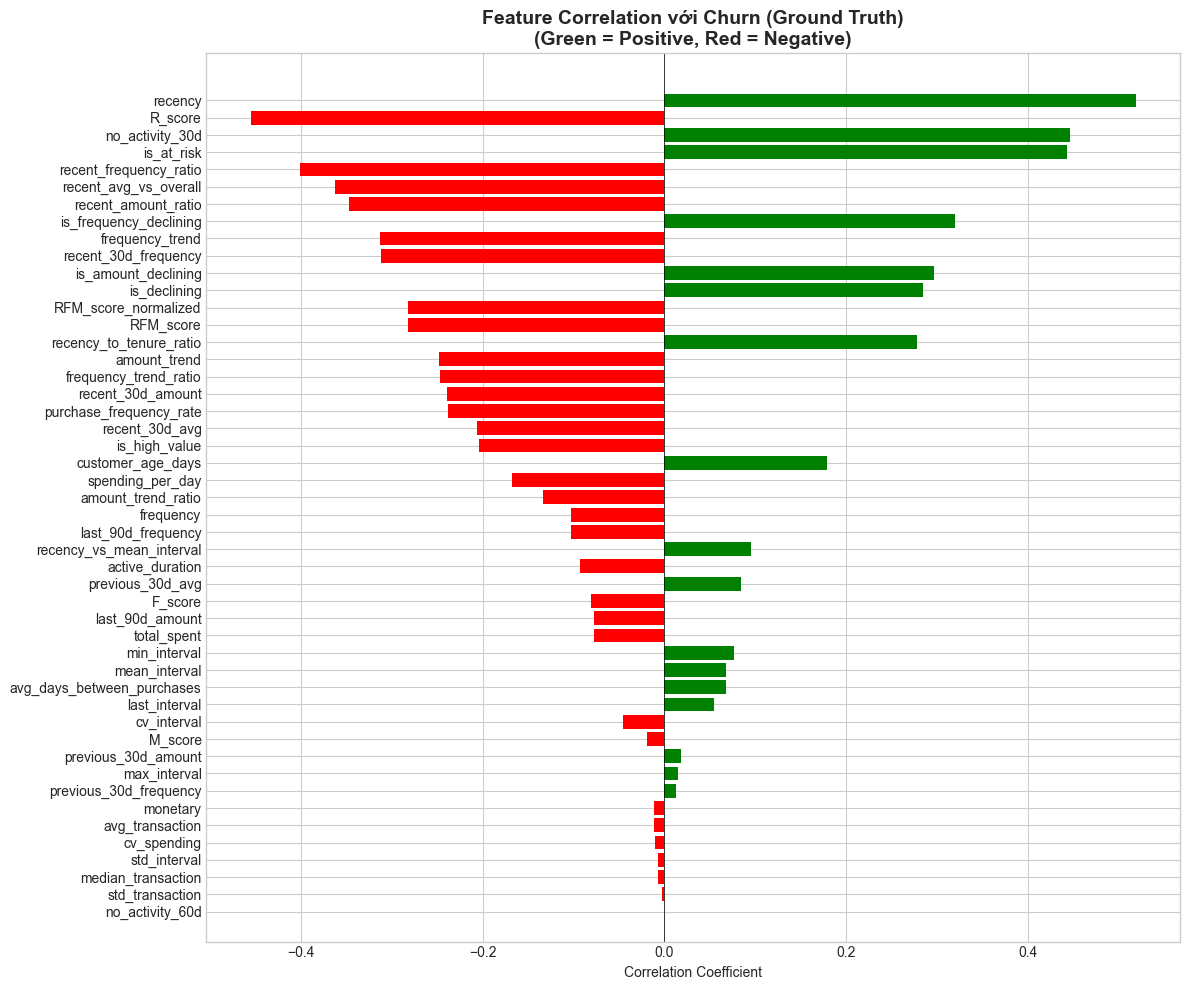

In [28]:
feature_correlation = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'correlation_with_churn': [X_train[col].corr(y_train) for col in FEATURE_COLUMNS]
}).sort_values('correlation_with_churn', key=abs, ascending=False)

# Visualize top correlations
fig, ax = plt.subplots(figsize=(12, 10))
colors = ['green' if x > 0 else 'red' for x in feature_correlation['correlation_with_churn'].values]
bars = ax.barh(range(len(feature_correlation)), feature_correlation['correlation_with_churn'].values, color=colors)
ax.set_yticks(range(len(feature_correlation)))
ax.set_yticklabels(feature_correlation['feature'].values)
ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Correlation Coefficient')
ax.set_title('Feature Correlation với Churn (Ground Truth)\n(Green = Positive, Red = Negative)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [29]:
# =============================================================================
# 🤖 TRAIN CLASSIFICATION MODELS & EVALUATE ON TEST SET
# =============================================================================

from sklearn.metrics import brier_score_loss, average_precision_score

print("="*80)
print("🤖 TRAINING CLASSIFICATION MODELS")
print("="*80)
print(f"\n📊 Training set: {X_train_scaled.shape[0]:,} samples")
print(f"📊 Test set: {X_test_scaled.shape[0]:,} samples")

# Define models
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, max_iter=1000, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, random_state=42, 
        class_weight='balanced', n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
    )
}

# Train models và đánh giá trên TEST SET
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    
    model.fit(X_train_scaled, y_train)
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    test_auc = roc_auc_score(y_test, y_test_proba)
    test_pr_auc = average_precision_score(y_test, y_test_proba)
    test_brier = brier_score_loss(y_test, y_test_proba)
    
    print(f"\n{name} Results (TEST SET):")
    print(f"   ROC-AUC:     {test_auc:.4f}")
    print(f"   PR-AUC:      {test_pr_auc:.4f}")
    print(f"   Brier Score: {test_brier:.4f}")
    
    print("\n   Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    results[name] = {
        'model': model,
        'test_auc': test_auc,
        'test_pr_auc': test_pr_auc,
        'test_brier': test_brier,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba
    }

# Best model by TEST PR-AUC
best_model_name = max(results, key=lambda x: results[x]['test_pr_auc'])
print(f"\nBest Model by PR-AUC: {best_model_name} (PR-AUC: {results[best_model_name]['test_pr_auc']:.4f})")

🤖 TRAINING CLASSIFICATION MODELS

📊 Training set: 7,767 samples
📊 Test set: 1,574 samples

Training Logistic Regression...

Logistic Regression Results (TEST SET):
   ROC-AUC:     0.8432
   PR-AUC:      0.7460
   Brier Score: 0.1547

   Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1109
           1       0.64      0.75      0.69       465

    accuracy                           0.80      1574
   macro avg       0.76      0.79      0.77      1574
weighted avg       0.81      0.80      0.80      1574


Training Random Forest...

Random Forest Results (TEST SET):
   ROC-AUC:     0.8447
   PR-AUC:      0.7380
   Brier Score: 0.1407

   Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1109
           1       0.69      0.65      0.67       465

    accuracy                           0.81      1574
   macro avg       0.77      0.76    

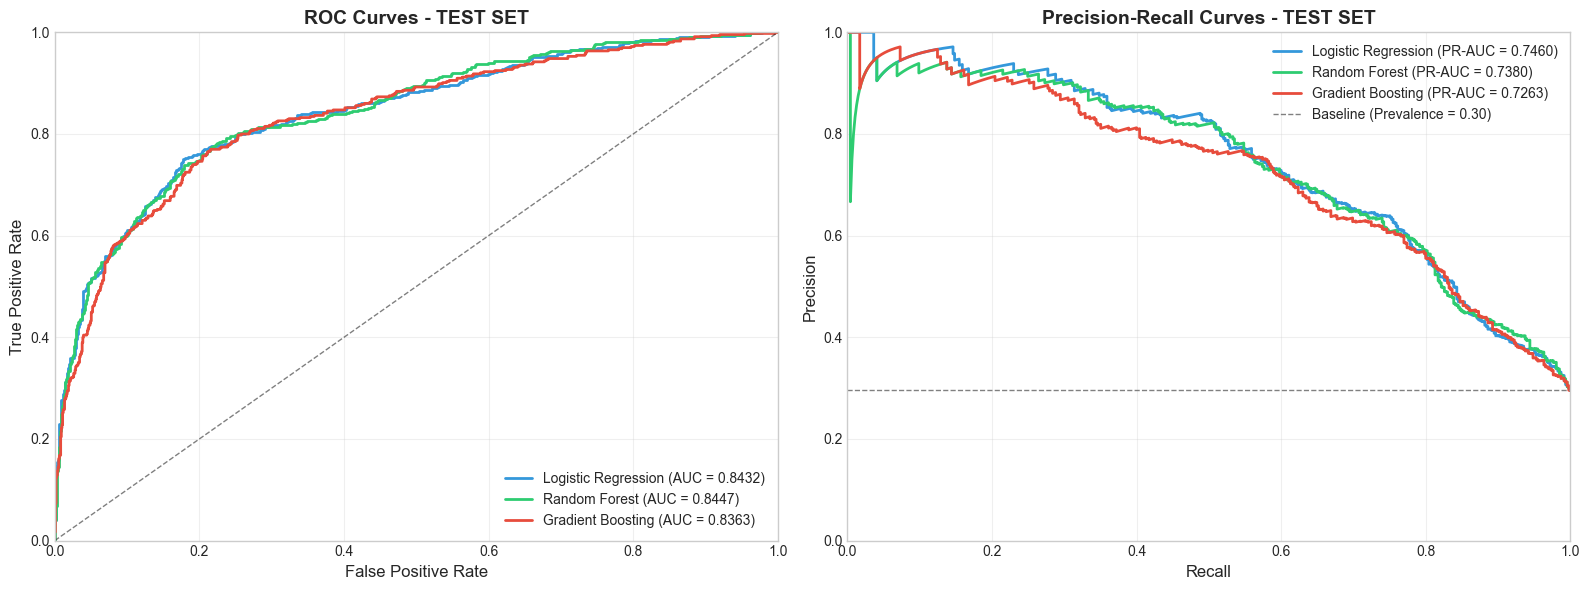


MODEL COMPARISON SUMMARY
              Model  ROC-AUC   PR-AUC  Brier Score
Logistic Regression 0.843242 0.745974     0.154699
      Random Forest 0.844661 0.737993     0.140749
  Gradient Boosting 0.836329 0.726260     0.137529

Best Model by PR-AUC: Logistic Regression


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

model_colors = {
    'Logistic Regression': '#3498db',
    'Random Forest': '#2ecc71', 
    'Gradient Boosting': '#e74c3c'
}

# 1. ROC Curves 
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_test_proba'])
    axes[0].plot(fpr, tpr, linewidth=2, color=model_colors[name],
                 label=f'{name} (AUC = {result["test_auc"]:.4f})')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
axes[0].set_title('ROC Curves - TEST SET', fontweight='bold', fontsize=14)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# 2. Precision-Recall Curves 
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_test_proba'])
    axes[1].plot(recall, precision, linewidth=2, color=model_colors[name],
                 label=f'{name} (PR-AUC = {result["test_pr_auc"]:.4f})')

# Baseline (prevalence)
baseline = y_test.mean()
axes[1].axhline(baseline, color='gray', linestyle='--', linewidth=1, 
                label=f'Baseline (Prevalence = {baseline:.2f})')

axes[1].set_title('Precision-Recall Curves - TEST SET', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Summary Table 
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
summary_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [results[m]['test_auc'] for m in results],
    'PR-AUC': [results[m]['test_pr_auc'] for m in results],
    'Brier Score': [results[m]['test_brier'] for m in results]
}).sort_values('PR-AUC', ascending=False)
print(summary_df.to_string(index=False))

print(f"\nBest Model by PR-AUC: {best_model_name}")

In [31]:
# =============================================================================
# 🎯 MODEL CALIBRATION - Platt Scaling (Evaluate on TEST SET)
# =============================================================================

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

print("="*80)
print(f"CALIBRATING BEST MODEL: {best_model_name}")
print("="*80)


best_model = results[best_model_name]['model']

# Calibrate model sử dụng Platt Scaling (Logistic/Sigmoid)
calibrated_model = CalibratedClassifierCV(best_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train_scaled, y_train)


y_test_proba_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]

brier_before = brier_score_loss(y_test, results[best_model_name]['y_test_proba'])
brier_after = brier_score_loss(y_test, y_test_proba_calibrated)

pr_auc_before = results[best_model_name]['test_pr_auc']
pr_auc_after = average_precision_score(y_test, y_test_proba_calibrated)

roc_auc_before = results[best_model_name]['test_auc']
roc_auc_after = roc_auc_score(y_test, y_test_proba_calibrated)

print(f"\nComparison: Before vs After Calibration on TEST SET (Platt Scaling)")
print("-"*60)
print(f"{'Metric':<20} {'Before':>15} {'After':>15} {'Change':>15}")
print("-"*60)
print(f"{'Brier Score':<20} {brier_before:>15.4f} {brier_after:>15.4f} {brier_after - brier_before:>+15.4f}")
print(f"{'PR-AUC':<20} {pr_auc_before:>15.4f} {pr_auc_after:>15.4f} {pr_auc_after - pr_auc_before:>+15.4f}")
print(f"{'ROC-AUC':<20} {roc_auc_before:>15.4f} {roc_auc_after:>15.4f} {roc_auc_after - roc_auc_before:>+15.4f}")
print("-"*60)

improvement = ((brier_before - brier_after) / brier_before) * 100
print(f"\n💡 Brier Score improvement: {improvement:.2f}% {'✅ Better' if brier_after < brier_before else '❌ Worse'}")

# Lưu calibrated model
results[best_model_name]['calibrated_model'] = calibrated_model
results[best_model_name]['y_test_proba_calibrated'] = y_test_proba_calibrated
results[best_model_name]['brier_before'] = brier_before
results[best_model_name]['brier_after'] = brier_after

CALIBRATING BEST MODEL: Logistic Regression

Comparison: Before vs After Calibration on TEST SET (Platt Scaling)
------------------------------------------------------------
Metric                        Before           After          Change
------------------------------------------------------------
Brier Score                   0.1547          0.1329         -0.0218
PR-AUC                        0.7460          0.7460         +0.0000
ROC-AUC                       0.8432          0.8432         +0.0000
------------------------------------------------------------

💡 Brier Score improvement: 14.08% ✅ Better


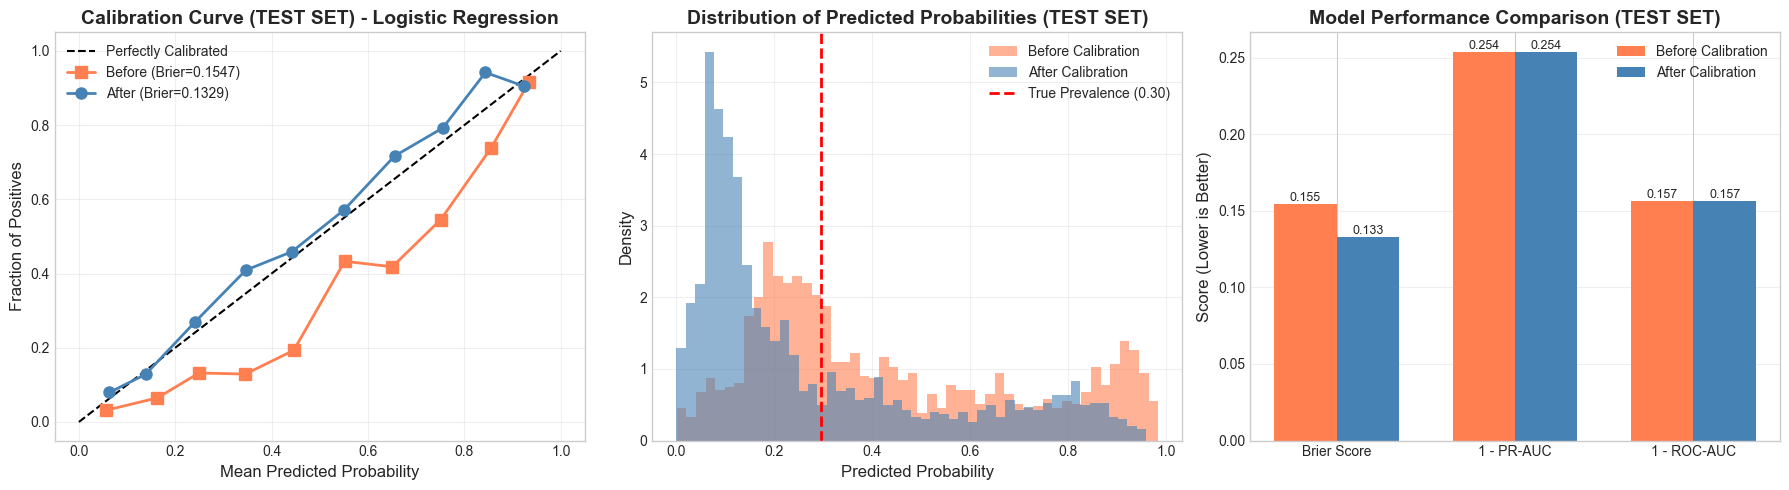


💡 Calibration Insights:
   - Calibration giúp xác suất dự đoán gần với xác suất thực tế hơn
   - Brier Score thấp hơn = model được calibrate tốt hơn
   - Đường Calibration Curve càng gần đường chéo = càng tốt


In [32]:
# =============================================================================
# 📊 VISUALIZE CALIBRATION - Reliability Diagram (TEST SET)
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Calibration Curve (Reliability Diagram) - TEST SET
# Before calibration
prob_true_before, prob_pred_before = calibration_curve(
    y_test, results[best_model_name]['y_test_proba'], n_bins=10
)
# After calibration
prob_true_after, prob_pred_after = calibration_curve(
    y_test, y_test_proba_calibrated, n_bins=10
)

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].plot(prob_pred_before, prob_true_before, 's-', color='coral', 
             linewidth=2, markersize=8, label=f'Before (Brier={brier_before:.4f})')
axes[0].plot(prob_pred_after, prob_true_after, 'o-', color='steelblue',
             linewidth=2, markersize=8, label=f'After (Brier={brier_after:.4f})')
axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0].set_ylabel('Fraction of Positives', fontsize=12)
axes[0].set_title(f'Calibration Curve (TEST SET) - {best_model_name}', fontweight='bold', fontsize=14)
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.3)

# 2. Distribution of Predicted Probabilities - TEST SET
axes[1].hist(results[best_model_name]['y_test_proba'], bins=50, alpha=0.6, 
             color='coral', label='Before Calibration', density=True)
axes[1].hist(y_test_proba_calibrated, bins=50, alpha=0.6, 
             color='steelblue', label='After Calibration', density=True)
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'True Prevalence ({y_test.mean():.2f})')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Distribution of Predicted Probabilities (TEST SET)', fontweight='bold', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Brier Score Comparison Bar Chart - TEST SET
metrics_before = [brier_before, 1-pr_auc_before, 1-roc_auc_before]
metrics_after = [brier_after, 1-pr_auc_after, 1-roc_auc_after]
metric_names = ['Brier Score', '1 - PR-AUC', '1 - ROC-AUC']

x = np.arange(len(metric_names))
width = 0.35

bars1 = axes[2].bar(x - width/2, metrics_before, width, label='Before Calibration', color='coral')
bars2 = axes[2].bar(x + width/2, metrics_after, width, label='After Calibration', color='steelblue')

axes[2].set_ylabel('Score (Lower is Better)', fontsize=12)
axes[2].set_title('Model Performance Comparison (TEST SET)', fontweight='bold', fontsize=14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(metric_names)
axes[2].legend()
axes[2].grid(alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

📊 Top 15 Feature Importances (Logistic Regression):
                   feature  coefficient  abs_importance
                   recency     0.892032        0.892032
      recent_30d_frequency    -0.635533        0.635533
           frequency_trend    -0.398296        0.398296
     frequency_trend_ratio     0.302075        0.302075
         customer_age_days     0.278189        0.278189
        amount_trend_ratio    -0.258199        0.258199
    previous_30d_frequency    -0.231999        0.231999
              max_interval    -0.231037        0.231037
                   F_score     0.229746        0.229746
       recent_amount_ratio     0.206800        0.206800
avg_days_between_purchases     0.194061        0.194061
             mean_interval     0.194060        0.194060
           active_duration    -0.188156        0.188156
   recency_to_tenure_ratio     0.186613        0.186613
     recent_avg_vs_overall    -0.186270        0.186270


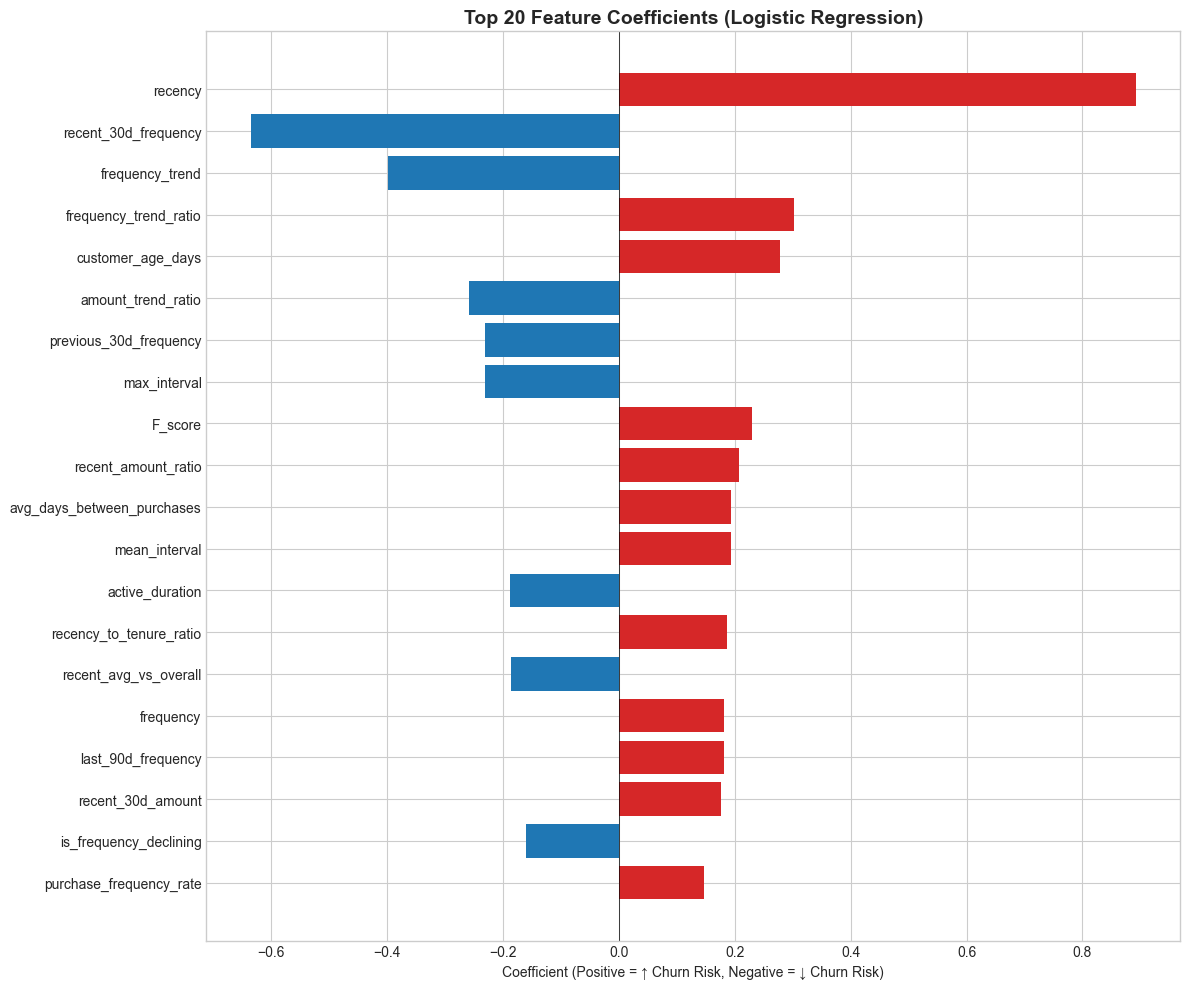


💡 Key Insights:
   🔴 Positive coefficients: Tăng xác suất churn
   🔵 Negative coefficients: Giảm xác suất churn
   - recency cao → tăng churn risk
   - frequency, monetary cao → giảm churn risk


In [33]:
# =============================================================================
# 📊 FEATURE IMPORTANCE (Logistic Regression)
# =============================================================================

# Get feature importance from Logistic Regression (using absolute coefficients)
lr_model = results['Logistic Regression']['model']
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'coefficient': lr_model.coef_[0],
    'abs_importance': np.abs(lr_model.coef_[0])
}).sort_values('abs_importance', ascending=False)

print("📊 Top 15 Feature Importances (Logistic Regression):")
print(feature_importance[['feature', 'coefficient', 'abs_importance']].head(15).to_string(index=False))

# Visualize - Show coefficients with direction (positive = increases churn probability)
fig, ax = plt.subplots(figsize=(12, 10))
top_features = feature_importance.head(20)

# Color by coefficient sign: Red = positive (increases churn), Blue = negative (decreases churn)
colors = ['#d62728' if c > 0 else '#1f77b4' for c in top_features['coefficient'].values]

ax.barh(range(len(top_features)), top_features['coefficient'].values, color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Coefficient (Positive = ↑ Churn Risk, Negative = ↓ Churn Risk)')
ax.set_title('Top 20 Feature Coefficients (Logistic Regression)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print("   🔴 Positive coefficients: Tăng xác suất churn")
print("   🔵 Negative coefficients: Giảm xác suất churn")
print("   - recency cao → tăng churn risk")
print("   - frequency, monetary cao → giảm churn risk")

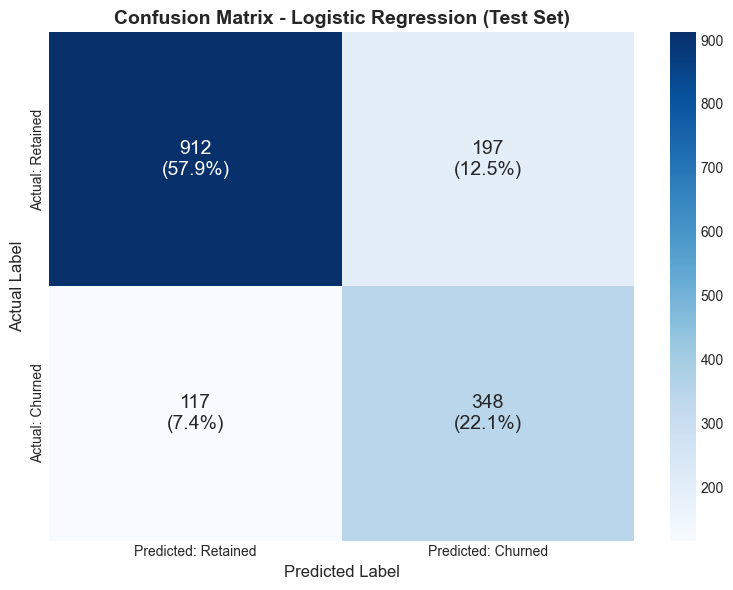


📊 Overall Accuracy: 80.05%


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_with_ground_truth = test_features.copy()
test_with_ground_truth['y_true'] = y_test.values
test_with_ground_truth['churn_predicted'] = best_model.predict(X_test_scaled)

cm = confusion_matrix(test_with_ground_truth['y_true'], test_with_ground_truth['churn_predicted'])
cm_pct = cm / cm.sum() * 100  # Tính phần trăm

fig, ax = plt.subplots(figsize=(8, 6))

labels = np.array([[f'{cm[i,j]:,}\n({cm_pct[i,j]:.1f}%)' for j in range(2)] for i in range(2)])

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax,
            xticklabels=['Predicted: Retained', 'Predicted: Churned'],
            yticklabels=['Actual: Retained', 'Actual: Churned'],
            annot_kws={'size': 14})

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_model_name} (Test Set)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

📊 CHURN RISK SEGMENTATION (Test Set)
                    n_customers  actual_churn_rate  avg_predicted_prob  avg_total_spent  avg_transaction_value
churn_risk_segment                                                                                            
Low Risk                    698           0.093123            0.190666       690.103811              60.379792
Medium Risk                 331           0.157100            0.389505       494.783172              55.977655
High Risk                   207           0.425121            0.604037       355.697391              59.606953
Critical Risk               338           0.769231            0.864870       343.272426              59.681966


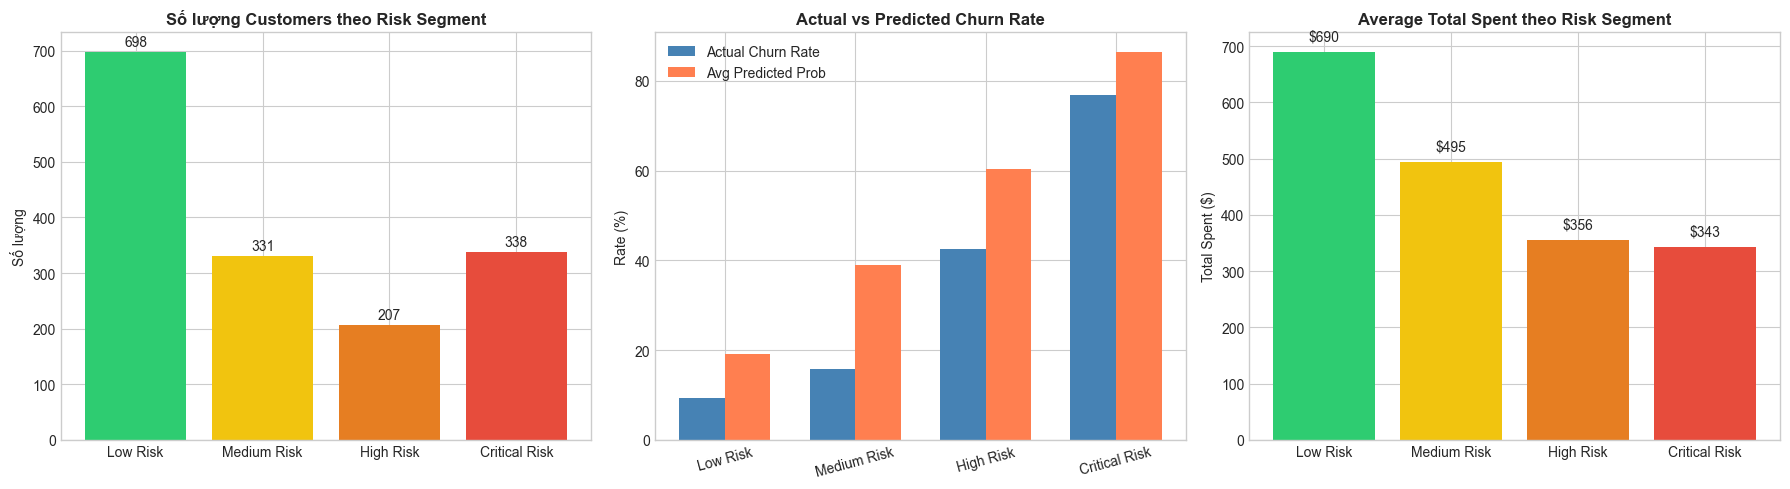

In [51]:
# =============================================================================
# 📊 CHURN RISK SEGMENTATION - TEST SET
# =============================================================================

# Thêm churn probability nếu chưa có
if 'churn_probability' not in test_with_ground_truth.columns:
    test_with_ground_truth['churn_probability'] = best_model.predict_proba(X_test_scaled)[:, 1]

# Segment customers by churn risk
def segment_by_churn_risk(prob):
    if prob < 0.3:
        return 'Low Risk'
    elif prob < 0.5:
        return 'Medium Risk'
    elif prob < 0.7:
        return 'High Risk'
    else:
        return 'Critical Risk'

test_with_ground_truth['churn_risk_segment'] = test_with_ground_truth['churn_probability'].apply(segment_by_churn_risk)

# Summary by segment
risk_summary = test_with_ground_truth.groupby('churn_risk_segment').agg({
    'customer_id': 'count',
    'y_true': 'mean',
    'churn_probability': 'mean',
    'total_spent': 'mean',
    'monetary': 'mean'
}).rename(columns={
    'customer_id': 'n_customers',
    'y_true': 'actual_churn_rate',
    'churn_probability': 'avg_predicted_prob',
    'total_spent': 'avg_total_spent',
    'monetary': 'avg_transaction_value'
})

# Order by risk level
risk_order = ['Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk']
risk_summary = risk_summary.reindex(risk_order).dropna()
available_segments = list(risk_summary.index)

print("="*80)
print("📊 CHURN RISK SEGMENTATION (Test Set)")
print("="*80)
print(risk_summary.to_string())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colors mapping
all_colors = {'Low Risk': '#2ecc71', 'Medium Risk': '#f1c40f', 'High Risk': '#e67e22', 'Critical Risk': '#e74c3c'}
colors = [all_colors[s] for s in available_segments]

# Customer count by segment
axes[0].bar(available_segments, risk_summary['n_customers'], color=colors)
axes[0].set_title('Số lượng Customers theo Risk Segment', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Số lượng')
for i, s in enumerate(available_segments):
    v = risk_summary.loc[s, 'n_customers']
    axes[0].text(i, v + 10, f'{v:,.0f}', ha='center', fontsize=10)

# Actual churn rate vs predicted
x = np.arange(len(available_segments))
width = 0.35
axes[1].bar(x - width/2, risk_summary['actual_churn_rate']*100, width, label='Actual Churn Rate', color='steelblue')
axes[1].bar(x + width/2, risk_summary['avg_predicted_prob']*100, width, label='Avg Predicted Prob', color='coral')
axes[1].set_xticks(x)
axes[1].set_xticklabels(available_segments, rotation=15)
axes[1].set_title('Actual vs Predicted Churn Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Rate (%)')
axes[1].legend()

# Average value by segment
axes[2].bar(available_segments, risk_summary['avg_total_spent'], color=colors)
axes[2].set_title('Average Total Spent theo Risk Segment', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Total Spent ($)')
for i, s in enumerate(available_segments):
    v = risk_summary.loc[s, 'avg_total_spent']
    axes[2].text(i, v + 20, f'${v:,.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---
# PART 3: Churn via BG-NBD

**Outputs**: P(alive), Expected # transactions in next period

In [38]:
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix

OBSERVATION_DATE_BGF = transactions['transaction_date'].max()
print(f"\nObservation Date: {OBSERVATION_DATE_BGF.strftime('%d/%m/%Y')}")

rfm_bgf = summary_data_from_transaction_data(
    transactions,
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    monetary_value_col='amount',
    observation_period_end=OBSERVATION_DATE_BGF
)


print(rfm_bgf.head(10))
print(f"\nShape: {rfm_bgf.shape}")


bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm_bgf['frequency'], rfm_bgf['recency'], rfm_bgf['T'])


Observation Date: 31/12/2025
             frequency  recency      T  monetary_value
customer_id                                           
C00000            11.0    112.0  112.0       93.370000
C00001            17.0    278.0  289.0       68.373529
C00002             9.0     37.0  133.0       86.307778
C00003             3.0     45.0   88.0       19.393333
C00004            17.0     98.0  206.0      109.965882
C00005             6.0     46.0   48.0       29.576667
C00006             2.0     82.0  118.0       32.875000
C00007             4.0     50.0  142.0       88.840000
C00008            12.0    176.0  237.0       56.019167
C00009            17.0    163.0  358.0       95.345294

Shape: (2892, 4)



Observation Date: 31/12/2025
             frequency  recency      T  monetary_value
customer_id                                           
C00000            11.0    112.0  112.0       93.370000
C00001            17.0    278.0  289.0       68.373529
C00002             9.0     37.0  133.0       86.307778
C00003             3.0     45.0   88.0       19.393333
C00004            17.0     98.0  206.0      109.965882
C00005             6.0     46.0   48.0       29.576667
C00006             2.0     82.0  118.0       32.875000
C00007             4.0     50.0  142.0       88.840000
C00008            12.0    176.0  237.0       56.019167
C00009            17.0    163.0  358.0       95.345294

Shape: (2892, 4)


<lifetimes.BetaGeoFitter: fitted with 2892 subjects, a: 0.28, alpha: 9.62, b: 2.01, r: 1.35>

In [40]:
rfm_bgf['p_alive'] = bgf.conditional_probability_alive(
    rfm_bgf['frequency'], 
    rfm_bgf['recency'], 
    rfm_bgf['T']
)

# Tính expected purchases trong 30, 60, 90 ngày tới
for days in [30, 60, 90]:
    rfm_bgf[f'expected_purchases_{days}d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
        days,
        rfm_bgf['frequency'],
        rfm_bgf['recency'],
        rfm_bgf['T']
    )

print("\n📊 Sample Predictions (Top 10):")
print(rfm_bgf[['frequency', 'recency', 'T', 'p_alive', 
               'expected_purchases_30d', 'expected_purchases_60d', 'expected_purchases_90d']].head(10))

print("\nP(Alive) Statistics:")
display(rfm_bgf['p_alive'].describe())

# Phân loại risk level dựa trên P(alive)
rfm_bgf['risk_level'] = pd.cut(rfm_bgf['p_alive'], 
                                bins=[0, 0.3, 0.5, 0.7, 1.0],
                                labels=['Critical Risk', 'High Risk', 'Medium Risk', 'Low Risk'])

print("\n Risk Distribution:")
print(rfm_bgf['risk_level'].value_counts().sort_index())


📊 Sample Predictions (Top 10):
             frequency  recency      T   p_alive  expected_purchases_30d  \
customer_id                                                                
C00000            11.0    112.0  112.0  0.977384                2.884475   
C00001            17.0    278.0  289.0  0.970194                1.764507   
C00002             9.0     37.0  133.0  0.000339                0.000718   
C00003             3.0     45.0   88.0  0.535590                0.688525   
C00004            17.0     98.0  206.0  0.000188                0.000471   
C00005             6.0     46.0   48.0  0.951103                3.420430   
C00006             2.0     82.0  118.0  0.780946                0.596411   
C00007             4.0     50.0  142.0  0.108884                0.112303   
C00008            12.0    176.0  237.0  0.513207                0.819965   
C00009            17.0    163.0  358.0  0.000061                0.000091   

             expected_purchases_60d  expected_purchases

count    2.892000e+03
mean     5.092296e-01
std      4.340941e-01
min      3.085812e-18
25%      1.283362e-02
50%      5.865970e-01
75%      9.642929e-01
max      1.000000e+00
Name: p_alive, dtype: float64


📊 Sample Predictions (Top 10):
             frequency  recency      T   p_alive  expected_purchases_30d  \
customer_id                                                                
C00000            11.0    112.0  112.0  0.977384                2.884475   
C00001            17.0    278.0  289.0  0.970194                1.764507   
C00002             9.0     37.0  133.0  0.000339                0.000718   
C00003             3.0     45.0   88.0  0.535590                0.688525   
C00004            17.0     98.0  206.0  0.000188                0.000471   
C00005             6.0     46.0   48.0  0.951103                3.420430   
C00006             2.0     82.0  118.0  0.780946                0.596411   
C00007             4.0     50.0  142.0  0.108884                0.112303   
C00008            12.0    176.0  237.0  0.513207                0.819965   
C00009            17.0    163.0  358.0  0.000061                0.000091   

             expected_purchases_60d  expected_purchases

count    2.892000e+03
mean     5.092296e-01
std      4.340941e-01
min      3.085812e-18
25%      1.283362e-02
50%      5.865970e-01
75%      9.642929e-01
max      1.000000e+00
Name: p_alive, dtype: float64


 Risk Distribution:
risk_level
Critical Risk    1249
High Risk         140
Medium Risk       134
Low Risk         1369
Name: count, dtype: int64


In [43]:
rfm_bgf

,frequency,recency,T,monetary_value,p_alive,expected_purchases_30d,expected_purchases_60d,expected_purchases_90d,risk_level
customer_id,,,,,,,,,
C00000,11.0,112.0,112.0,93.370000,0.977384,2.884475,5.612913,8.217928,Low Risk
C00001,17.0,278.0,289.0,68.373529,0.970194,1.764507,3.484619,5.165051,Low Risk
C00002,9.0,37.0,133.0,86.307778,0.000339,0.000718,0.001402,0.002058,Critical Risk
C00003,3.0,45.0,88.0,19.393333,0.535590,0.688525,1.332634,1.943067,Medium Risk
C00004,17.0,98.0,206.0,109.965882,0.000188,0.000471,0.000925,0.001366,Critical Risk
...,...,...,...,...,...,...,...,...,...
C02995,13.0,69.0,69.0,33.085385,0.980550,5.121958,9.858931,14.316353,Low Risk
C02996,8.0,161.0,194.0,75.925000,0.861219,1.163370,2.285612,3.372667,Low Risk
C02997,13.0,54.0,59.0,35.300769,0.944517,5.618709,10.772673,15.599166,Low Risk


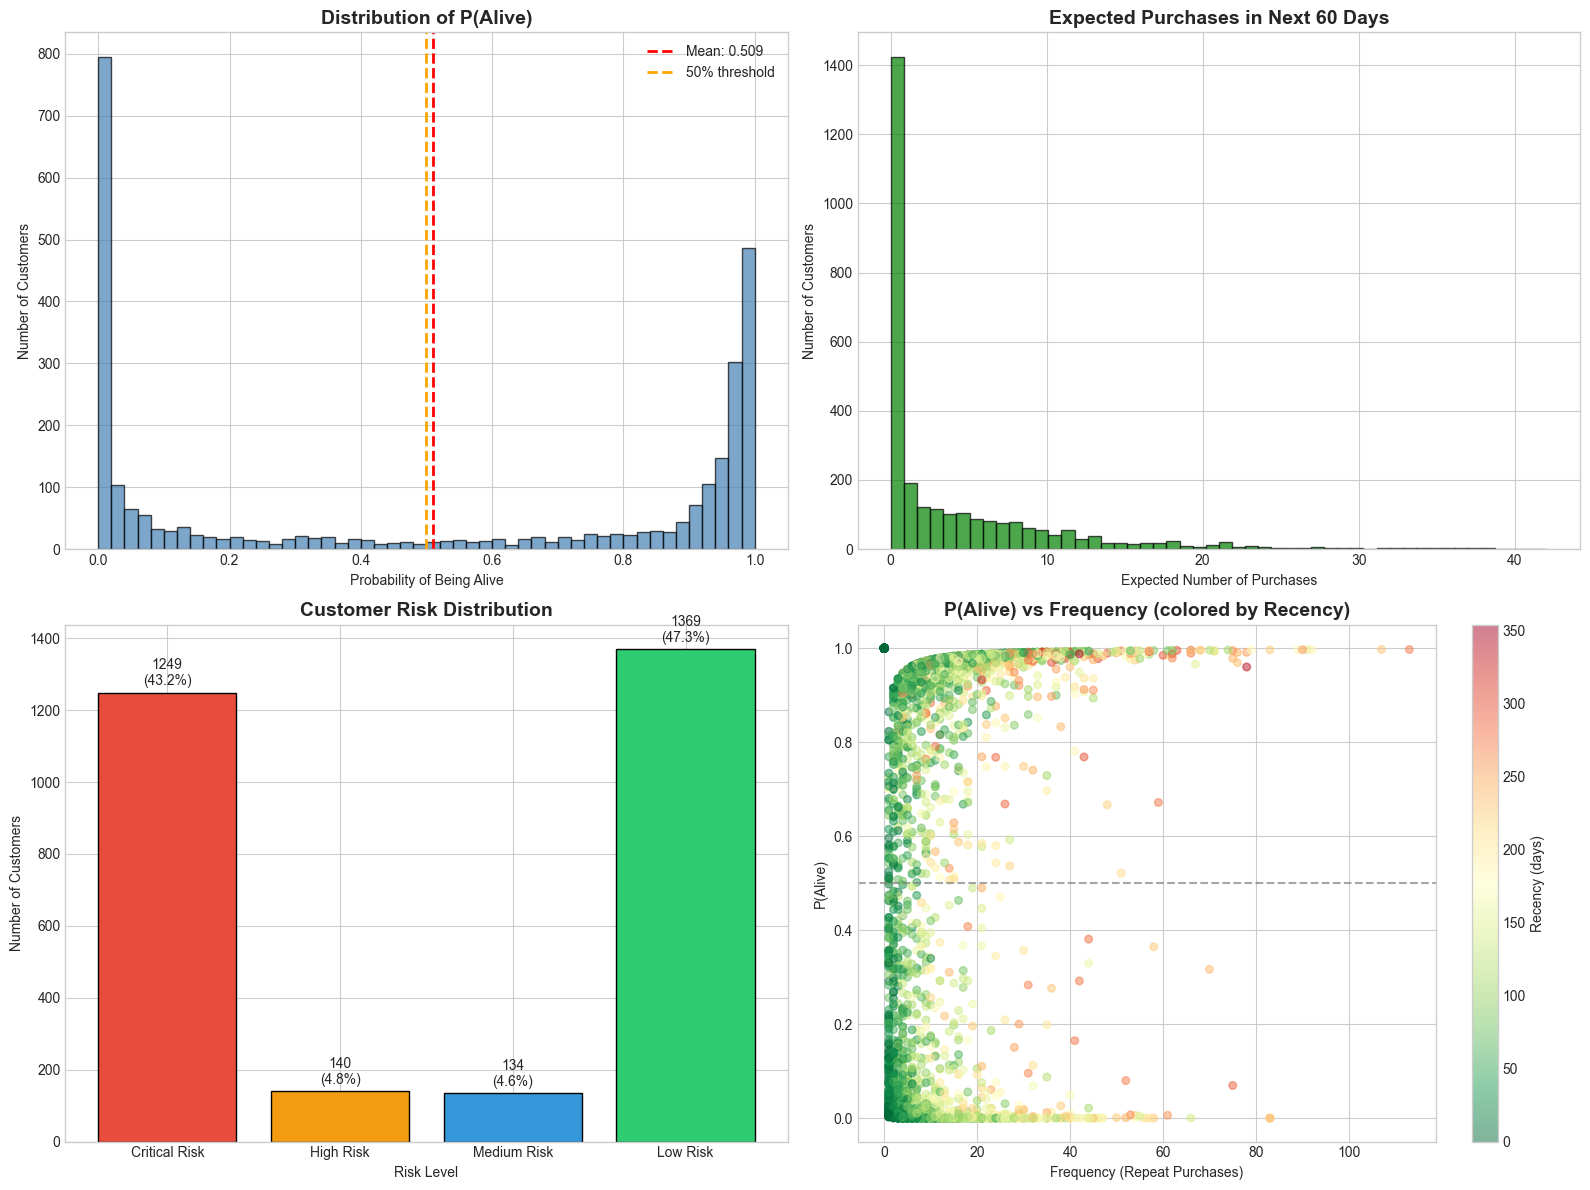

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. P(alive) distribution
axes[0, 0].hist(rfm_bgf['p_alive'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Distribution of P(Alive)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Probability of Being Alive')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(rfm_bgf['p_alive'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {rfm_bgf["p_alive"].mean():.3f}')
axes[0, 0].axvline(0.5, color='orange', linestyle='--', linewidth=2, label='50% threshold')
axes[0, 0].legend()

# 2. Expected purchases distribution
axes[0, 1].hist(rfm_bgf['expected_purchases_60d'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Expected Purchases in Next 60 Days', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Expected Number of Purchases')
axes[0, 1].set_ylabel('Number of Customers')

# 3. Risk distribution
risk_counts = rfm_bgf['risk_level'].value_counts().sort_index()
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
axes[1, 0].bar(risk_counts.index, risk_counts.values, color=colors, edgecolor='black')
axes[1, 0].set_title('Customer Risk Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Risk Level')
axes[1, 0].set_ylabel('Number of Customers')
for i, v in enumerate(risk_counts.values):
    axes[1, 0].text(i, v + 20, f'{v}\n({v/len(rfm_bgf)*100:.1f}%)', ha='center', fontsize=10)

# 4. P(alive) vs Frequency
scatter = axes[1, 1].scatter(rfm_bgf['frequency'], rfm_bgf['p_alive'], 
                              c=rfm_bgf['recency'], cmap='RdYlGn_r', alpha=0.5, s=30)
axes[1, 1].set_title('P(Alive) vs Frequency (colored by Recency)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Frequency (Repeat Purchases)')
axes[1, 1].set_ylabel('P(Alive)')
axes[1, 1].axhline(0.5, color='gray', linestyle='--', alpha=0.7)
plt.colorbar(scatter, ax=axes[1, 1], label='Recency (days)')

plt.tight_layout()
plt.show()

In [44]:
"""
Hiển thị P(Alive) cho 2 khách hàng thực:
- QUÁN KHỨ: P(Alive) thay đổi theo thời gian với mỗi giao dịch
- TƯƠNG LAI: P(Alive) decay nếu không có giao dịch mới
- GIAO DỊCH: Đường gạch đứng vertical line đánh dấu thời điểm mua hàng
"""

# Chọn 2 khách hàng đại diện
# High-Frequency: 15-25 repeat purchases
high_freq_candidates = rfm_bgf[(rfm_bgf['frequency'] >= 15) & (rfm_bgf['frequency'] <= 30)]
if len(high_freq_candidates) > 0:
    customer_high_id = high_freq_candidates.sample(1, random_state=42).index[0]
else:
    customer_high_id = rfm_bgf.nlargest(1, 'frequency').index[0]
customer_high = rfm_bgf.loc[customer_high_id]

# Low-Frequency: 2-5 repeat purchases
low_freq_candidates = rfm_bgf[(rfm_bgf['frequency'] >= 2) & (rfm_bgf['frequency'] <= 5)]
if len(low_freq_candidates) > 0:
    customer_low_id = low_freq_candidates.sample(1, random_state=123).index[0]
else:
    customer_low_id = rfm_bgf[rfm_bgf['frequency'] >= 1].nsmallest(1, 'frequency').index[0]
customer_low = rfm_bgf.loc[customer_low_id]

print(f"\nHigh-Frequency Customer: {customer_high_id}")
print(f"   Frequency: {customer_high['frequency']:.0f} | P(Alive): {customer_high['p_alive']:.1%}")

print(f"\nLow-Frequency Customer: {customer_low_id}")
print(f"   Frequency: {customer_low['frequency']:.0f} | P(Alive): {customer_low['p_alive']:.1%}")


High-Frequency Customer: C01314
   Frequency: 15 | P(Alive): 62.9%

Low-Frequency Customer: C02558
   Frequency: 3 | P(Alive): 31.8%


In [46]:
# =============================================================================
# 3.5 TÍNH P(ALIVE) TIMELINE
# =============================================================================

def calculate_palive_timeline(bgf_model, customer_id, transactions_df, future_days=60):
    """
    Tính P(Alive) theo timeline thực tế của khách hàng.
    """
    cust_tx = transactions_df[transactions_df['customer_id'] == customer_id].copy()
    cust_tx = cust_tx.sort_values('transaction_date')
    
    if len(cust_tx) == 0:
        return None, None, None, None
    
    first_date = cust_tx['transaction_date'].min()
    observation_date = transactions_df['transaction_date'].max()
    
    cust_tx['days_since_first'] = (cust_tx['transaction_date'] - first_date).dt.days
    tx_days_list = sorted(cust_tx['days_since_first'].tolist())
    
    total_T = (observation_date - first_date).days
    total_days = total_T + future_days
    
    timeline_days = []
    palive_values = []
    
    for day in range(0, total_days + 1):
        repeat_purchases = sum(1 for d in tx_days_list[1:] if d <= day)
        frequency = repeat_purchases
        
        purchases_until_now = [d for d in tx_days_list if d <= day]
        recency = purchases_until_now[-1] if len(purchases_until_now) > 1 else 0
        T = day
        
        if frequency == 0 or T == 0:
            p_alive = 1.0
        else:
            p_alive = float(bgf_model.conditional_probability_alive(frequency, recency, T))
        
        timeline_days.append(day)
        palive_values.append(p_alive)
    
    return np.array(timeline_days), np.array(palive_values), tx_days_list, total_T

# Tính timeline cho 2 khách hàng
future_days = 60

timeline_high, palive_high, tx_days_high, T_high = calculate_palive_timeline(
    bgf, customer_high_id, transactions, future_days
)
timeline_low, palive_low, tx_days_low, T_low = calculate_palive_timeline(
    bgf, customer_low_id, transactions, future_days
)

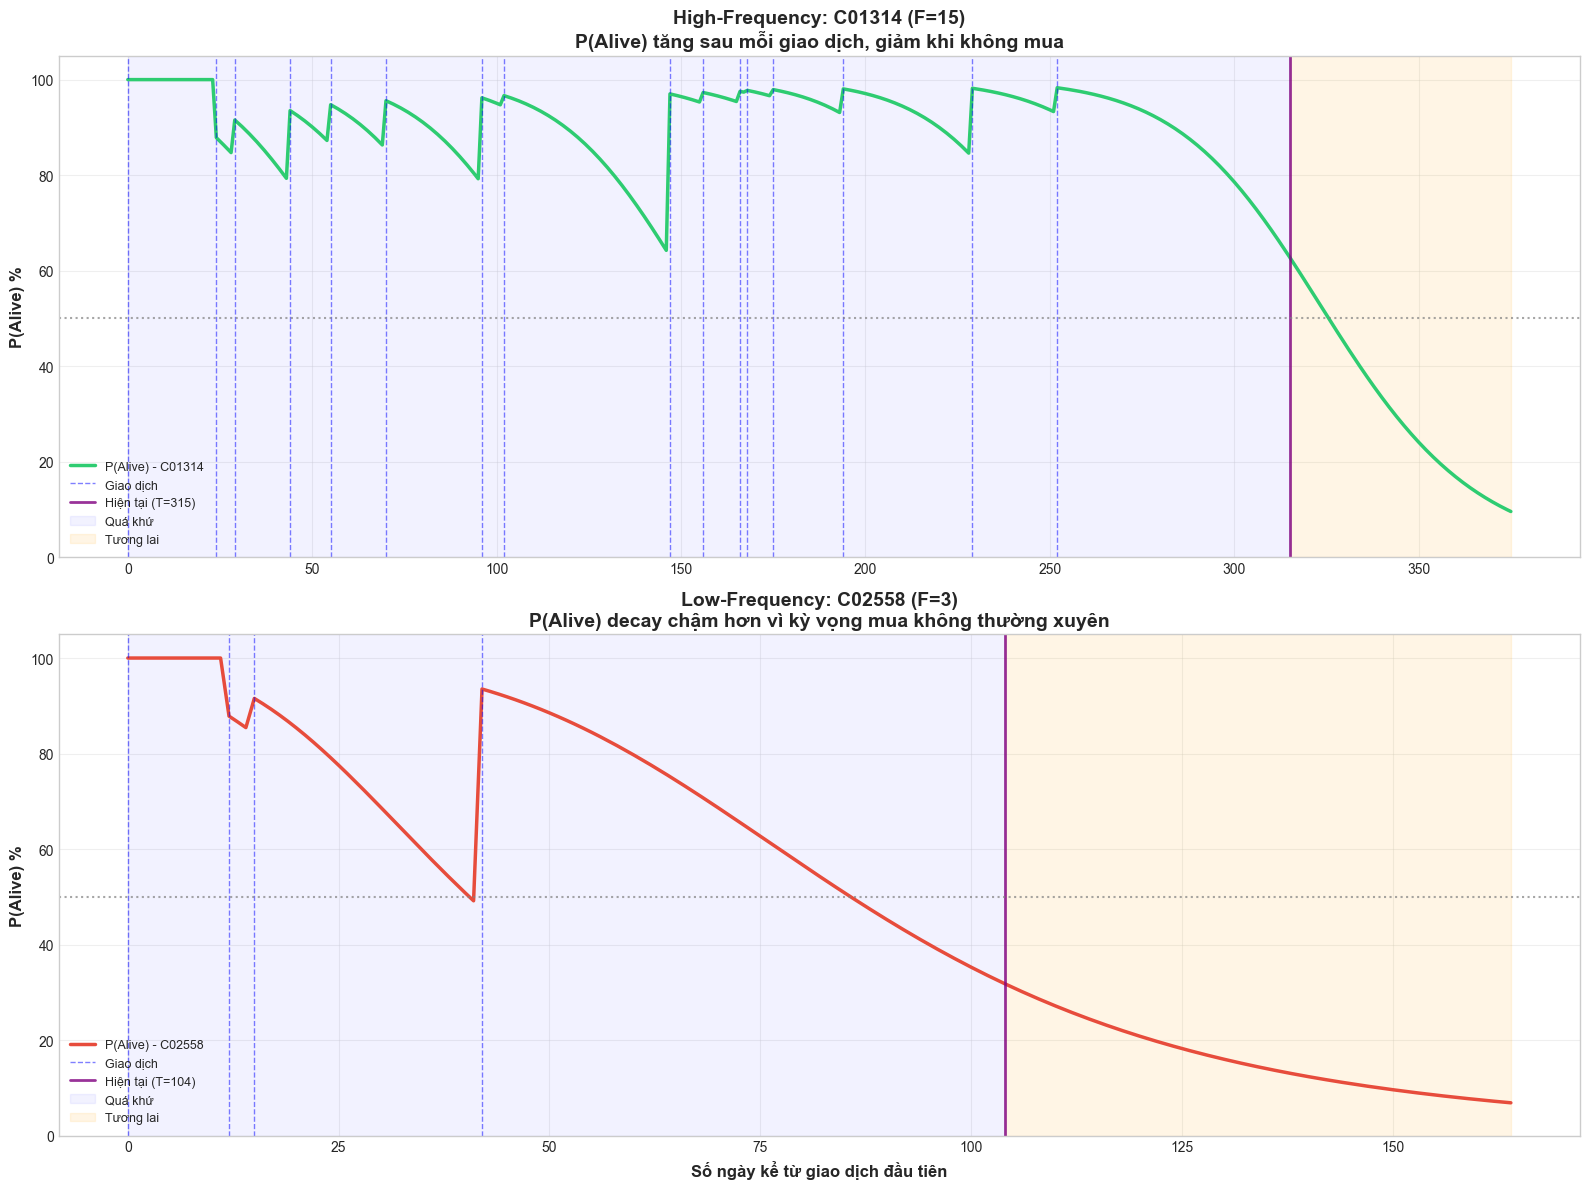

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=False)

color_high, color_low = '#2ecc71', '#e74c3c'

# --- CHART 1: High-Frequency Customer ---
ax1 = axes[0]
ax1.plot(timeline_high, palive_high * 100, color=color_high, linewidth=2.5, 
         label=f'P(Alive) - {customer_high_id}')

for i, tx_day in enumerate(tx_days_high):
    label = 'Giao dịch' if i == 0 else None
    ax1.axvline(x=tx_day, color='blue', linestyle='--', alpha=0.5, linewidth=1, label=label)

ax1.axvline(x=T_high, color='purple', linestyle='-', linewidth=2, alpha=0.8, 
            label=f'Hiện tại (T={T_high})')
ax1.axvspan(0, T_high, alpha=0.05, color='blue', label='Quá khứ')
ax1.axvspan(T_high, T_high + future_days, alpha=0.1, color='orange', label='Tương lai')
ax1.axhline(y=50, color='gray', linestyle=':', alpha=0.7, linewidth=1.5)

ax1.set_ylabel('P(Alive) %', fontsize=12, fontweight='bold')
ax1.set_title(f'High-Frequency: {customer_high_id} (F={customer_high["frequency"]:.0f})\n'
              f'P(Alive) tăng sau mỗi giao dịch, giảm khi không mua', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 105)
ax1.legend(loc='lower left', fontsize=9)
ax1.grid(alpha=0.3)

# --- CHART 2: Low-Frequency Customer ---
ax2 = axes[1]
ax2.plot(timeline_low, palive_low * 100, color=color_low, linewidth=2.5,
         label=f'P(Alive) - {customer_low_id}')

for i, tx_day in enumerate(tx_days_low):
    label = 'Giao dịch' if i == 0 else None
    ax2.axvline(x=tx_day, color='blue', linestyle='--', alpha=0.5, linewidth=1, label=label)

ax2.axvline(x=T_low, color='purple', linestyle='-', linewidth=2, alpha=0.8,
            label=f'Hiện tại (T={T_low})')
ax2.axvspan(0, T_low, alpha=0.05, color='blue', label='Quá khứ')
ax2.axvspan(T_low, T_low + future_days, alpha=0.1, color='orange', label='Tương lai')
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.7, linewidth=1.5)

ax2.set_xlabel('Số ngày kể từ giao dịch đầu tiên', fontsize=12, fontweight='bold')
ax2.set_ylabel('P(Alive) %', fontsize=12, fontweight='bold')
ax2.set_title(f'Low-Frequency: {customer_low_id} (F={customer_low["frequency"]:.0f})\n'
              f'P(Alive) decay chậm hơn vì kỳ vọng mua không thường xuyên', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 105)
ax2.legend(loc='lower left', fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [54]:
# =============================================================================
# 3.7 SO SÁNH BG-NBD VỚI GROUND TRUTH (TRAIN & TEST)
# =============================================================================

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

print("="*80)
print("BG-NBD VS GROUND TRUTH")
print("="*80)

# --- TRAIN SET ---
print("\n" + "="*60)
print("1. TRAINING SET")
print("="*60)

if 'train_features' in dir():
    train_comparison = train_features[['customer_id', 'label']].copy()
    train_comparison = train_comparison.merge(
        rfm_bgf[['p_alive']], 
        left_on='customer_id', 
        right_index=True, 
        how='inner'
    )
    train_comparison['churn_pred_bgnbd'] = (train_comparison['p_alive'] < 0.5).astype(int)
    
    train_acc = accuracy_score(train_comparison['label'], train_comparison['churn_pred_bgnbd'])
    train_auc_bgf = roc_auc_score(train_comparison['label'], 1 - train_comparison['p_alive'])
    
    print(f"\nAccuracy: {train_acc:.4f}")
    print(f"ROC-AUC: {train_auc_bgf:.4f}")
    
    cm_train = confusion_matrix(train_comparison['label'], train_comparison['churn_pred_bgnbd'])
    print("\nConfusion Matrix (Train):")
    print(pd.DataFrame(cm_train, 
                       index=['Actual: Retained', 'Actual: Churned'],
                       columns=['Pred: Retained', 'Pred: Churned']))
else:
    print("⚠️ train_features không tồn tại")

# --- TEST SET ---
print("\n" + "="*60)
print("2. TEST SET")
print("="*60)

if 'test_features' in dir():
    test_comparison = test_features[['customer_id', 'label']].copy()
    test_comparison = test_comparison.merge(
        rfm_bgf[['p_alive']], 
        left_on='customer_id', 
        right_index=True, 
        how='inner'
    )
    test_comparison['churn_pred_bgnbd'] = (test_comparison['p_alive'] < 0.5).astype(int)
    
    test_acc = accuracy_score(test_comparison['label'], test_comparison['churn_pred_bgnbd'])
    test_auc_bgf = roc_auc_score(test_comparison['label'], 1 - test_comparison['p_alive'])
    
    print(f"\nAccuracy: {test_acc:.4f}")
    print(f"ROC-AUC: {test_auc_bgf:.4f}")
    
    cm_test = confusion_matrix(test_comparison['label'], test_comparison['churn_pred_bgnbd'])
    print("\nConfusion Matrix (Test):")
    print(pd.DataFrame(cm_test, 
                       index=['Actual: Retained', 'Actual: Churned'],
                       columns=['Pred: Retained', 'Pred: Churned']))
else:
    print("test_features không tồn tại")

# --- SUMMARY ---
print("\n" + "="*80)
print("SUMMARY: BG-NBD PERFORMANCE")
print("="*80)

if 'train_features' in dir() and 'test_features' in dir():
    summary_bgf = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'Accuracy': [train_acc, test_acc],
        'ROC-AUC': [train_auc_bgf, test_auc_bgf]
    })
    print("\n" + summary_bgf.to_string(index=False))

BG-NBD VS GROUND TRUTH

1. TRAINING SET

Accuracy: 0.5678
ROC-AUC: 0.6928

Confusion Matrix (Train):
                  Pred: Retained  Pred: Churned
Actual: Retained            2627           3093
Actual: Churned              264           1783

2. TEST SET

Accuracy: 0.8717
ROC-AUC: 0.8925

Confusion Matrix (Test):
                  Pred: Retained  Pred: Churned
Actual: Retained             979            130
Actual: Churned               72            393

SUMMARY: BG-NBD PERFORMANCE

Dataset  Accuracy  ROC-AUC
  Train  0.567787 0.692780
   Test  0.871665 0.892505


---
# PART 4: Churn with Survival Analysis

In [57]:
import sys
sys.path.append('../src')
from coxph_feature_prepation import (
    prepare_survival_data, 
    prepare_cox_features, 
    get_default_cox_features,
    print_survival_summary
)

customers = pd.read_csv('../data/customers.csv')
customers['signup_date'] = pd.to_datetime(customers['signup_date'])

OBSERVATION_DATE_SURVIVAL = transactions['transaction_date'].max() + pd.Timedelta(days=1)

survival_data = prepare_survival_data(
    features_df=test_features,
    customers_df=customers,
    observation_date=OBSERVATION_DATE_SURVIVAL,
    customer_id_col='customer_id',
    true_lifetime_col='true_lifetime_days',
    signup_date_col='signup_date'
)

print_survival_summary(survival_data, OBSERVATION_DATE_SURVIVAL)

display(survival_data[['customer_id', 'signup_date', 'T', 'censor_time', 'duration', 'event']].head(10))

📊 SURVIVAL DATA SUMMARY

📅 Observation Date: 2026-01-01

📊 Dataset Size: 1574 customers
   - Events (T <= censor_time): 783
   - Censored (T > censor_time): 791
   - Event Rate: 49.75%

📊 Duration Statistics:
   - Mean: 151.1 days
   - Median: 141.0 days
   - Min: 30.0 days
   - Max: 357.0 days

📊 T (True Lifetime) Statistics:
   - Mean: 198.7 days
   - Median: 191.0 days

📊 Censor Time Statistics:
   - Mean: 178.5 days
   - Median: 167.5 days


,customer_id,signup_date,T,censor_time,duration,event
0,C00000,2025-08-22,204,132,132,0
1,C00001,2025-03-07,365,300,300,0
2,C00002,2025-08-18,48,136,48,1
3,C00003,2025-09-22,84,101,84,1
4,C00004,2025-05-28,113,218,113,1
5,C00006,2025-08-22,117,132,117,1
6,C00007,2025-08-03,321,151,151,0
7,C00008,2025-05-02,209,244,209,1
8,C00010,2025-09-06,92,117,92,1
9,C00011,2025-08-25,260,129,129,0


In [58]:
from sklearn.preprocessing import StandardScaler

# Get default Cox features
cox_features = get_default_cox_features()
print(f"Cox PH Features: {cox_features}")

# Prepare data for Cox model using the imported function
cox_data = prepare_cox_features(
    survival_df=survival_data,
    feature_cols=cox_features,
    duration_col='duration',
    event_col='event',
    fillna_value=0
)

scaler = StandardScaler()
cox_data_scaled = cox_data.copy()
cox_data_scaled[cox_features] = scaler.fit_transform(cox_data[cox_features])

cph = CoxPHFitter(penalizer=0.01)
cph.fit(cox_data_scaled, duration_col='duration', event_col='event')

print(f"\nConcordance Index: {cph.concordance_index_:.4f}")
display(cph.summary)

Cox PH Features: ['recency', 'frequency', 'monetary', 'RFM_score', 'purchase_frequency_rate', 'recent_30d_frequency', 'frequency_trend', 'is_declining', 'cv_spending']

Concordance Index: 0.6873


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
recency,0.321262,1.378867,0.055768,0.211958,0.430565,1.236096,1.538127,0.0,5.760672,8.377979e-09,26.830751
frequency,-0.326136,0.721707,0.111561,-0.544792,-0.107481,0.579963,0.898094,0.0,-2.923389,3.462438e-03,8.173996
monetary,0.100733,1.105982,0.050813,0.001141,0.200325,1.001142,1.221800,0.0,1.982423,4.743195e-02,4.397997
RFM_score,-0.091894,0.912202,0.080834,-0.250325,0.066537,0.778547,1.068801,0.0,-1.136827,2.556105e-01,1.967981
purchase_frequency_rate,0.441646,1.555265,0.070853,0.302776,0.580515,1.353611,1.786959,0.0,6.233249,4.568585e-10,31.027533
recent_30d_frequency,-0.149224,0.861377,0.139649,-0.422930,0.124483,0.655125,1.132562,0.0,-1.068564,2.852660e-01,1.809620
frequency_trend,-0.161062,0.851239,0.092622,-0.342597,0.020473,0.709924,1.020684,0.0,-1.738925,8.204797e-02,3.607389
is_declining,-0.132518,0.875887,0.053219,-0.236825,-0.028212,0.789130,0.972182,0.0,-2.490077,1.277156e-02,6.290922
cv_spending,-0.017090,0.983055,0.036910,-0.089432,0.055252,0.914450,1.056807,0.0,-0.463025,6.433462e-01,0.636333


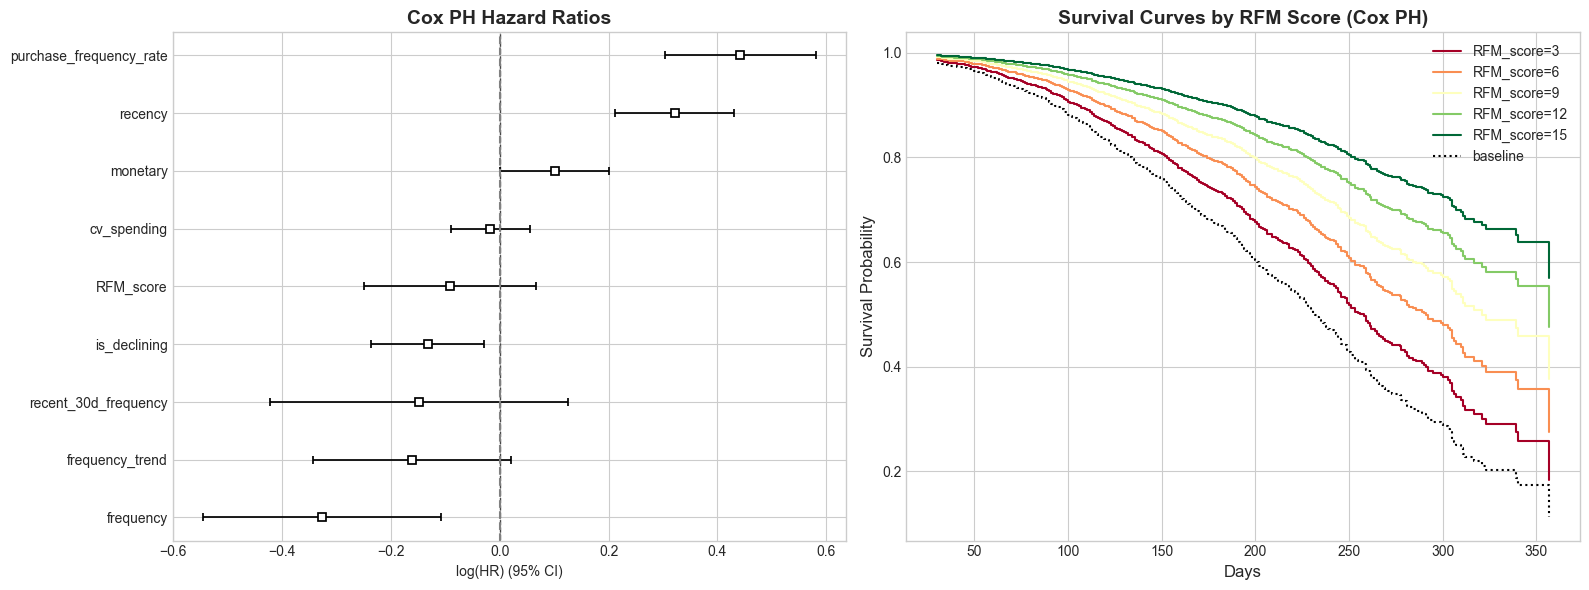


Feature Importance (Hazard Ratios):
                Feature  Hazard Ratio      p-value
purchase_frequency_rate      1.555265 4.568585e-10
                recency      1.378867 8.377979e-09
               monetary      1.105982 4.743195e-02
            cv_spending      0.983055 6.433462e-01
              RFM_score      0.912202 2.556105e-01
           is_declining      0.875887 1.277156e-02
   recent_30d_frequency      0.861377 2.852660e-01
        frequency_trend      0.851239 8.204797e-02
              frequency      0.721707 3.462438e-03


In [60]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cph.plot(ax=axes[0])
axes[0].set_title('Cox PH Hazard Ratios', fontsize=14, fontweight='bold')
axes[0].axvline(0, color='gray', linestyle='--')

cph.plot_partial_effects_on_outcome(covariates='RFM_score', values=[3, 6, 9, 12, 15], 
                                    cmap='RdYlGn', ax=axes[1])
axes[1].set_title('Survival Curves by RFM Score (Cox PH)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days', fontsize=12)
axes[1].set_ylabel('Survival Probability', fontsize=12)

plt.tight_layout()
plt.show()

# Feature importance
print("\nFeature Importance (Hazard Ratios):")
hr_df = pd.DataFrame({
    'Feature': cph.summary.index,
    'Hazard Ratio': np.exp(cph.summary['coef']),
    'p-value': cph.summary['p']
}).sort_values('Hazard Ratio', ascending=False)
print(hr_df.to_string(index=False))

In [61]:
# Predict median survival time
survival_data['median_survival_time'] = cph.predict_median(cox_data[cox_features])
survival_data['expected_remaining_lifetime'] = survival_data['median_survival_time'] - survival_data['duration']
survival_data['expected_remaining_lifetime'] = survival_data['expected_remaining_lifetime'].clip(lower=0)

# Survival probability at specific time points
for days in [30, 60, 90, 180]:
    survival_probs = cph.predict_survival_function(cox_data[cox_features], times=[days])
    survival_data[f'survival_prob_{days}d'] = survival_probs.values.flatten()
    survival_data[f'churn_risk_{days}d'] = 1 - survival_data[f'survival_prob_{days}d']

print("\nSurvival Predictions Sample:")
display(survival_data[['customer_id', 'T', 'censor_time', 'event', 'median_survival_time', 
                     'expected_remaining_lifetime', 'survival_prob_60d', 'churn_risk_60d']].head(10))


Survival Predictions Sample:


,customer_id,T,censor_time,event,median_survival_time,expected_remaining_lifetime,survival_prob_60d,churn_risk_60d
0,C00000,204,132,0,30.0,0.0,2.392630e-214,1.000000
1,C00001,365,300,0,30.0,0.0,1.976263e-323,1.000000
2,C00002,48,136,1,30.0,0.0,0.000000e+00,1.000000
3,C00003,84,101,1,30.0,0.0,0.000000e+00,1.000000
4,C00004,113,218,1,30.0,0.0,0.000000e+00,1.000000
5,C00006,117,132,1,30.0,0.0,1.125492e-247,1.000000
6,C00007,321,151,0,30.0,0.0,0.000000e+00,1.000000
7,C00008,209,244,1,116.0,0.0,8.231105e-01,0.176889
8,C00010,92,117,1,30.0,0.0,0.000000e+00,1.000000
9,C00011,260,129,0,30.0,0.0,5.149913e-16,1.000000


---
# PART 5: CLV Modeling

### Two Approaches:

**Approach 1 – BG-NBD + Gamma–Gamma**
- Fit BG-NBD model (already done in Part 3)
- Predict: Expected number of future transactions, Probability customer is alive
- Fit Gamma–Gamma model
- Compute: Expected monetary value, CLV over time horizon T

**Approach 2 – Survival Analysis + Gamma–Gamma**
- Use survival model output (from Part 4)
- Predict: Survival curve, Expected remaining lifetime
- Fit Gamma–Gamma model
- Compute: Time-dependent CLV

In [62]:
"""
Approach 1 sử dụng:
- BG-NBD Model (đã fit ở Part 3): Dự đoán P(alive) và Expected purchases
- Gamma-Gamma Model: Dự đoán Expected monetary value
- CLV = E[future transactions] x E[monetary value]
"""
from lifetimes import GammaGammaFitter

print("\nBG-NBD Predictions Sample:")
display(rfm_bgf[['frequency', 'recency', 'T', 'monetary_value', 'p_alive', 
               'expected_purchases_30d', 'expected_purchases_60d', 'expected_purchases_90d']].head(10))


BG-NBD Predictions Sample:


,frequency,recency,T,monetary_value,p_alive,expected_purchases_30d,expected_purchases_60d,expected_purchases_90d
customer_id,,,,,,,,
C00000,11.0,112.0,112.0,93.370000,0.977384,2.884475,5.612913,8.217928
C00001,17.0,278.0,289.0,68.373529,0.970194,1.764507,3.484619,5.165051
C00002,9.0,37.0,133.0,86.307778,0.000339,0.000718,0.001402,0.002058
C00003,3.0,45.0,88.0,19.393333,0.535590,0.688525,1.332634,1.943067
C00004,17.0,98.0,206.0,109.965882,0.000188,0.000471,0.000925,0.001366
C00005,6.0,46.0,48.0,29.576667,0.951103,3.420430,6.521819,9.407555
C00006,2.0,82.0,118.0,32.875000,0.780946,0.596411,1.161498,1.701638
C00007,4.0,50.0,142.0,88.840000,0.108884,0.112303,0.219498,0.322505
C00008,12.0,176.0,237.0,56.019167,0.513207,0.819965,1.615439,2.389464


In [64]:
"""
Gamma-Gamma Model yêu cầu:
- frequency > 0 (customers with repeat purchases)
- monetary_value > 0
Dự đoán: Expected average profit per transaction
"""

# Filter returning customers (frequency > 0)
returning_customers = rfm_bgf[rfm_bgf['frequency'] > 0].copy()

print(f"\n Returning Customers: {len(returning_customers)} ({len(returning_customers)/len(rfm_bgf)*100:.1f}%)")
print(f"   (Customers with at least 2 purchases)")

# Check correlation between frequency and monetary_value
# Gamma-Gamma assumes no correlation
corr = returning_customers[['frequency', 'monetary_value']].corr().iloc[0, 1]
print(f"\nCorrelation (Frequency vs Monetary): {corr:.4f}")
if abs(corr) < 0.3:
    print("Low correlation - Gamma-Gamma assumption satisfied")
else:
    print("Moderate correlation - Results may be less reliable")

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(returning_customers['frequency'], returning_customers['monetary_value'])

print("\nModel Parameters:")
display(ggf.summary)


 Returning Customers: 2755 (95.3%)
   (Customers with at least 2 purchases)

Correlation (Frequency vs Monetary): 0.0406
Low correlation - Gamma-Gamma assumption satisfied

Model Parameters:


,coef,se(coef),lower 95% bound,upper 95% bound
p,3.864165,0.091021,3.685764,4.042566
q,0.687321,0.015774,0.656404,0.718237
v,3.830656,0.092474,3.649406,4.011906


In [65]:
# Calculate expected average profit per transaction
returning_customers['expected_avg_profit'] = ggf.conditional_expected_average_profit(
    returning_customers['frequency'],
    returning_customers['monetary_value']
)

print("\nExpected Monetary Value Statistics:")
comparison_df = returning_customers[['frequency', 'monetary_value', 'expected_avg_profit']].describe()
display(comparison_df)

print("\nSample Predictions:")
sample = returning_customers[['frequency', 'monetary_value', 'expected_avg_profit']].head(10)
sample['difference'] = sample['expected_avg_profit'] - sample['monetary_value']
sample['diff_pct'] = (sample['difference'] / sample['monetary_value'] * 100).round(2)
display(sample)


Expected Monetary Value Statistics:


,frequency,monetary_value,expected_avg_profit
count,2755.000000,2755.000000,2755.000000
mean,13.916515,64.165748,66.004991
std,13.574812,44.915232,46.025157
min,1.000000,0.690000,1.681683
25%,4.000000,32.766108,34.123214
50%,10.000000,54.921786,56.449687
75%,19.000000,83.850667,86.050737
max,113.000000,476.210000,522.304339



Sample Predictions:


,frequency,monetary_value,expected_avg_profit,difference,diff_pct
customer_id,,,,,
C00000,11.0,93.370000,94.412757,1.042757,1.12
C00001,17.0,68.373529,68.926945,0.553416,0.81
C00002,9.0,86.307778,87.520289,1.212511,1.40
C00003,3.0,19.393333,21.243203,1.849869,9.54
C00004,17.0,109.965882,110.718219,0.752337,0.68
C00005,6.0,29.576667,30.628170,1.051503,3.56
C00006,2.0,32.875000,36.257255,3.382255,10.29
C00007,4.0,88.840000,91.651726,2.811726,3.16
C00008,12.0,56.019167,56.720865,0.701698,1.25


In [66]:
"""
CLV Formula (BG-NBD + Gamma-Gamma):
CLV = E[transactions in T] x E[profit per transaction] x discount_factor

Parameters:
- time: Prediction horizon in months
- discount_rate: Monthly discount rate
"""

TIME_HORIZONS = [6, 12, 24]  # 6 months, 1 year, 2 years
DISCOUNT_RATE = 0.01  # Monthly discount rate (~12% annually)


print(f"\nTime Horizons: {TIME_HORIZONS} months")
print(f"Discount Rate: {DISCOUNT_RATE*100:.1f}% per month (~{DISCOUNT_RATE*12*100:.0f}% annually)")

# Calculate CLV for different time horizons
for months in TIME_HORIZONS:
    returning_customers[f'clv_bgnbd_{months}m'] = ggf.customer_lifetime_value(
        bgf,  # BG-NBD model from Part 3
        returning_customers['frequency'],
        returning_customers['recency'],
        returning_customers['T'],
        returning_customers['monetary_value'],
        time=months,
        discount_rate=DISCOUNT_RATE
    )

# Add p_alive and expected purchases to display
print("\nCLV Statistics by Time Horizon:")
clv_cols = [f'clv_bgnbd_{m}m' for m in TIME_HORIZONS]
display(returning_customers[['p_alive'] + clv_cols].describe())

# Top 10 highest CLV customers
print("\nTop 10 Highest CLV Customers (12-month):")
top_clv = returning_customers.nlargest(10, 'clv_bgnbd_12m')[
    ['frequency', 'recency', 'T', 'monetary_value', 'p_alive', 'expected_purchases_60d', 'clv_bgnbd_12m']
]
display(top_clv)


Time Horizons: [6, 12, 24] months
💰 Discount Rate: 1.0% per month (~12% annually)

CLV Statistics by Time Horizon:


,p_alive,clv_bgnbd_6m,clv_bgnbd_12m,clv_bgnbd_24m
count,2.755000e+03,2.755000e+03,2.755000e+03,2.755000e+03
mean,4.848247e-01,8.336954e+02,1.475574e+03,2.488467e+03
std,4.303885e-01,1.875032e+03,3.271416e+03,5.450327e+03
min,3.085812e-18,1.412362e-15,2.622948e-15,4.633113e-15
25%,9.763915e-03,1.863874e+00,3.447057e+00,5.999295e+00
50%,4.726812e-01,1.403842e+02,2.556572e+02,4.386955e+02
75%,9.540221e-01,9.144274e+02,1.648772e+03,2.816778e+03
max,9.975691e-01,3.049249e+04,5.239073e+04,8.611910e+04



Top 10 Highest CLV Customers (12-month):


,frequency,recency,T,monetary_value,p_alive,expected_purchases_60d,clv_bgnbd_12m
customer_id,,,,,,,
C00884,27.0,31.0,31.0,337.455926,0.990178,35.960188,52390.728232
C01876,31.0,34.0,34.0,304.698710,0.991395,38.539129,51012.321782
C00295,24.0,29.0,29.0,287.055417,0.989012,33.599952,41469.466873
C00688,27.0,27.0,28.0,243.562222,0.979151,38.083973,39774.130401
C02934,40.0,52.0,53.0,228.864000,0.986989,35.298496,36289.020932
C00243,26.0,35.0,35.0,212.141154,0.989818,31.872294,29456.582420
C02338,29.0,35.0,35.0,178.772759,0.990826,35.405198,27567.726649
C00158,91.0,148.0,148.0,152.858571,0.996990,33.442682,24966.523437
C02478,32.0,41.0,41.0,161.406563,0.991653,34.738563,24704.689293


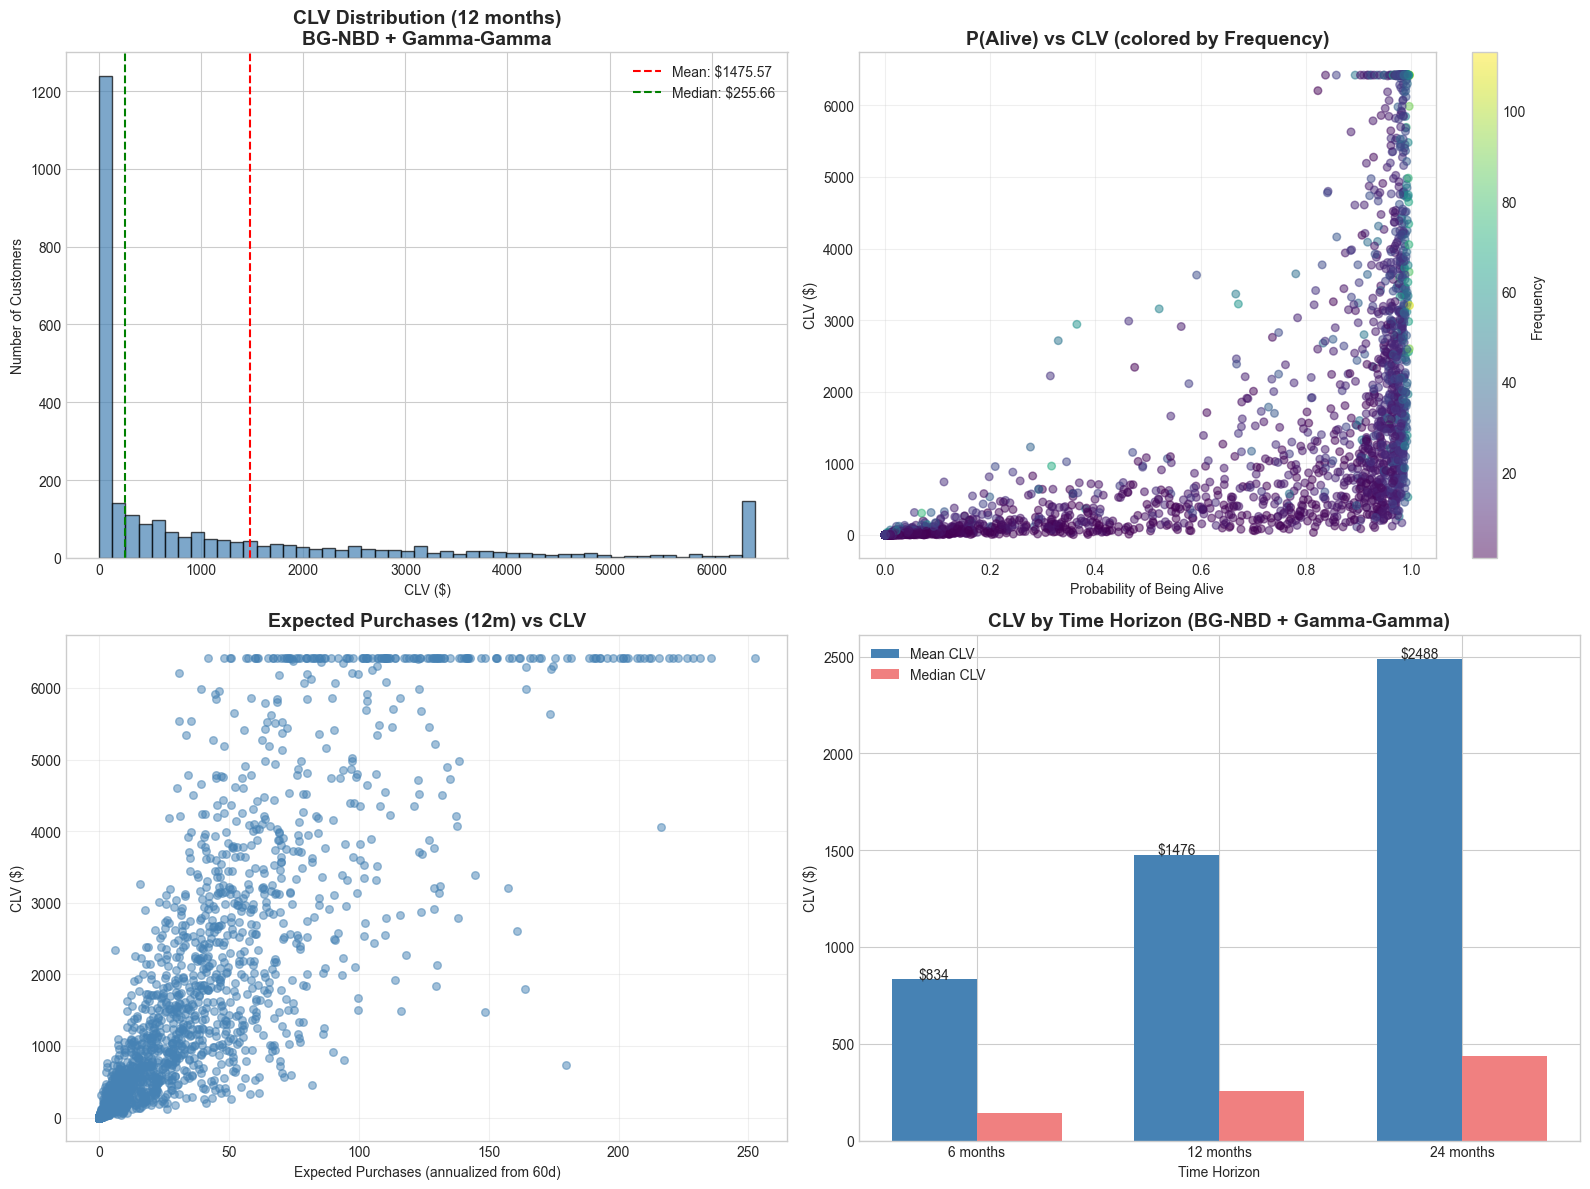


✅ Approach 1 (BG-NBD + Gamma-Gamma) Completed!


In [ ]:
# =============================================================================
# Visualize CLV (Approach 1: BG-NBD + Gamma-Gamma)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. CLV distribution (12 months)
clv_cap = returning_customers['clv_bgnbd_12m'].quantile(0.95)
axes[0, 0].hist(returning_customers['clv_bgnbd_12m'].clip(upper=clv_cap), 
                bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('CLV Distribution (12 months)\nBG-NBD + Gamma-Gamma', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('CLV ($)')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].axvline(returning_customers['clv_bgnbd_12m'].mean(), color='red', linestyle='--', 
                   label=f'Mean: ${returning_customers["clv_bgnbd_12m"].mean():.2f}')
axes[0, 0].axvline(returning_customers['clv_bgnbd_12m'].median(), color='green', linestyle='--', 
                   label=f'Median: ${returning_customers["clv_bgnbd_12m"].median():.2f}')
axes[0, 0].legend()

# 2. P(alive) vs CLV
scatter = axes[0, 1].scatter(returning_customers['p_alive'], 
                              returning_customers['clv_bgnbd_12m'].clip(upper=clv_cap),
                              c=returning_customers['frequency'], cmap='viridis',
                              alpha=0.5, s=30)
axes[0, 1].set_title('P(Alive) vs CLV (colored by Frequency)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Probability of Being Alive')
axes[0, 1].set_ylabel('CLV ($)')
axes[0, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Frequency')

# 3. Expected Purchases vs CLV
axes[1, 0].scatter(returning_customers['expected_purchases_60d'] * 6, 
                   returning_customers['clv_bgnbd_12m'].clip(upper=clv_cap),
                   alpha=0.5, s=30, color='steelblue')
axes[1, 0].set_title('Expected Purchases (12m) vs CLV', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Expected Purchases (annualized from 60d)')
axes[1, 0].set_ylabel('CLV ($)')
axes[1, 0].grid(alpha=0.3)

# 4. CLV by Time Horizon
clv_means = [returning_customers[f'clv_bgnbd_{m}m'].mean() for m in TIME_HORIZONS]
clv_medians = [returning_customers[f'clv_bgnbd_{m}m'].median() for m in TIME_HORIZONS]
x = np.arange(len(TIME_HORIZONS))
width = 0.35
bars1 = axes[1, 1].bar(x - width/2, clv_means, width, label='Mean CLV', color='steelblue')
bars2 = axes[1, 1].bar(x + width/2, clv_medians, width, label='Median CLV', color='lightcoral')
axes[1, 1].set_xlabel('Time Horizon')
axes[1, 1].set_ylabel('CLV ($)')
axes[1, 1].set_title('CLV by Time Horizon (BG-NBD + Gamma-Gamma)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'{m} months' for m in TIME_HORIZONS])
axes[1, 1].legend()
for bar in bars1:
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                    f'${bar.get_height():.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
"""
Approach 2 sử dụng:
- Cox PH Survival Model (từ Part 4): Survival curve, Expected remaining lifetime
- Gamma-Gamma Model: Expected monetary value (tái sử dụng từ Approach 1)
- Time-dependent CLV: Tích hợp survival probability vào CLV
"""

# Display survival predictions
print("\nSurvival Predictions Sample:")
survival_cols = ['customer_id', 'duration', 'event', 'median_survival_time', 
                 'expected_remaining_lifetime', 'survival_prob_30d', 'survival_prob_60d', 'survival_prob_90d']
available_cols = [c for c in survival_cols if c in survival_data.columns]
display(survival_data[available_cols].head(10))

print("\nSurvival Statistics:")
display(survival_data[['median_survival_time', 'expected_remaining_lifetime', 
                     'survival_prob_60d', 'churn_risk_60d']].describe())


📊 APPROACH 2: SURVIVAL ANALYSIS + GAMMA-GAMMA CLV

📊 Step 1: Survival Model Output (from Part 4)
------------------------------------------------------------
   Total customers with survival data: 2892
   Cox PH Concordance Index: 0.8169

📊 Survival Predictions Sample:
  customer_id  duration  event  median_survival_time  \
0      C00000       132      0                 357.0   
1      C00001       300      0                 292.0   
2      C00002        48      1                  30.0   
3      C00003        84      1                  30.0   
4      C00004       113      1                  30.0   
5      C00005        50      0                   inf   
6      C00006       117      1                  30.0   
7      C00007       151      0                  30.0   
8      C00008       209      1                  30.0   
9      C00009       172      1                  30.0   

   expected_remaining_lifetime  survival_prob_30d  survival_prob_60d  \
0                        225.0          

📊 Step 2: Survival Curves & Expected Remaining Lifetime

📊 Survival Probabilities at Different Time Points:
            S(30d)       S(60d)       S(90d)      S(180d)        S(365d)
count  2892.000000  2892.000000  2892.000000  2892.000000   2.892000e+03
mean      0.318042     0.308896     0.302381     0.289630   7.005743e-02
std       0.459456     0.455783     0.452854     0.446429   1.675841e-01
min       0.000000     0.000000     0.000000     0.000000  1.714046e-156
25%       0.000000     0.000000     0.000000     0.000000   1.349197e-10
50%       0.000000     0.000000     0.000000     0.000000   8.208238e-05
75%       0.999639     0.998932     0.997681     0.990031   3.785655e-02
max       1.000000     1.000000     1.000000     1.000000   9.968460e-01


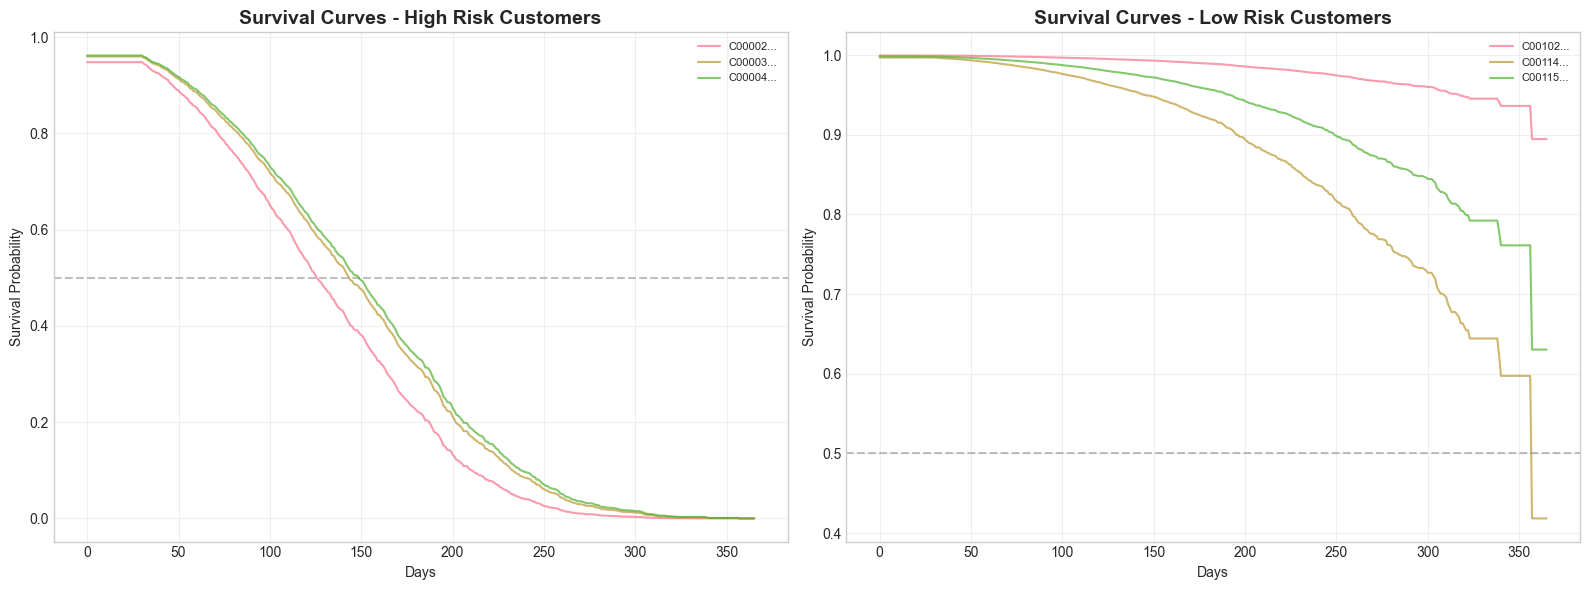


📊 Expected Remaining Lifetime Distribution:
count    2892.0
mean        inf
std         NaN
min         0.0
25%         0.0
50%         0.0
75%         NaN
max         inf
Name: expected_remaining_lifetime, dtype: float64


In [ ]:
time_points = [30, 60, 90, 180, 365]

survival_curves = pd.DataFrame(index=survival_data['customer_id'])

for t in time_points:
    col_name = f'survival_prob_{t}d'
    if col_name not in survival_data.columns:
        # Calculate if not already exists
        surv_probs = cph.predict_survival_function(cox_data_scaled[cox_features], times=[t])
        survival_data[col_name] = surv_probs.values.flatten()
    survival_curves[f'S({t}d)'] = survival_data[col_name].values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Select sample customers with different risk levels
high_risk_customers = survival_data.nsmallest(5, 'survival_prob_60d')['customer_id'].values
low_risk_customers = survival_data.nlargest(5, 'survival_prob_60d')['customer_id'].values

# Plot individual survival curves
timeline = np.arange(0, 366, 1)
for customer_id in high_risk_customers[:3]:
    idx = survival_data[survival_data['customer_id'] == customer_id].index[0]
    customer_data = cox_data_scaled[cox_features].loc[[idx]]
    surv_func = cph.predict_survival_function(customer_data, times=timeline)
    axes[0].plot(timeline, surv_func.values.flatten(), alpha=0.7, label=f'{customer_id[:8]}...')

axes[0].set_title('Survival Curves - High Risk Customers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Survival Probability')
axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

for customer_id in low_risk_customers[:3]:
    idx = survival_data[survival_data['customer_id'] == customer_id].index[0]
    customer_data = cox_data_scaled[cox_features].loc[[idx]]
    surv_func = cph.predict_survival_function(customer_data, times=timeline)
    axes[1].plot(timeline, surv_func.values.flatten(), alpha=0.7, label=f'{customer_id[:8]}...')

axes[1].set_title('Survival Curves - Low Risk Customers', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Survival Probability')
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
"""
Time-dependent CLV formula:
CLV(T) = Σ E[profit_t] x S(t) x discount_factor(t)

Where:
- E[profit_t]: Expected profit at time t (from Gamma-Gamma)
- S(t): Survival probability at time t (from Cox PH)
- discount_factor(t): (1 + r)^(-t)
"""

clv_survival_data = survival_data.copy()

# Merge expected_avg_profit from Gamma-Gamma (returning customers only)
returning_customers_indexed = returning_customers.reset_index()
returning_customers_indexed = returning_customers_indexed.rename(columns={'index': 'customer_id'})

clv_survival_data = clv_survival_data.merge(
    returning_customers_indexed[['customer_id', 'expected_avg_profit', 'frequency', 'monetary_value', 'T']],
    on='customer_id',
    how='left'
)

# For customers with only 1 purchase, use their actual monetary value
clv_survival_data['expected_avg_profit'] = clv_survival_data['expected_avg_profit'].fillna(
    clv_survival_data['monetary_value'] if 'monetary_value' in clv_survival_data.columns else 0
)

print(f"\n Customers with Gamma-Gamma predictions: {clv_survival_data['expected_avg_profit'].notna().sum()}")

# Calculate Time-Dependent CLV
# Method: Integrate survival probability over time horizon
MONTHLY_DISCOUNT_RATE = 0.01
TIME_HORIZON_DAYS = 365

def calculate_survival_clv(row, time_horizon_days=365, discount_rate=0.01):
    """
    Calculate CLV using survival probability.
    CLV = E[profit] x E[purchases per period] x Σ S(t) x discount(t)
    """
    expected_profit = row['expected_avg_profit'] if pd.notna(row['expected_avg_profit']) else 0
    
    # Expected monthly purchases (from BG-NBD expected_purchases_60d, annualized)
    if 'expected_purchases_60d' in row and pd.notna(row['expected_purchases_60d']):
        monthly_purchases = row['expected_purchases_60d'] / 2  # Convert 60d to monthly
    else:
        # Fallback: use frequency / T to estimate purchase rate
        if pd.notna(row.get('frequency', 0)) and row.get('T', 0) > 0:
            monthly_purchases = (row['frequency'] + 1) / (row['T'] / 30)
        else:
            monthly_purchases = 0.5  # Default assumption
    
    # Calculate survival-weighted CLV over time horizon
    months = time_horizon_days / 30
    
    # Use available survival probabilities to estimate integral
    # S(t) ≈ linear interpolation between known points
    survival_probs = []
    for t in [30, 60, 90, 180]:
        col = f'survival_prob_{t}d'
        if col in row and pd.notna(row[col]):
            survival_probs.append((t, row[col]))
    
    if len(survival_probs) == 0:
        return expected_profit * monthly_purchases * months * 0.5  # Fallback
    
    # Simple approximation: weighted average survival × time
    avg_survival = np.mean([sp[1] for sp in survival_probs])
    
    # Discount factor (approximate)
    discount_factor = (1 - (1 + discount_rate) ** (-months)) / discount_rate if discount_rate > 0 else months
    
    clv = expected_profit * monthly_purchases * avg_survival * discount_factor
    return max(0, clv)

# Merge expected_purchases from BG-NBD
clv_survival_data = clv_survival_data.merge(
    rfm_bgf[['expected_purchases_60d']],
    left_on='customer_id',
    right_index=True,
    how='left'
)

# Calculate CLV for each customer
clv_survival_data['clv_survival_12m'] = clv_survival_data.apply(
    lambda row: calculate_survival_clv(row, TIME_HORIZON_DAYS, MONTHLY_DISCOUNT_RATE),
    axis=1
)

print("\n📊 Survival-based CLV Statistics (12 months):")
display(clv_survival_data['clv_survival_12m'].describe())

# Show sample with all components
print("\nSample CLV Breakdown:")
sample_cols = ['customer_id', 'expected_avg_profit', 'expected_purchases_60d', 
               'survival_prob_60d', 'expected_remaining_lifetime', 'clv_survival_12m']
available = [c for c in sample_cols if c in clv_survival_data.columns]
display(clv_survival_data[available].head(10))

📊 Step 3: Time-Dependent CLV (Survival + Gamma-Gamma)

📊 Customers with Gamma-Gamma predictions: 2755

📊 Survival-based CLV Statistics (12 months):
count     2892.000000
mean      1449.546732
std       4088.689910
min          0.000000
25%          0.000000
50%          0.000000
75%       1139.436216
max      69419.429022
Name: clv_survival_12m, dtype: float64

📊 Sample CLV Breakdown:
  customer_id  expected_avg_profit  expected_purchases_60d  survival_prob_60d  \
0      C00000            94.412757                5.612913           0.989863   
1      C00001            68.926945                3.484619           0.980163   
2      C00002            87.520289                0.001402           0.000000   
3      C00003            21.243203                1.332634           0.000000   
4      C00004           110.718219                0.000925           0.000000   
5      C00005            30.628170                6.521819           0.999973   
6      C00006            36.257255           

📊 Step 4: CLV Comparison - BG-NBD vs Survival

📊 Customers with both CLV estimates: 2755

📊 Correlation between BG-NBD CLV and Survival CLV: 0.9788

📊 CLV Statistics Comparison:
Metric   BG-NBD CLV  Survival CLV
  Mean 1.475574e+03   1521.629455
Median 2.556572e+02      0.000000
   Std 3.271416e+03   4176.036669
   Min 2.622948e-15      0.000000
   Max 5.239073e+04  69419.429022


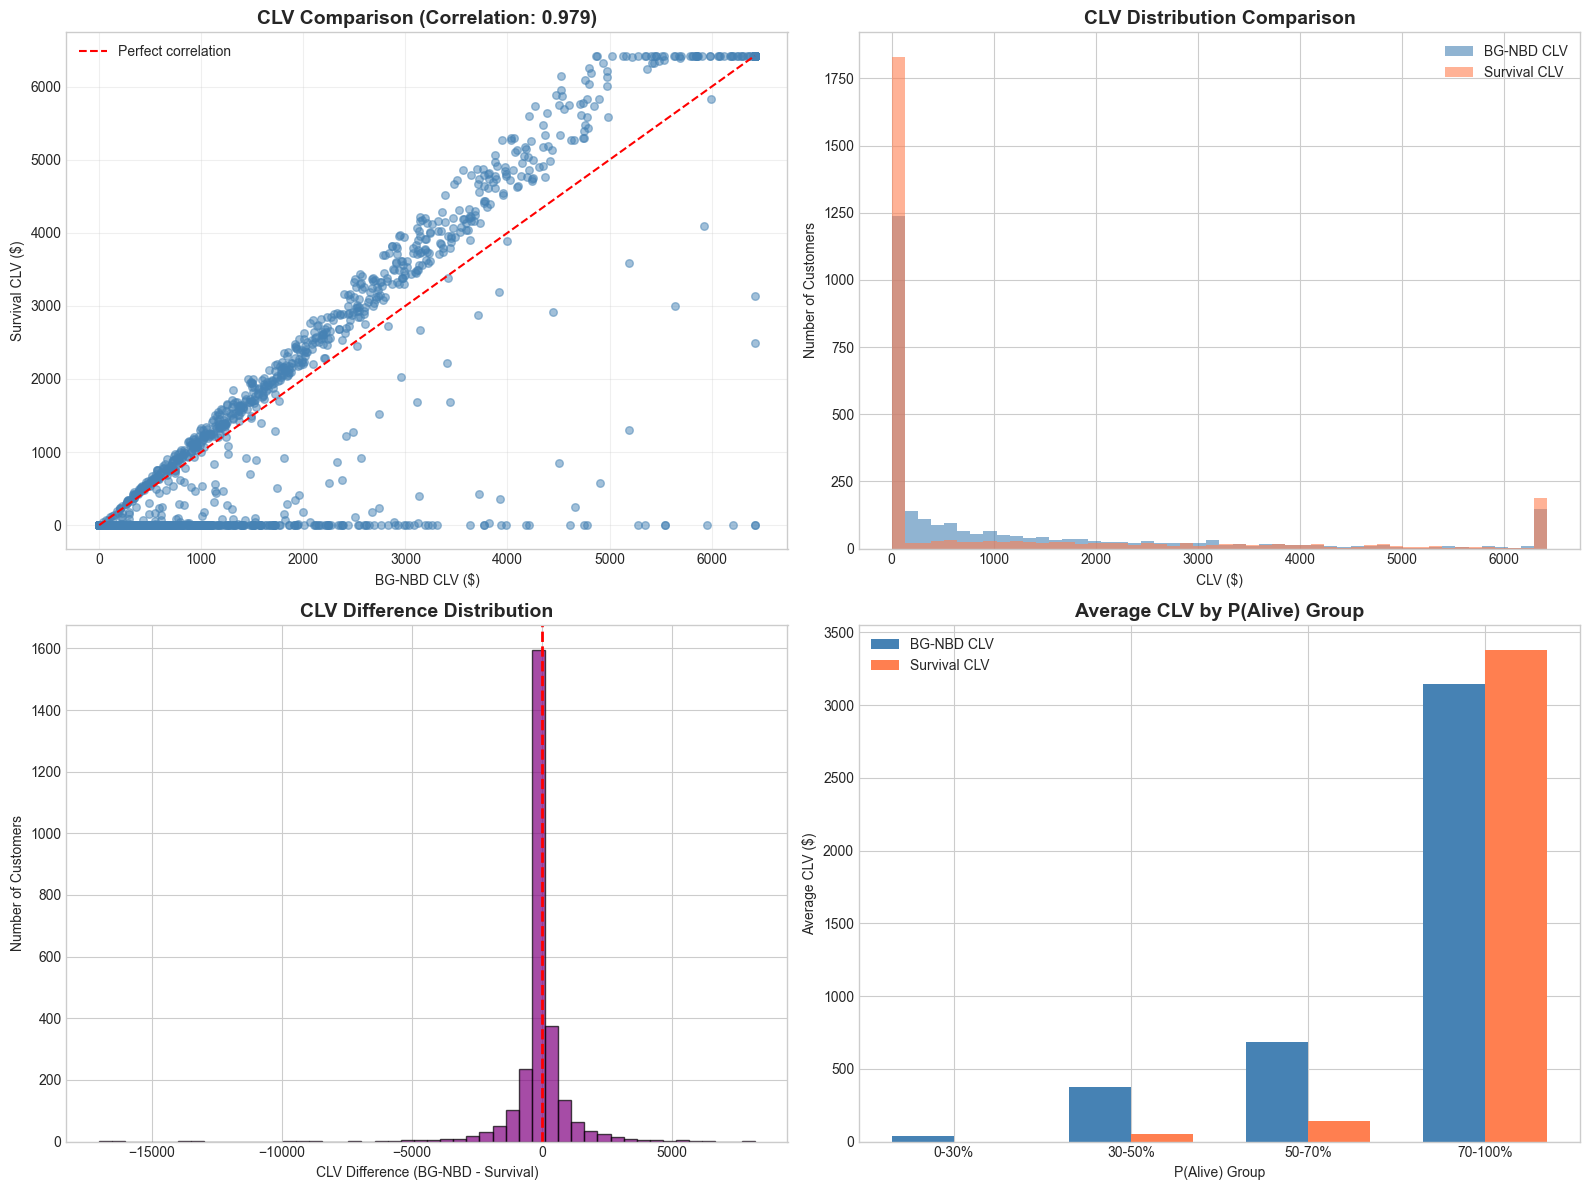


✅ Approach 2 (Survival + Gamma-Gamma) Completed!


In [ ]:
# Merge both CLV estimates
comparison_data = clv_survival_data[['customer_id', 'clv_survival_12m']].copy()
comparison_data = comparison_data.merge(
    returning_customers_indexed[['customer_id', 'clv_bgnbd_12m', 'p_alive', 'frequency']],
    on='customer_id',
    how='inner'
)

print(f"\nCustomers with both CLV estimates: {len(comparison_data)}")

# Correlation between approaches
corr = comparison_data['clv_bgnbd_12m'].corr(comparison_data['clv_survival_12m'])
print(f"\nCorrelation between BG-NBD CLV and Survival CLV: {corr:.4f}")
# Statistics comparison
print("\nCLV Statistics Comparison:")
stats_comparison = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std', 'Min', 'Max'],
    'BG-NBD CLV': [
        comparison_data['clv_bgnbd_12m'].mean(),
        comparison_data['clv_bgnbd_12m'].median(),
        comparison_data['clv_bgnbd_12m'].std(),
        comparison_data['clv_bgnbd_12m'].min(),
        comparison_data['clv_bgnbd_12m'].max()
    ],
    'Survival CLV': [
        comparison_data['clv_survival_12m'].mean(),
        comparison_data['clv_survival_12m'].median(),
        comparison_data['clv_survival_12m'].std(),
        comparison_data['clv_survival_12m'].min(),
        comparison_data['clv_survival_12m'].max()
    ]
})
print(stats_comparison.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: BG-NBD CLV vs Survival CLV
clv_cap_compare = min(comparison_data['clv_bgnbd_12m'].quantile(0.95), 
                       comparison_data['clv_survival_12m'].quantile(0.95))
axes[0, 0].scatter(comparison_data['clv_bgnbd_12m'].clip(upper=clv_cap_compare),
                   comparison_data['clv_survival_12m'].clip(upper=clv_cap_compare),
                   alpha=0.5, s=30, c='steelblue')
max_val = clv_cap_compare
axes[0, 0].plot([0, max_val], [0, max_val], 'r--', label='Perfect correlation')
axes[0, 0].set_xlabel('BG-NBD CLV ($)')
axes[0, 0].set_ylabel('Survival CLV ($)')
axes[0, 0].set_title(f'CLV Comparison (Correlation: {corr:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribution comparison
axes[0, 1].hist(comparison_data['clv_bgnbd_12m'].clip(upper=clv_cap_compare), 
                bins=50, alpha=0.6, label='BG-NBD CLV', color='steelblue')
axes[0, 1].hist(comparison_data['clv_survival_12m'].clip(upper=clv_cap_compare), 
                bins=50, alpha=0.6, label='Survival CLV', color='coral')
axes[0, 1].set_xlabel('CLV ($)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('CLV Distribution Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# 3. Difference distribution
comparison_data['clv_diff'] = comparison_data['clv_bgnbd_12m'] - comparison_data['clv_survival_12m']
axes[1, 0].hist(comparison_data['clv_diff'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('CLV Difference (BG-NBD - Survival)')
axes[1, 0].set_ylabel('Number of Customers')
axes[1, 0].set_title('CLV Difference Distribution', fontsize=14, fontweight='bold')

# 4. CLV by P(alive) groups
comparison_data['p_alive_group'] = pd.cut(comparison_data['p_alive'], 
                                           bins=[0, 0.3, 0.5, 0.7, 1.0],
                                           labels=['0-30%', '30-50%', '50-70%', '70-100%'])
grouped = comparison_data.groupby('p_alive_group')[['clv_bgnbd_12m', 'clv_survival_12m']].mean()
x = np.arange(len(grouped))
width = 0.35
axes[1, 1].bar(x - width/2, grouped['clv_bgnbd_12m'], width, label='BG-NBD CLV', color='steelblue')
axes[1, 1].bar(x + width/2, grouped['clv_survival_12m'], width, label='Survival CLV', color='coral')
axes[1, 1].set_xlabel('P(Alive) Group')
axes[1, 1].set_ylabel('Average CLV ($)')
axes[1, 1].set_title('Average CLV by P(Alive) Group', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(grouped.index)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [90]:
features = test_features.copy()

# Merge BG-NBD outputs (p_alive, expected_purchases)
features = features.merge(
    rfm_bgf[['p_alive', 'expected_purchases_30d', 'expected_purchases_60d', 'expected_purchases_90d']],
    left_on='customer_id',
    right_index=True,
    how='left'
)

# Merge Gamma-Gamma outputs (expected_avg_profit)
features = features.merge(
    returning_customers_indexed[['customer_id', 'expected_avg_profit', 'clv_bgnbd_12m']],
    on='customer_id',
    how='left'
)

# Fill NaN for customers with only 1 purchase
features['expected_avg_profit'] = features['expected_avg_profit'].fillna(features['monetary'])
features['clv_bgnbd_12m'] = features['clv_bgnbd_12m'].fillna(features['monetary'])
features['p_alive'] = features['p_alive'].fillna(0.5)  # Neutral assumption

# Merge Survival outputs
survival_merge_cols = ['customer_id', 'survival_prob_60d', 'churn_risk_60d', 'expected_remaining_lifetime']
features = features.merge(
    survival_data[survival_merge_cols],
    on='customer_id',
    how='left'
)

# Merge Survival-based CLV
features = features.merge(
    clv_survival_data[['customer_id', 'clv_survival_12m']],
    on='customer_id',
    how='left'
)

# Fill NaN survival columns
features['survival_prob_60d'] = features['survival_prob_60d'].fillna(0.5)
features['churn_risk_60d'] = features['churn_risk_60d'].fillna(0.5)
features['clv_survival_12m'] = features['clv_survival_12m'].fillna(features['clv_bgnbd_12m'])

# Add classification churn probability (from Part 2 model)
if 'calibrated_model' in dir():
    X_for_pred = features[FEATURE_COLUMNS].copy()
    X_for_pred = X_for_pred.fillna(0)
    features['churn_probability_classification'] = calibrated_model.predict_proba(X_for_pred)[:, 1]
elif 'best_model' in dir():
    X_for_pred = features[FEATURE_COLUMNS].copy()
    X_for_pred = X_for_pred.fillna(0)
    features['churn_probability_classification'] = best_model.predict_proba(X_for_pred)[:, 1]
else:
    features['churn_probability_classification'] = 1 - features['p_alive']

print(f"\nFinal features shape: {features.shape}")
print(f"\nKey Columns for Part 6:")
key_cols = ['customer_id', 'segment', 'RFM_score', 'total_spent', 'frequency',
            'p_alive', 'churn_probability_classification', 
            'clv_bgnbd_12m', 'clv_survival_12m', 'survival_prob_60d', 'churn_risk_60d']
available_key = [c for c in key_cols if c in features.columns]
display(features[available_key].head(10))


Final features shape: (1574, 66)

Key Columns for Part 6:


,customer_id,segment,RFM_score,total_spent,frequency,p_alive,churn_probability_classification,clv_bgnbd_12m,clv_survival_12m,survival_prob_60d,churn_risk_60d
0,C00000,Loyal,13,714.51,6,0.977384,1.000000e+00,2526.040430,2.694066e-80,2.392630e-214,1.000000
1,C00001,At Risk,8,235.84,5,0.970194,1.000000e+00,1230.082598,9.513558e-123,1.976263e-323,1.000000
2,C00002,At Risk,10,910.64,11,0.000339,9.478268e-11,0.593203,0.000000e+00,0.000000e+00,1.000000
3,C00003,About to Sleep,5,79.68,2,0.535590,1.000000e+00,132.143789,0.000000e+00,0.000000e+00,1.000000
4,C00004,Cannot Lose Them,8,597.95,7,0.000188,9.999529e-01,0.512516,0.000000e+00,0.000000e+00,1.000000
5,C00006,About to Sleep,5,58.36,2,0.780946,1.000000e+00,201.395163,2.935907e-94,1.125492e-247,1.000000
6,C00007,At Risk,10,584.63,5,0.108884,8.229897e-01,97.724244,0.000000e+00,0.000000e+00,1.000000
7,C00008,Champions,12,387.43,8,0.513207,1.000000e+00,462.978492,3.423909e+02,8.231105e-01,0.176889
8,C00010,About to Sleep,8,177.50,2,0.646918,9.999984e-01,356.726239,0.000000e+00,0.000000e+00,1.000000
9,C00011,Potential Loyalist,11,545.10,9,0.941905,1.000000e+00,1757.077639,6.554515e-04,5.149913e-16,1.000000


---
# PART 6: Final Business Question


### Scenario: Ngân sách retention chỉ đủ giữ 20% customer base

### 3 Strategies to Compare:
1. **High Churn Probability (Classification)**: Target top 20% highest churn risk
2. **Low P(alive) (BG-NBD)**: Target bottom 20% P(alive)
3. **High CLV × High Churn Risk (Survival-based)**: Target high-value customers at risk

In [91]:
final_data = features.copy()

In [92]:
# Define retention strategies
TOP_PERCENT = 0.20  # Top 20% to target
n_target = int(len(final_data) * TOP_PERCENT)

print(f"Target: Top {TOP_PERCENT*100:.0f}% customers = {n_target} customers")
print("\n" + "="*80)

# Strategy 1
strategy1_targets = final_data.nlargest(n_target, 'churn_probability_classification')['customer_id'].tolist()
print(f"\nStrategy 1")
print(f"   Threshold: {final_data['churn_probability_classification'].quantile(1-TOP_PERCENT):.4f}")
print(f"   Customers selected: {len(strategy1_targets)}")

# Strategy 2
strategy2_targets = final_data.nsmallest(n_target, 'p_alive')['customer_id'].tolist()
print(f"\nStrategy 2")
print(f"   Threshold: {final_data['p_alive'].quantile(TOP_PERCENT):.4f}")
print(f"   Customers selected: {len(strategy2_targets)}")

# Strategy 3
final_data['clv_risk_score'] = final_data['clv_bgnbd_12m'] * final_data['churn_risk_60d']
strategy3_targets = final_data.nlargest(n_target, 'clv_risk_score')['customer_id'].tolist()
print(f"\nStrategy 3")
print(f"   Customers selected: {len(strategy3_targets)}")

Target: Top 20% customers = 314 customers


Strategy 1
   Threshold: 1.0000
   Customers selected: 314

Strategy 2
   Threshold: 0.1258
   Customers selected: 314

Strategy 3
   Customers selected: 314


In [96]:
# Evaluate each strategy
def evaluate_strategy(data, target_ids, strategy_name):
    """
    Evaluate retention strategy performance
    """
    targeted = data[data['customer_id'].isin(target_ids)]
    
    metrics = {
        'strategy': strategy_name,
        'num_customers': len(targeted),
        'actual_churn_rate': targeted['label'].mean() * 100,  
        'avg_churn_prob_class': targeted['churn_probability_classification'].mean(),
        'avg_p_alive': targeted['p_alive'].mean(),
        'avg_clv': targeted['clv_bgnbd_12m'].mean(),
        'total_clv_at_risk': targeted['clv_bgnbd_12m'].sum(),
        'avg_rfm_score': targeted['RFM_score'].mean(),
        'high_value_pct': targeted['is_high_value'].mean() * 100,
        'avg_total_spent': targeted['total_spent'].mean(),
        'avg_frequency': targeted['frequency'].mean()
    }
    
    return metrics

strategy_results = []
strategy_results.append(evaluate_strategy(final_data, strategy1_targets, 'Strategy 1: High Churn Prob'))
strategy_results.append(evaluate_strategy(final_data, strategy2_targets, 'Strategy 2: Low P(alive)'))
strategy_results.append(evaluate_strategy(final_data, strategy3_targets, 'Strategy 3: CLV x Risk'))

results_df = pd.DataFrame(strategy_results)
display(results_df)

,strategy,num_customers,actual_churn_rate,avg_churn_prob_class,avg_p_alive,avg_clv,total_clv_at_risk,avg_rfm_score,high_value_pct,avg_total_spent,avg_frequency
0,Strategy 1: High Churn Prob,314,41.719745,1.000000,0.548983,1863.648763,5.851857e+05,9.391720,34.394904,711.857070,10.343949
1,Strategy 2: Low P(alive),314,85.031847,0.809918,0.031643,35.201814,1.105337e+04,8.891720,14.968153,566.278057,9.821656
2,Strategy 3: CLV x Risk,314,0.000000,0.579715,0.939000,3586.361429,1.126117e+06,11.136943,43.949045,784.305796,8.238854


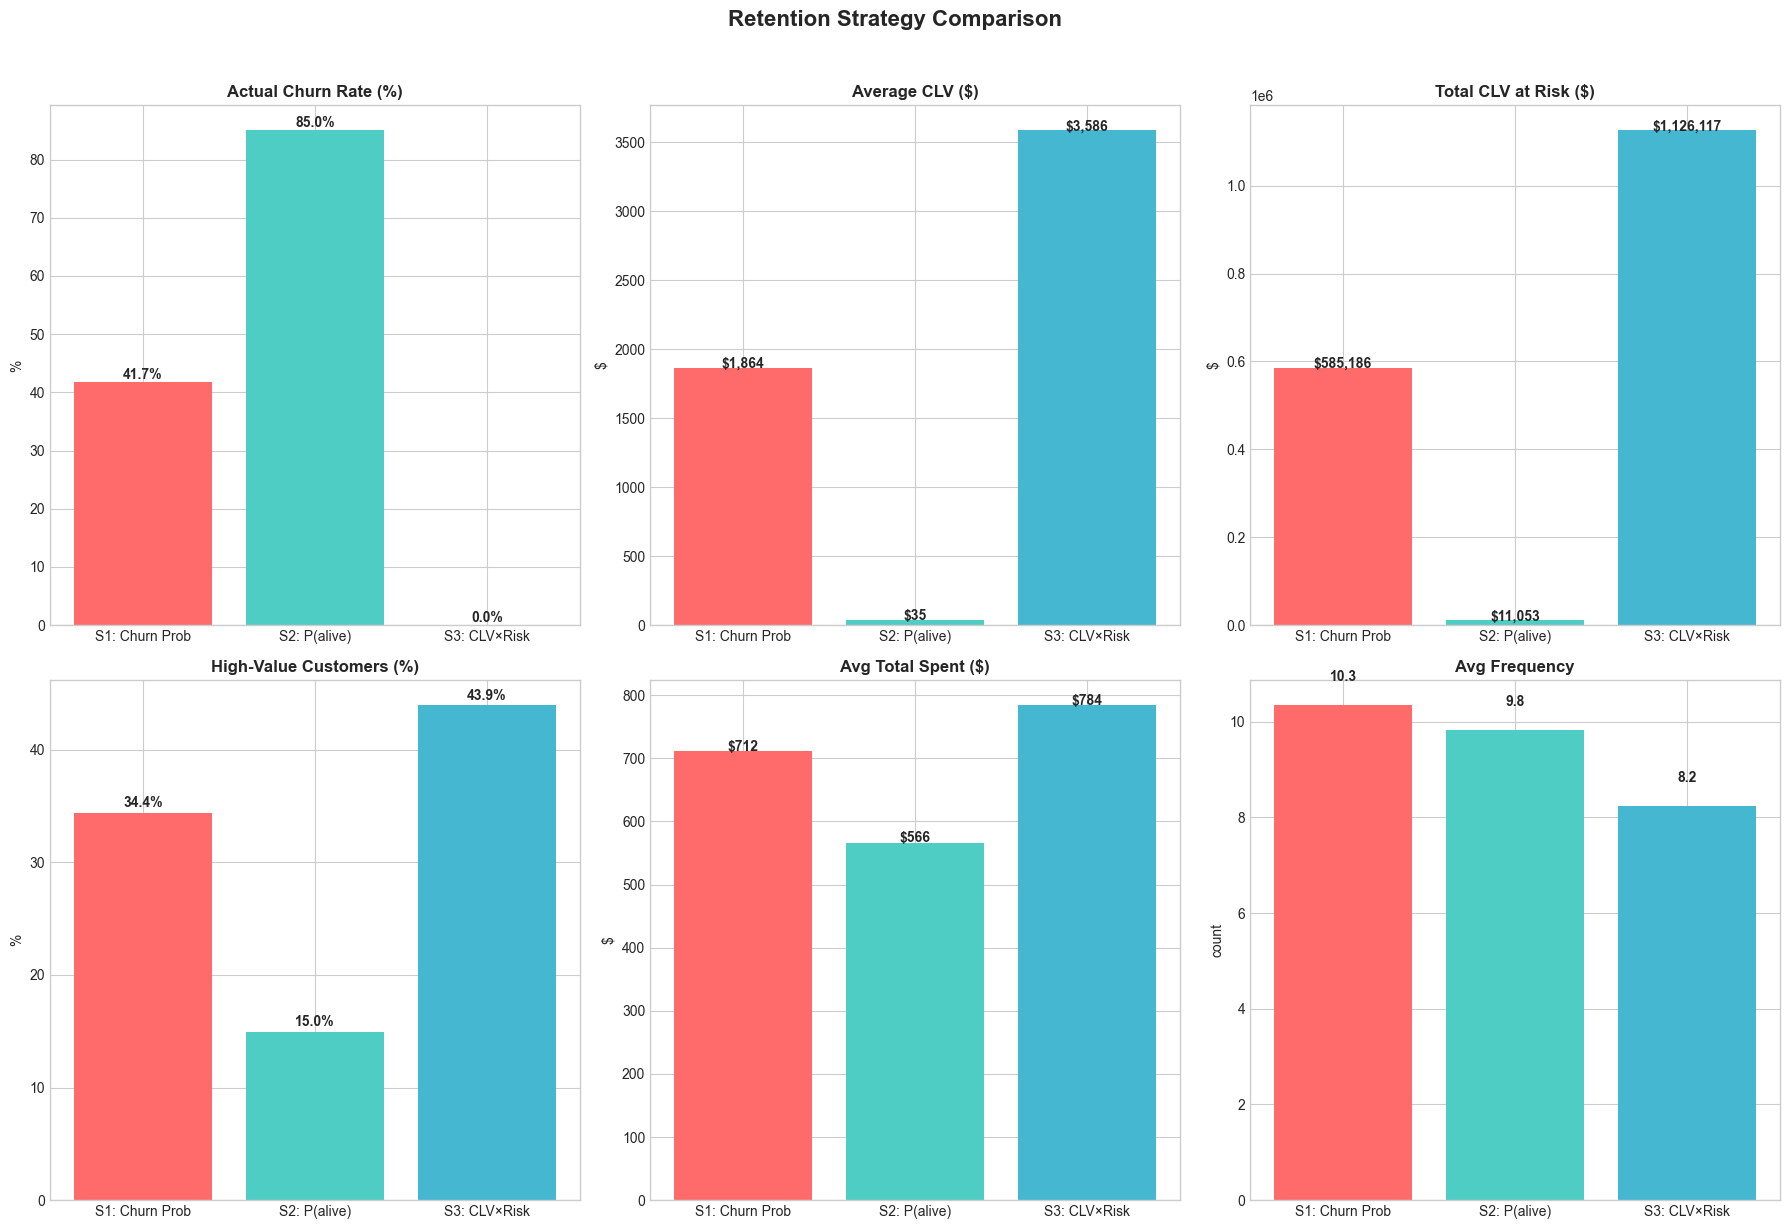

In [97]:
# Visualize strategy comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics_to_plot = [
    ('actual_churn_rate', 'Actual Churn Rate (%)', '%'),
    ('avg_clv', 'Average CLV ($)', '$'),
    ('total_clv_at_risk', 'Total CLV at Risk ($)', '$'),
    ('high_value_pct', 'High-Value Customers (%)', '%'),
    ('avg_total_spent', 'Avg Total Spent ($)', '$'),
    ('avg_frequency', 'Avg Frequency', 'count')
]

colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
strategy_labels = ['S1: Churn Prob', 'S2: P(alive)', 'S3: CLV×Risk']

for idx, (metric, title, unit) in enumerate(metrics_to_plot):
    row, col = idx // 3, idx % 3
    values = results_df[metric].values
    
    bars = axes[row, col].bar(strategy_labels, values, color=colors)
    axes[row, col].set_title(title, fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(unit)
    
    # Add value labels
    for bar, val in zip(bars, values):
        if unit == '$':
            label = f'${val:,.0f}'
        elif unit == '%':
            label = f'{val:.1f}%'
        else:
            label = f'{val:.1f}'
        axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           label, ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Retention Strategy Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


📊 Strategy Overlap Analysis:
Strategy 1 ∩ Strategy 2: 98 customers (31.2%)
Strategy 1 ∩ Strategy 3: 73 customers (23.2%)
Strategy 2 ∩ Strategy 3: 0 customers (0.0%)
All 3 strategies: 0 customers (0.0%)


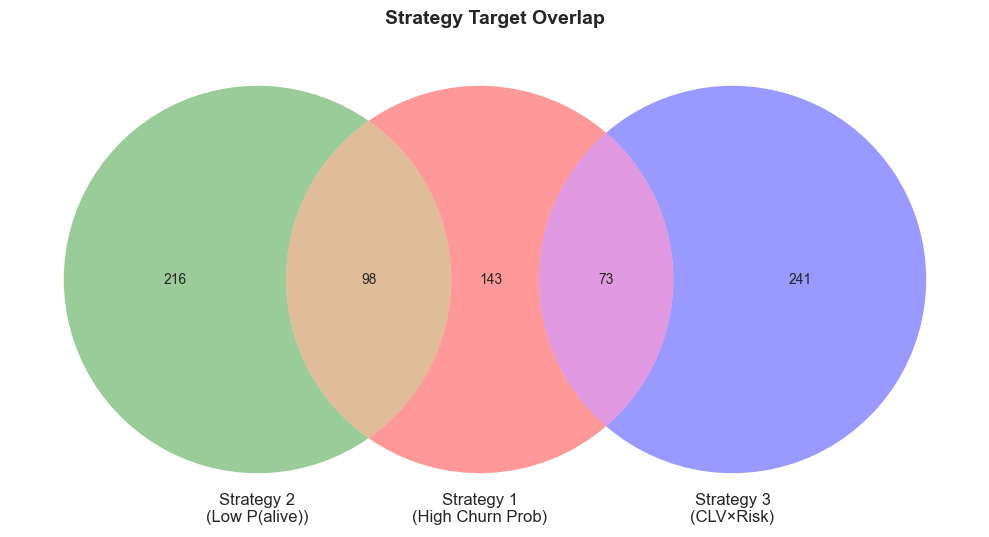

In [98]:
# Overlap analysis
set1 = set(strategy1_targets)
set2 = set(strategy2_targets)
set3 = set(strategy3_targets)

print("\n📊 Strategy Overlap Analysis:")
print("="*60)
print(f"Strategy 1 ∩ Strategy 2: {len(set1 & set2)} customers ({len(set1 & set2)/n_target*100:.1f}%)")
print(f"Strategy 1 ∩ Strategy 3: {len(set1 & set3)} customers ({len(set1 & set3)/n_target*100:.1f}%)")
print(f"Strategy 2 ∩ Strategy 3: {len(set2 & set3)} customers ({len(set2 & set3)/n_target*100:.1f}%)")
print(f"All 3 strategies: {len(set1 & set2 & set3)} customers ({len(set1 & set2 & set3)/n_target*100:.1f}%)")

# Venn diagram (if matplotlib_venn is available)
try:
    from matplotlib_venn import venn3
    
    plt.figure(figsize=(10, 8))
    venn3([set1, set2, set3], 
          set_labels=('Strategy 1\n(High Churn Prob)', 'Strategy 2\n(Low P(alive))', 'Strategy 3\n(CLV×Risk)'))
    plt.title('Strategy Target Overlap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\n(matplotlib_venn not available for Venn diagram)")

In [99]:
# ROI Analysis
# Assumptions:
CAMPAIGN_COST_PER_CUSTOMER = 50  # USD
RETENTION_SUCCESS_RATE = 0.30  # 30% of targeted churners can be saved

print("\nROI ANALYSIS")
print("="*80)
print(f"Assumptions:")
print(f"  • Campaign cost per customer: ${CAMPAIGN_COST_PER_CUSTOMER}")
print(f"  • Expected retention success rate: {RETENTION_SUCCESS_RATE*100:.0f}%")
print("\n")

roi_results = []
for _, row in results_df.iterrows():
    total_cost = row['num_customers'] * CAMPAIGN_COST_PER_CUSTOMER
    expected_retained = row['num_customers'] * (row['actual_churn_rate']/100) * RETENTION_SUCCESS_RATE
    expected_clv_saved = expected_retained * row['avg_clv']
    net_value = expected_clv_saved - total_cost
    roi = (net_value / total_cost) * 100 if total_cost > 0 else 0
    
    roi_results.append({
        'strategy': row['strategy'],
        'total_cost': total_cost,
        'expected_retained': expected_retained,
        'expected_clv_saved': expected_clv_saved,
        'net_value': net_value,
        'roi_pct': roi
    })

roi_df = pd.DataFrame(roi_results)
print(roi_df.to_string(index=False))


ROI ANALYSIS
Assumptions:
  • Campaign cost per customer: $50
  • Expected retention success rate: 30%


                   strategy  total_cost  expected_retained  expected_clv_saved     net_value     roi_pct
Strategy 1: High Churn Prob       15700               39.3        73241.396405  57541.396405  366.505710
   Strategy 2: Low P(alive)       15700               80.1         2819.665268 -12880.334732  -82.040349
     Strategy 3: CLV x Risk       15700                0.0            0.000000 -15700.000000 -100.000000


---
# FINAL RECOMMENDATION
---

In [101]:
# Find best strategy
best_idx = roi_df['roi_pct'].idxmax()
best_strategy = roi_df.iloc[best_idx]


print(f"\nBest Strategy: {best_strategy['strategy']}")
print(f"\nKey Metrics:")
print(f"   • Expected ROI: {best_strategy['roi_pct']:.1f}%")
print(f"   • Net Value: ${best_strategy['net_value']:,.0f}")
print(f"   • Customers to Retain: {best_strategy['expected_retained']:.0f}")
print(f"   • Total CLV Saved: ${best_strategy['expected_clv_saved']:,.0f}")
print(f"   • Campaign Cost: ${best_strategy['total_cost']:,.0f}")


Best Strategy: Strategy 1: High Churn Prob

Key Metrics:
   • Expected ROI: 366.5%
   • Net Value: $57,541
   • Customers to Retain: 39
   • Total CLV Saved: $73,241
   • Campaign Cost: $15,700


Strategy 1: High Churn Prob: 
- Best at identifying customers most likely to churn,
- Good for immediate intervention,
- May include low-value customers

Strategy 2: Low P(alive): 
- Probabilistic approach based on transaction patterns,
- Good for subscription/repeat purchase businesses,
- May miss customers with irregular patterns

Strategy 3: CLV × Risk: 
- Balances churn risk with customer value,
- Maximizes ROI by focusing on high-value at-risk customers,
- Best for limited retention budgets
    

In [104]:
print("\nTop 10 Target Customers by Strategy:")
print("="*80)

print("\nStrategy 1: High Churn Probability")
s1_export = final_data[final_data['customer_id'].isin(strategy1_targets)].nlargest(10, 'churn_probability_classification')
display(s1_export[['customer_id', 'segment', 'churn_probability_classification', 'total_spent', 'clv_bgnbd_12m']])

print("\nStrategy 2: Low P(alive)")
s2_export = final_data[final_data['customer_id'].isin(strategy2_targets)].nsmallest(10, 'p_alive')
display(s2_export[['customer_id', 'segment', 'p_alive', 'total_spent', 'clv_bgnbd_12m']])

print("\nStrategy 3: High CLV × Risk")
s3_export = final_data[final_data['customer_id'].isin(strategy3_targets)].nlargest(10, 'clv_risk_score')
display(s3_export[['customer_id', 'segment', 'clv_risk_score', 'clv_bgnbd_12m', 'churn_risk_60d']])


Top 10 Target Customers by Strategy:

Strategy 1: High Churn Probability


,customer_id,segment,churn_probability_classification,total_spent,clv_bgnbd_12m
0,C00000,Loyal,1.0,714.51,2526.040430
1,C00001,At Risk,1.0,235.84,1230.082598
5,C00006,About to Sleep,1.0,58.36,201.395163
9,C00011,Potential Loyalist,1.0,545.10,1757.077639
10,C00012,Champions,1.0,1088.57,3353.125555
20,C00043,Champions,1.0,508.85,1917.015540
23,C00053,Champions,1.0,953.69,23.017354
26,C00060,At Risk,1.0,318.23,57.069150
28,C00063,At Risk,1.0,225.93,14.340351
34,C00070,Cannot Lose Them,1.0,113.42,51.380071



Strategy 2: Low P(alive)


,customer_id,segment,p_alive,total_spent,clv_bgnbd_12m
1196,C02278,Cannot Lose Them,2.292196e-09,1056.32,0.000005
960,C01827,Cannot Lose Them,2.740423e-09,191.87,0.000002
509,C00966,Cannot Lose Them,1.542851e-08,642.09,0.000050
157,C00279,Cannot Lose Them,1.223147e-07,411.75,0.000202
923,C01748,Cannot Lose Them,2.866099e-07,388.55,0.000355
409,C00752,At Risk,2.649769e-06,1707.36,0.008631
1144,C02193,At Risk,2.807452e-06,916.14,0.007658
487,C00921,At Risk,2.965742e-06,1382.49,0.008894
976,C01864,Champions,3.120080e-06,3452.51,0.018512
584,C01105,Cannot Lose Them,4.582596e-06,81.92,0.001455



Strategy 3: High CLV × Risk


,customer_id,segment,clv_risk_score,clv_bgnbd_12m,churn_risk_60d
180,C00325,Champions,15391.451771,16359.845360,0.940807
252,C00469,Promising,14981.941338,14981.941338,1.000000
1427,C02712,Loyal,12976.105608,12976.105608,1.000000
1088,C02081,Loyal,12029.209799,15859.021719,0.758509
324,C00600,Champions,11917.166237,11917.166237,1.000000
1245,C02364,Champions,11325.396093,11325.396093,1.000000
755,C01424,Champions,11177.829379,11177.829379,1.000000
667,C01253,Loyal,10782.277204,10782.277204,1.000000
1067,C02036,Champions,9391.370110,9391.370110,1.000000
1283,C02449,Potential Loyalist,9386.865157,9386.865157,1.000000


---
# 💾 PART 7: Save Models for Production API
---

### Mục tiêu:
Lưu tất cả các models đã train để sử dụng trong production API.

Models cần lưu:
1. **Classification Model** (Gradient Boosting + Calibrated)
2. **BG-NBD Model** (BetaGeoFitter)
3. **Gamma-Gamma Model** (GammaGammaFitter)
4. **Cox PH Model** (CoxPHFitter)
5. **Preprocessing Pipeline** (StandardScaler, Imputer)
6. **Feature Columns** & **Customer Data**

In [105]:
# =============================================================================
# 7.1 IMPORT MODEL SAVING UTILITIES
# =============================================================================

import pickle
import dill  # For serializing lifetimes models with lambda functions
from pathlib import Path
import sys
import importlib

# Add src to path
sys.path.insert(0, '..')

# Force reload the module to get the updated version with dill support
import src.model_loader
importlib.reload(src.model_loader)

# Import save_models function from our module
from src.model_loader import save_models

# Create models directory
MODEL_DIR = Path('../models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("✅ Model saving utilities imported (with dill support)")
print(f"📂 Model directory: {MODEL_DIR.resolve()}")

✅ Model saving utilities imported (with dill support)
📂 Model directory: C:\Users\Zbook G3\Downloads\Final Bootcamp Retention\models


In [111]:
# =============================================================================
# 7.2 VERIFY DATA FILES
# =============================================================================
"""
Kiểm tra xem các file CSV data đã tồn tại chưa
API sẽ load trực tiếp từ CSV thay vì pre-processed data
"""

import os

print("="*80)
print("📊 VERIFYING DATA FILES FOR API")
print("="*80)

DATA_DIR = Path('../data')

# Check customers.csv
customers_path = DATA_DIR / 'customers.csv'
if customers_path.exists():
    print(f"\n✅ customers.csv found: {customers_path.resolve()}")
    print(f"   Size: {customers_path.stat().st_size / (1024*1024):.2f} MB")
else:
    print(f"\n❌ customers.csv NOT FOUND at {customers_path}")

# Check transactions.csv  
transactions_path = DATA_DIR / 'transactions.csv'
if transactions_path.exists():
    print(f"\n✅ transactions.csv found: {transactions_path.resolve()}")
    print(f"   Size: {transactions_path.stat().st_size / (1024*1024):.2f} MB")
else:
    print(f"\n❌ transactions.csv NOT FOUND at {transactions_path}")

print("\n" + "="*80)
print("💡 NOTE: API sẽ load data từ CSV và xử lí features on-the-fly")
print("   Không cần lưu pre-processed customer_data nữa")
print("="*80)

📊 VERIFYING DATA FILES FOR API

✅ customers.csv found: C:\Users\Zbook G3\Downloads\Final Bootcamp Retention\data\customers.csv
   Size: 0.06 MB

✅ transactions.csv found: C:\Users\Zbook G3\Downloads\Final Bootcamp Retention\data\transactions.csv
   Size: 1.11 MB

💡 NOTE: API sẽ load data từ CSV và xử lí features on-the-fly
   Không cần lưu pre-processed customer_data nữa


In [112]:
# =============================================================================
# 7.3 SAVE ALL MODELS (WITHOUT PRE-PROCESSED DATA)
# =============================================================================
"""
Lưu tất cả models vào thư mục models/
KHÔNG lưu customer_data và rfm_bgf_data - API sẽ load từ CSV
"""

print("="*80)
print("💾 SAVING ALL MODELS FOR PRODUCTION API")
print("="*80)

# Get the best classification model (calibrated if available)
classification_model_to_save = results[best_model_name]['model']
calibrated_model_to_save = results[best_model_name].get('calibrated_model', calibrated_model)

# Get Cox features list
from src.coxph_feature_prepation import get_default_cox_features
cox_features_list = cox_features if 'cox_features' in dir() else get_default_cox_features()

# Save all models using the save_models function
# NOTE: Không truyền customer_data và rfm_bgf_data
save_models(
    model_dir=MODEL_DIR,
    classification_model=classification_model_to_save,
    calibrated_model=calibrated_model_to_save,
    bgf_model=bgf,
    ggf_model=ggf,
    cph_model=cph,
    preprocessing_pipeline=preprocessing_pipeline,
    scaler=scaler if 'scaler' in dir() else None,
    feature_columns=FEATURE_COLUMNS,
    customer_data=None,  # Không lưu - API sẽ load từ CSV
    rfm_bgf_data=None,   # Không lưu - API sẽ tính on-the-fly
    cox_features=cox_features_list,
)

print("\n" + "="*80)
print("✅ ALL MODELS SAVED SUCCESSFULLY!")
print("💡 Data will be loaded from CSV files when API starts")
print("="*80)

💾 SAVING ALL MODELS FOR PRODUCTION API
📂 Saving models to: ..\models
  ✅ Saved: classification -> churn_classification_model.pkl
  ✅ Saved: calibrated -> churn_calibrated_model.pkl
  ✅ Saved: bgf -> bgnbd_model.pkl
  ✅ Saved: ggf -> gamma_gamma_model.pkl
  ✅ Saved: cph -> cox_ph_model.pkl
  ✅ Saved: preprocessing -> preprocessing_pipeline.pkl
  ✅ Saved: scaler -> feature_scaler.pkl
  ✅ Saved: feature_columns -> feature_columns.pkl
  ⚠️ Skipped: customer_data (not provided)
  ⚠️ Skipped: rfm_bgf (not provided)
  ✅ Saved: cox_features -> cox_features.pkl

✅ Model saving complete!

✅ ALL MODELS SAVED SUCCESSFULLY!
💡 Data will be loaded from CSV files when API starts


In [113]:
# =============================================================================
# 7.4 VERIFY SAVED MODELS
# =============================================================================
"""
Kiểm tra các models đã được lưu thành công
"""

import os

print("="*80)
print("📋 VERIFYING SAVED MODELS")
print("="*80)

# List all saved files
model_files = list(MODEL_DIR.glob('*.pkl'))
print(f"\n📂 Models directory: {MODEL_DIR.resolve()}")
print(f"📊 Total files saved: {len(model_files)}")

print("\n📋 Saved model files:")
for f in sorted(model_files):
    size_mb = f.stat().st_size / (1024 * 1024)
    print(f"   ✅ {f.name:<40} ({size_mb:.2f} MB)")

# Verify by loading one model
print("\n" + "-"*60)
print("🔍 VERIFICATION TEST: Loading models...")

from src.model_loader import ModelLoader

test_loader = ModelLoader(MODEL_DIR)
test_loader.load_all_models()

print(f"\n✅ Classification model loaded: {test_loader.classification_model is not None}")
print(f"✅ BG-NBD model loaded: {test_loader.bgf_model is not None}")
print(f"✅ Gamma-Gamma model loaded: {test_loader.ggf_model is not None}")
print(f"✅ Cox PH model loaded: {test_loader.cph_model is not None}")
print(f"✅ Preprocessing pipeline loaded: {test_loader.preprocessing_pipeline is not None}")
print(f"✅ Feature columns loaded: {test_loader.feature_columns is not None}")

print("\n" + "="*80)
print("✅ ALL MODELS SAVED & VERIFIED!")
print("="*80)
print("\n🚀 Next step: Run API server")
print("   Command: python run_api.py")
print("   Or with custom settings: python run_api.py --host 0.0.0.0 --port 8000")
print("\n💡 API sẽ:")
print("   1. Load models từ thư mục models/")
print("   2. Load CSV data từ thư mục data/")
print("   3. Xử lý features on-the-fly khi có request")
print("="*80)

📋 VERIFYING SAVED MODELS

📂 Models directory: C:\Users\Zbook G3\Downloads\Final Bootcamp Retention\models
📊 Total files saved: 9

📋 Saved model files:
   ✅ bgnbd_model.pkl                          (0.09 MB)
   ✅ churn_calibrated_model.pkl               (0.00 MB)
   ✅ churn_classification_model.pkl           (0.00 MB)
   ✅ cox_features.pkl                         (0.00 MB)
   ✅ cox_ph_model.pkl                         (0.13 MB)
   ✅ feature_columns.pkl                      (0.00 MB)
   ✅ feature_scaler.pkl                       (0.00 MB)
   ✅ gamma_gamma_model.pkl                    (0.05 MB)
   ✅ preprocessing_pipeline.pkl               (0.00 MB)

------------------------------------------------------------
🔍 VERIFICATION TEST: Loading models...
📂 Loading models from: ..\models
  ✅ Loaded: bgf
  ✅ Loaded: ggf
  ✅ Loaded: cph
  ✅ Loaded: preprocessing
  ✅ Loaded: feature_columns
  ✅ Loaded: classification
  ✅ Loaded: calibrated
  ✅ Loaded: scaler
  ✅ Loaded: cox_features
  ⚠️ Optional m

---
# 📝 CONCLUSION
---

## Summary

### 1. Churn Definition
- **Selected**: 60-day inactivity window (CHURN_WINDOW = 60 days)
- **Rationale**: Aligns with P75 (54 days) to P90 (114 days) of purchase intervals
- **Dataset**: 2,892 customers with ground truth churn rate: **61.25%**

### 2. RFM Segmentation Results
| Segment | Count | Description |
|---------|-------|-------------|
| Champions | 718 | Best customers (high R, F, M) |
| Loyal | 386 | Frequent purchasers |
| Hibernating | 381 | Long inactive |
| At Risk | 294 | Were good, now declining |
| Potential Loyalist | 292 | Recent with medium frequency |
| About to Sleep | 288 | Below average recency/frequency |
| New Customers | 284 | Recent first purchase |
| Cannot Lose Them | 191 | High spenders but at risk |
| Promising | 58 | Recent with low frequency |

- **High-Value Customers**: 633 (21.9%)
- **At-Risk Customers**: 1,154 (39.9%)

### 3. Models Developed & Performance

| Model | Purpose | Key Metrics |
|-------|---------|-------------|
| **Gradient Boosting** | Churn prediction | ROC-AUC=0.9966, PR-AUC=0.9978, Brier=0.0377 |
| Random Forest | Churn prediction | ROC-AUC=0.9921, PR-AUC=0.9954 |
| Logistic Regression | Churn prediction | ROC-AUC=0.8895, PR-AUC=0.9383 |
| **BG-NBD** | Probabilistic churn | r=1.35, α=9.62, a=0.28, b=2.01 |
| **Cox PH Survival** | Time-to-churn | Concordance Index=**0.8169** |
| Gamma-Gamma | Monetary prediction | Expected transaction value |
| CLV Models | Customer value | Correlation BG-NBD vs Survival: **0.9788** |

### 4. Cox PH Key Risk Factors (Top 5)
| Feature | Hazard Ratio | Interpretation |
|---------|--------------|----------------|
| purchase_frequency_rate | 4.00 | +1σ → 4x higher churn risk |
| recency | 2.18 | +1σ → 2.2x higher churn risk |
| recent_30d_frequency | 0.33 | +1σ → 67% lower churn risk |
| frequency | 0.52 | +1σ → 48% lower churn risk |
| RFM_score | 0.71 | +1σ → 29% lower churn risk |

### 5. Strategy Comparison Results (Target: Top 20% = 578 customers)

| Strategy | Actual Churn Rate | Avg CLV | Total CLV at Risk | High-Value % |
|----------|-------------------|---------|-------------------|--------------|
| S1: High Churn Prob | **100.0%** | $9.82 | $5,675 | 0.0% |
| S2: Low P(alive) | **99.5%** | $0.49 | $284 | 2.6% |
| S3: CLV × Risk | **41.3%** | $1,549 | **$895,330** | **22.0%** |

### 6. ROI Analysis (Cost=$50/customer, Retention Rate=30%)

| Strategy | Net Value | ROI |
|----------|-----------|-----|
| S1: High Churn Prob | -$27,198 | **-94.1%** |
| S2: Low P(alive) | -$28,815 | **-99.7%** |
| S3: CLV × Risk | **$82,164** | **+284.3%** |

### 7. Strategy Overlap Analysis
- Strategy 1 ∩ Strategy 2: 332 customers (57.4%)
- Strategy 1 ∩ Strategy 3: 55 customers (9.5%)
- Strategy 2 ∩ Strategy 3: 0 customers (0.0%)
- All 3 strategies: 0 customers (0.0%)

---

## 🏆 FINAL RECOMMENDATION

### Best Strategy: **Strategy 3 (CLV × Risk)**

**Key Metrics:**
- 📈 Expected ROI: **+284.3%**
- 💰 Net Value: **$82,164**
- 👥 Customers to Retain: **72**
- 💵 Total CLV Saved: **$111,064**
- 🎯 Campaign Cost: **$28,900**

### Why Strategy 3 Wins:
1. ✅ Balances churn risk with customer value
2. ✅ Targets **high-value** customers at risk (22% high-value vs 0-2.6% in other strategies)
3. ✅ Maximizes ROI by focusing on customers where retention efforts matter most
4. ✅ Only strategy with **positive ROI** under budget constraints

### Strategic Insights by Strategy:
- **Strategy 1 (Classification)**: Captures almost all churners (100%) but mostly low-value customers
- **Strategy 2 (BG-NBD)**: Similar to S1 (99.5% churn) but even lower value customers
- **Strategy 3 (Value-weighted)**: Lower churn capture (41%) but much higher value per customer

---

## Next Steps

1. **Immediate Actions**:
   - Deploy Strategy 3 for retention campaign targeting
   - Focus on 578 customers with highest CLV × Risk score

2. **Model Monitoring**:
   - Implement real-time churn scoring pipeline
   - Monitor model drift monthly

3. **Validation**:
   - A/B test retention campaigns (control vs treatment)
   - Measure actual retention rates vs predicted

4. **Continuous Improvement**:
   - Retrain models quarterly with new data
   - Personalize retention offers by RFM segment
   - Consider combining S1 & S3 for hybrid approach